In [1]:
import os
import utils
import connectome_create
# viz_method = one of ['itkwidgets', 'vtk']
viz_method = 'vtk'

# import some of our favorite packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
import cmocean

%matplotlib inline
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering
from sklearn import cluster 
from scipy.cluster.hierarchy import dendrogram
from scipy.stats import iqr
from scipy.stats import mannwhitneyu
from scipy.stats import kstest
# import nglui.statebuilder as ngstbld

# # this is the EM specific package for querying the EM data
from caveclient import CAVEclient

from sklearn.decomposition import PCA
from numpy.random import default_rng

# from meshparty import trimesh_io, trimesh_vtk
# from meshparty import skeletonize, skeleton_io, skeleton
# import cloudvolume

%load_ext autoreload
%autoreload 2

query timestamp: 2024-01-17 08:10:01.179472-08:00 (1705507801.179472)


# Comparing gray scales

[0.9994561956101177, 0.8819161611761233, 0.7737534020488214, 0.6733142765345892, 0.5752268912635539, 0.48637956872241056, 0.4013915586677524, 0.3190591186974825, 0.2344347349188553, 0.15241008329281713, 0.06515218007540821, 5.119113838889112e-07]
[1.0, 0.9575547866205305, 0.9012072279892349, 0.8328950403690888, 0.7502191464821223, 0.6434140715109573, 0.5387158785082661, 0.440322952710496, 0.342883506343714, 0.22329873125720878, 0.10469819300269129, 0.0]


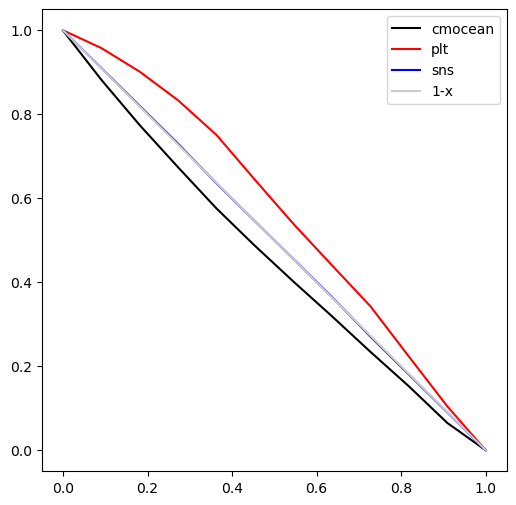

In [2]:
cmap1= cmocean.cm.gray_r
cmap2 = plt.get_cmap('Greys')
cmap3 = sns.color_palette('gray_r', as_cmap=True)

# Generate 12 evenly-spaced values between 0 and 1
x = np.linspace(0, 1, 12)

# Get the corresponding colors from the colormap
colors1 = [cmap1(value) for value in x]
colors2 = [cmap2(value) for value in x]
colors3 = [cmap3(value) for value in x]

# # Convert the RGBA colors to hexadecimal strings
r_vals1 = [r for r, g, b, _ in colors1]
r_vals2 = [r for r, g, b, _ in colors2]
r_vals3 = [r for r, g, b, _ in colors3]


# print(hex_colors)
print(r_vals1)
print(r_vals2)


# plot the MWU AUC curves
fig = plt.figure(1, figsize=(6, 6))
ax = plt.subplot()
# ax.set_ylim([.95, 0.999])
# ax.set_ylabel('MWU AUC value')
# ax.set_xlabel('MN')
# ax.set_title('put the ltm in each pool')
# ax.xaxis.set_ticks_position('top')
# ax.set_xticks(range(len(mwu_val)))
# ax.set_xticklabels(pool_keys,rotation = 90)


ax.plot(x,r_vals1,color='#000000',label='cmocean')
ax.plot(x,r_vals2,color='#FF0000',label='plt')
ax.plot(x,r_vals3,color='#0000FF',label='sns')
ax.plot(x,1-x,color='#CCCCCC',label='1-x')
plt.legend()
plt.show()


cos_cmap = sns.color_palette('gray_r', as_cmap=True)

# Plotting functions

In [3]:

All = slice(None)

def plot_sim_map(sim_mat,df,fn=None):
    fig = plt.figure(1, figsize = [6,6])

    mn_mi = df.columns.to_frame()
    ax = sns.heatmap(sim_mat, xticklabels=mn_mi.loc[:,'rank'].to_list(),cmap=cos_cmap,vmin=0,vmax=1)
    ax.xaxis.set_ticks_position('top')
    cbar = ax.collections[0].colorbar
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
    cbar.set_label(label = 'cosine similarity')
    plt.xlabel('MTF')
    plt.show()

    if not fn is None:
        fig.savefig('./figpanels/{}.svg'.format(fn),format='svg')

def plot_conn_map(conn_mat,df,fn=None):
    fig = plt.figure(2, figsize = [6,12])
    mn_mi = df.columns.to_frame()
    lbls = [str(i)+str(j) for i,j in zip(mn_mi.loc[:,'muscle'].to_list(),mn_mi.loc[:,'rank'].to_list())]
    ax = sns.heatmap(conn_mat, xticklabels=lbls, cmap=utils.white_dense())
    # ax.xaxis.set_ticks_position('top')
    cbar = ax.collections[0].colorbar
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

    cbar.set_label(label = '# syn')
    plt.xlabel('Motor Neurons')
    plt.show()
    if not fn is None:
        fig.savefig('./figpanels/{}.svg'.format(fn),format='svg')

def plot_hem_conn_map(conn_mat,df,ct,fn=None):
    fig = plt.figure(2, figsize = [6,12])
    mn_mi = df.columns.to_frame()
    ax = sns.heatmap(conn_mat, xticklabels=mn_mi.loc[:,'rank'].to_list(), cmap=utils.white_dense())
    # ax.xaxis.set_ticks_position('top')
    cbar = ax.collections[0].colorbar
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

    yticks = df.index.get_locs((All,All,All,All,ct,All))
    ax.set_yticks(yticks)
    ax.set_yticklabels([ct]*len(yticks))
    
    cbar.set_label(label = '# syn')
    plt.xlabel('Motor Neurons')
    plt.show()

    if not fn is None:
        fig.savefig('./figpanels/{}.svg'.format(fn),format='svg')


def plot_mask(conn_mat,df,fn=None):
    fig = plt.figure(3, figsize = [6,12])
    mn_mi = df.columns.to_frame()
    ax = sns.heatmap(conn_mat, xticklabels=mn_mi.loc[:,'rank'].to_list(),cmap=cos_cmap,vmin=0,vmax=1)
    # ax.xaxis.set_ticks_position('top')
    cbar = ax.collections[0].colorbar
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

    cbar.set_label(label = '# syn')
    plt.xlabel('Motor Neurons')
    plt.show()
    
    if not fn is None:
        print(fn)
        fig.savefig('./figpanels/{}.svg'.format(fn),format='svg')

def plot_shuf_cdf(x_unsorted,color = '#000000',ref_x=None, fn=None,fignum=4,title=None,ax=None,xlabel = None):
    fig = plt.figure(fignum, figsize=(10, 6))
    if ax is None:
        ax = plt.subplot2grid((1,1),(0,0))
        ax.set_ylim([-.1, 1.1])
        ax.set_xlim([.945, .96])
        ax.set_xlim([0, 1])

    ax.set_ylabel('Cummulative fraction')
    ax.set_xlabel(xlabel)
    ax.set_title(title)

    # colors = {1: '#CCCCCC', 2: '#666666',3: '#000000'}
    # for m in [1,2,3]:
    # exec('mu=mixups_{}'.format(m))
    y = np.array(range(len(x_unsorted))).astype(float)/len(x_unsorted)
    ax.plot(sorted(x_unsorted),y,color=color)
    if not ref_x is None:
        ax.plot(ref_x*np.array([1,1]),np.array([0,1]),color='#0000FF')

        pct_below_actual = (x_unsorted<ref_x).sum() / len(x_unsorted)
        p=1-pct_below_actual
        ax.text(.1,.5,'p = {:.5f}'.format(p))

    if not fn is None:
        fig.savefig('./figpanels/{}.svg'.format(fn),format='svg')

    return ax

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy.integrate import simps

def plot_normalized_pdf(data, ax=None, color = '#000000',ref_x=None, fn=None,fignum=4,title=None,xlabel = None,plotcdf = False):

    # Sort the input data
    sorted_data = np.sort(data)

    # pad
    left = sorted_data.min()-0
    left_pts = np.linspace(0,sorted_data.min(), int(100*left))
    right = 1-sorted_data.max()
    right_pts = np.linspace(sorted_data.max(),1, int(100*right))

    # pad with more points
    # Calculate the cumulative distribution function (CDF)
    padded_sorted_data = np.concatenate([left_pts, sorted_data, right_pts])
    cdf = np.concatenate([np.zeros(len(left_pts)), np.arange(1, len(sorted_data) + 1) / len(sorted_data), np.ones(len(right_pts))])

    sorted_data_u, unique_indices = np.unique(padded_sorted_data, return_index=True)
    cdf_u = cdf[unique_indices]

    if left_pts.size>0 and right_pts.size>0:
        x_intp = np.linspace(left/2,sorted_data.max()+right/2,200)
    elif left_pts.size==0:
        x_intp = np.linspace(sorted_data_u.min(),sorted_data.max()+right/2,200)

    cdf_intp = interp1d(sorted_data_u, cdf_u, kind='linear')(x_intp)


    cdf_dict = {'x_intp':x_intp,'cdf_intp':cdf_intp}
    smooth_df = pd.DataFrame.from_dict(cdf_dict)
    smooth_df
    smooth_df['moving_average'] = smooth_df['cdf_intp'].rolling(window=7).mean()
    smooth_df['skootched'] = 0.
    smooth_df['skootched'].iloc[0:-4] = smooth_df['moving_average'].iloc[3:-1]
    smooth_df['skootched'].iloc[0:4] = 0.
    smooth_df['skootched'].iloc[-4:] = 1.
    smooth_df['pdf'] = 0.
    smooth_df['pdf'].iloc[0:-1] = np.diff(smooth_df['skootched'].to_numpy())


    pdf_df = smooth_df.loc[:,['x_intp','pdf']]
    pdf_df
    pdf_df = pdf_df.loc[(pdf_df['x_intp']<sorted_data.max()) & (pdf_df['x_intp']>sorted_data.min())]

    fig = plt.figure(fignum, figsize=(10, 6))
    if ax is None:
        ax = plt.subplot2grid((1,1),(0,0))
        ax.set_ylim([0, 1])
        ax.set_xlim([0, 1])

    ax.plot(pdf_df['x_intp'], pdf_df['pdf'], label='pdf', color=color)

    if plotcdf:
        ax.plot(smooth_df.x_intp, smooth_df.skootched, label='smoothed',color='#CCCCCC')
        ax.plot(sorted_data, np.arange(1, len(sorted_data) + 1) / len(sorted_data), label='cdf',color='#4444FF')

    if ref_x :
        ax.plot(ref_x*np.array([1,1]),np.array([0,1]),color='#0000FF')

        pct_below_actual = (data<ref_x).sum() / len(data)
        p=1-pct_below_actual
        ax.text(.1,.5,'p = {:.5f}'.format(p))

    ax.plot(data.mean()*np.array([1,1]),np.array([0,1]),color='#ff7300')
    if fn:
        fig.savefig('./figpanels/{}.svg'.format(fn),format='svg')

    plt.show()

# Example for Figure 3 of paper

[[ 5.  8. 11.  0.  0.  0.]
 [ 7. 11. 16.  0.  0.  0.]
 [ 9. 14. 21.  0.  0.  0.]
 [11. 19. 24.  0.  0.  0.]
 [ 0.  0.  0. 30.  9.  6.]
 [ 0.  0.  0.  5. 30. 30.]
 [ 9.  0.  0.  8. 30.  5.]]
[[0.02151667 0.03442667 0.04733667 0.         0.         0.        ]
 [0.03012333 0.04733667 0.06885333 0.         0.         0.        ]
 [0.03873    0.06024667 0.09037    0.         0.         0.        ]
 [0.04733667 0.08176333 0.10328    0.         0.         0.        ]
 [0.         0.         0.         0.1291     0.03873    0.02582   ]
 [0.         0.         0.         0.02151667 0.1291     0.1291    ]
 [0.03873    0.         0.         0.03442667 0.1291     0.02151667]]
[[1.         0.87821808 0.87887315 0.12117143 0.3294847  0.0768275 ]
 [0.87821808 1.         0.99702171 0.         0.         0.        ]
 [0.87887315 0.99702171 1.         0.         0.         0.        ]
 [0.12117143 0.         0.         1.         0.48389529 0.37952631]
 [0.3294847  0.         0.         0.48389529 1.  

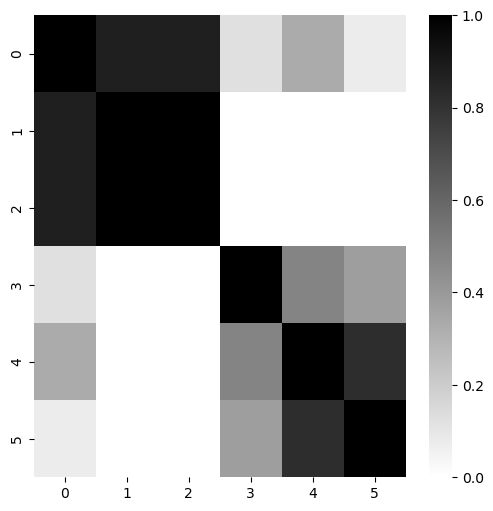

[0 1 2 3 4 5]


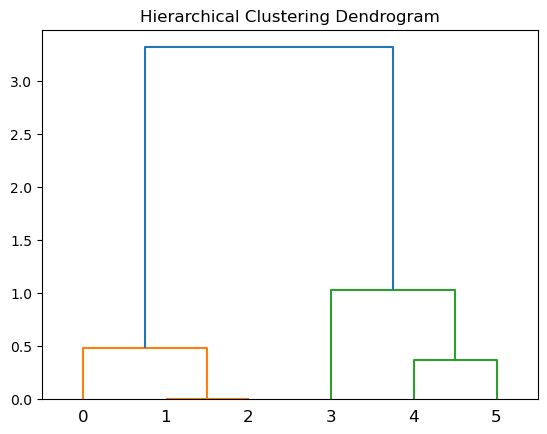

In [4]:
cos_cmap = sns.color_palette('gray_r', as_cmap=True)


a = np.array([[30., 9.,  6. , 0. , 0 , 10.] ,
              [5.,  30., 30., 0. , 0. , 0.], 
              [8.,  30., 5.,  0. , 0. , 0.],
              [0.,   0.,  0., 5. , 8 , 11.], 
              [0.,   0.,  0., 7 , 11. , 16], 
              [0.,   0.,  0., 9 , 14. , 21], 
              [0.,   9,  0., 11. , 16 , 24], 
              ])

a = np.array([[5. , 8 , 11. , 0. , 0 , 0.] ,
              [7 , 11. , 16, 0. , 0. , 0.], 
              [9 , 14. , 21,  0. , 0. , 0.],
              [11. , 19 , 24, 0. , 0 , 0], 
              [0.,   0.,  0., 30., 9.,  6. ,], 
              [0.,   0.,  0., 5.,  30., 30.,], 
              [9.,   0,  0.,  8.,  30., 5.,], 
              ])

r = 30/0.1291

print(a)
print(a/r)
sim_mat = cosine_similarity(a.T)
print(sim_mat)

fig = plt.figure(1, figsize = [6,6])
ax = sns.heatmap(sim_mat, cmap=cos_cmap)
plt.show()

fig.savefig('./figpanels/cos_example_figure.svg',format='svg')

from sklearn.metrics.pairwise import cosine_similarity
from sklearn import cluster 
from scipy.cluster.hierarchy import dendrogram

# setting distance_threshold=0 ensures we compute the full tree.
model = cluster.AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(sim_mat)

plt.title("Hierarchical Clustering Dendrogram")

counts = np.zeros(model.children_.shape[0])
n_samples = len(model.labels_)
for i, merge in enumerate(model.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack(
    [model.children_, model.distances_, counts]
).astype(float)

dend_dict = dendrogram(linkage_matrix,labels=np.arange(a.shape[1]))
fig = plt.gcf()
fig.savefig('./figpanels/cluster_dengrogram_ex.svg',format='svg')

# sorted order of indices found through clustering
clustered_order = dend_dict['ivl']
# plt.close()

clustered_order = np.array(clustered_order).astype(int) # convert strings into integers
print(clustered_order)

# Leg MNs

In [6]:
# pre_to_mn_df = connectome_create.load_pre_to_mn_df(ext='pre_match_to_pool_w_fragments')
pre_to_mn_df = pd.read_pickle('./dfs_pre_to_mn/pre_to_mn_df_pre_match_to_pool_w_fragments_v840.pkl')
pre_to_mn_df.shape
pre_to_mn_df.sum(axis=0).sum()

232534

In [7]:
# pre_to_mn_df = connectome_create.load_pre_to_mn_df(ext='matched_typed_with_nt')
pre_to_mn_df = pd.read_pickle('./dfs_pre_to_mn/pre_to_mn_df_matched_typed_with_nt_v840.pkl')
pre_to_mn_df.shape
pre_to_mn_df.sum(axis=0).sum()

212190

In [8]:
pre_to_mn_df.sum(axis=0).iloc[21:25]

side  nerve      segment  function  muscle             rank   segID               module         
L     Accessory  coxa     flex      trochanter_flexor  AcPst  648518346477140752  trochanter_flex      81
                                                              648518346520393297  trochanter_flex     737
                                                       Ac     648518346466168368  trochanter_flex    2644
                                                              648518346470645246  trochanter_flex    3765
dtype: int64

[ 0  2  1  3  6  4  5 38 39 54 68 55 56 21 63 64  7  9 10 11  8 12 32 33
 36 37 34 35 16 15 13 14 18 20 17 19 67 51 52 53 66 49 50 60 62 59 61 57
 58 40 41 44 42 43 47 45 46 48 65 26 27 23 24 25 28 30 31 22 29]


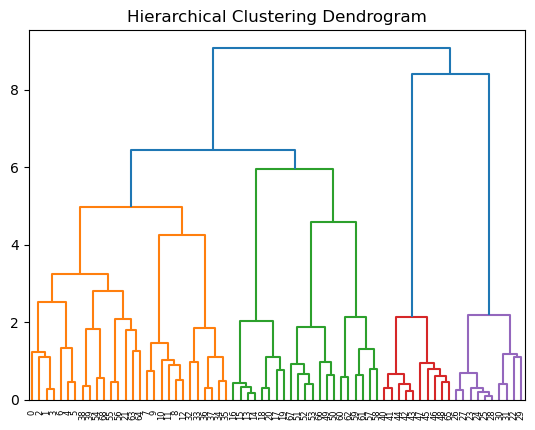

In [9]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import cluster 
from scipy.cluster.hierarchy import dendrogram

lbls = [ i + '_'+j for i,j in zip(pre_to_mn_df.columns.get_level_values('muscle'),pre_to_mn_df.columns.get_level_values('rank').astype('str'))]

sim_mat = cosine_similarity(pre_to_mn_df.to_numpy().transpose())

# setting distance_threshold=0 ensures we compute the full tree.
model = cluster.AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(sim_mat)
# model = cluster.AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(sim_mat)
plt.title("Hierarchical Clustering Dendrogram")

counts = np.zeros(model.children_.shape[0])
n_samples = len(model.labels_)
for i, merge in enumerate(model.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack(
    [model.children_, model.distances_, counts]
).astype(float)

dend_dict = dendrogram(linkage_matrix,labels=np.arange(len(lbls)))
fig = plt.gcf()
fig.savefig('./figpanels/cluster_dengrogram_leg.svg',format='svg')

# sorted order of indices found through clustering
clustered_order = dend_dict['ivl']
# plt.close()

clustered_order = np.array(clustered_order).astype(int) # convert strings into integers
print(clustered_order)

leaves_color_dict = {'all': dend_dict['leaves_color_list']}
ivl_dict = {'all': dend_dict['ivl']}


In [10]:
linkage_matrix

array([[2.50000000e+01, 2.80000000e+01, 9.92000832e-02, 2.00000000e+00],
       [1.30000000e+01, 1.40000000e+01, 1.76158707e-01, 2.00000000e+00],
       [2.40000000e+01, 6.90000000e+01, 1.99321866e-01, 3.00000000e+00],
       [4.20000000e+01, 4.30000000e+01, 2.22004687e-01, 2.00000000e+00],
       [2.60000000e+01, 2.70000000e+01, 2.41390238e-01, 2.00000000e+00],
       [1.00000000e+00, 3.00000000e+00, 2.72022034e-01, 2.00000000e+00],
       [4.00000000e+01, 4.10000000e+01, 2.97970358e-01, 2.00000000e+00],
       [3.60000000e+01, 3.70000000e+01, 3.00993263e-01, 2.00000000e+00],
       [1.80000000e+01, 2.00000000e+01, 3.11499837e-01, 2.00000000e+00],
       [2.30000000e+01, 7.10000000e+01, 3.15711029e-01, 4.00000000e+00],
       [1.50000000e+01, 7.00000000e+01, 3.31039406e-01, 3.00000000e+00],
       [3.80000000e+01, 3.90000000e+01, 3.48212038e-01, 2.00000000e+00],
       [4.40000000e+01, 7.20000000e+01, 4.03396693e-01, 3.00000000e+00],
       [3.00000000e+01, 3.10000000e+01, 4.14079659e

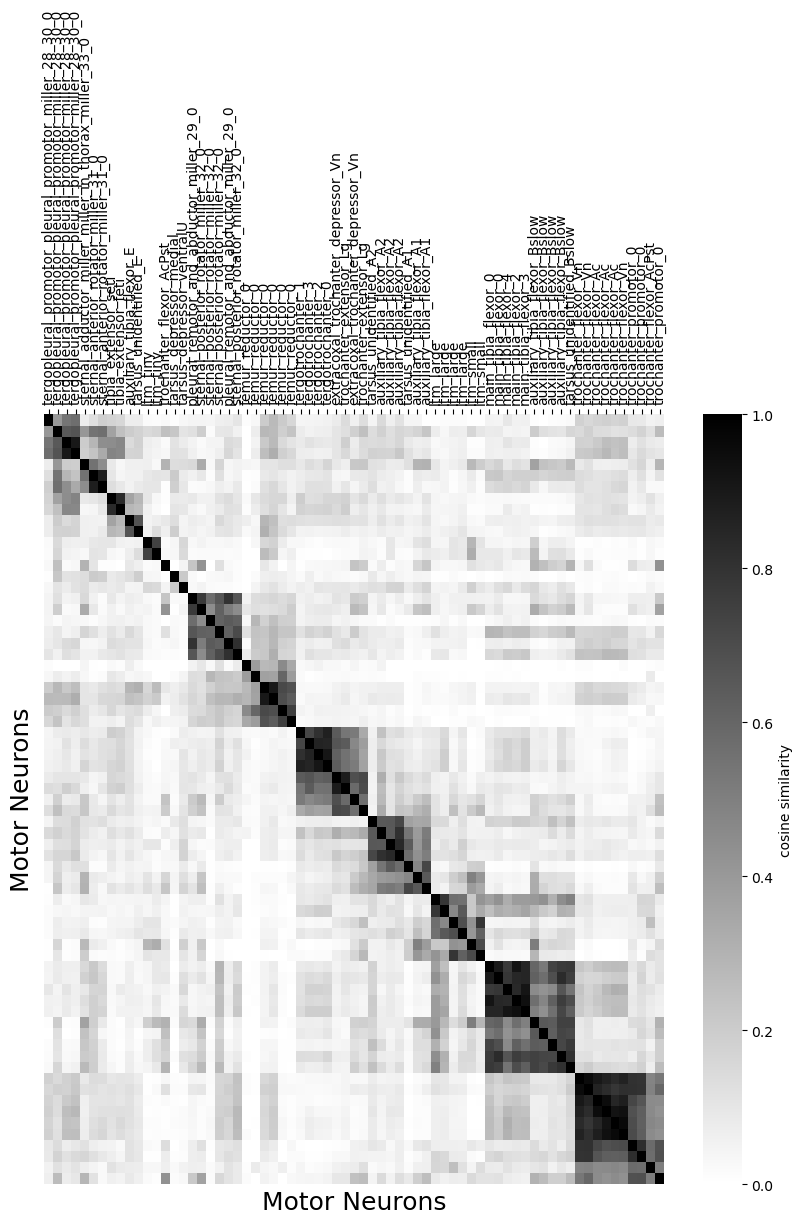

In [11]:
reordered_leg = pre_to_mn_df.copy()
reordered_leg = reordered_leg.iloc[:,clustered_order]

lbls = [ i + '_'+j for i,j in zip(reordered_leg.columns.get_level_values('muscle'),reordered_leg.columns.get_level_values('rank').astype('str'))]

sim_mat = cosine_similarity(reordered_leg.to_numpy().transpose())
fig = plt.figure(1, figsize = [10,10])
ax = sns.heatmap(sim_mat, xticklabels=lbls, yticklabels=[],cmap=cos_cmap)
ax.xaxis.set_ticks_position('top')
cbar = ax.collections[0].colorbar
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

# here set the labelsize by 20
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label = 'cosine similarity', size=10)
plt.xlabel('Motor Neurons', fontsize =18)
plt.ylabel('Motor Neurons', fontsize =18)
plt.yticks(fontsize = 10)
plt.xticks(fontsize = 10)
plt.show()
fig.savefig('./figpanels/hierarchical_clustering.svg',format='svg')

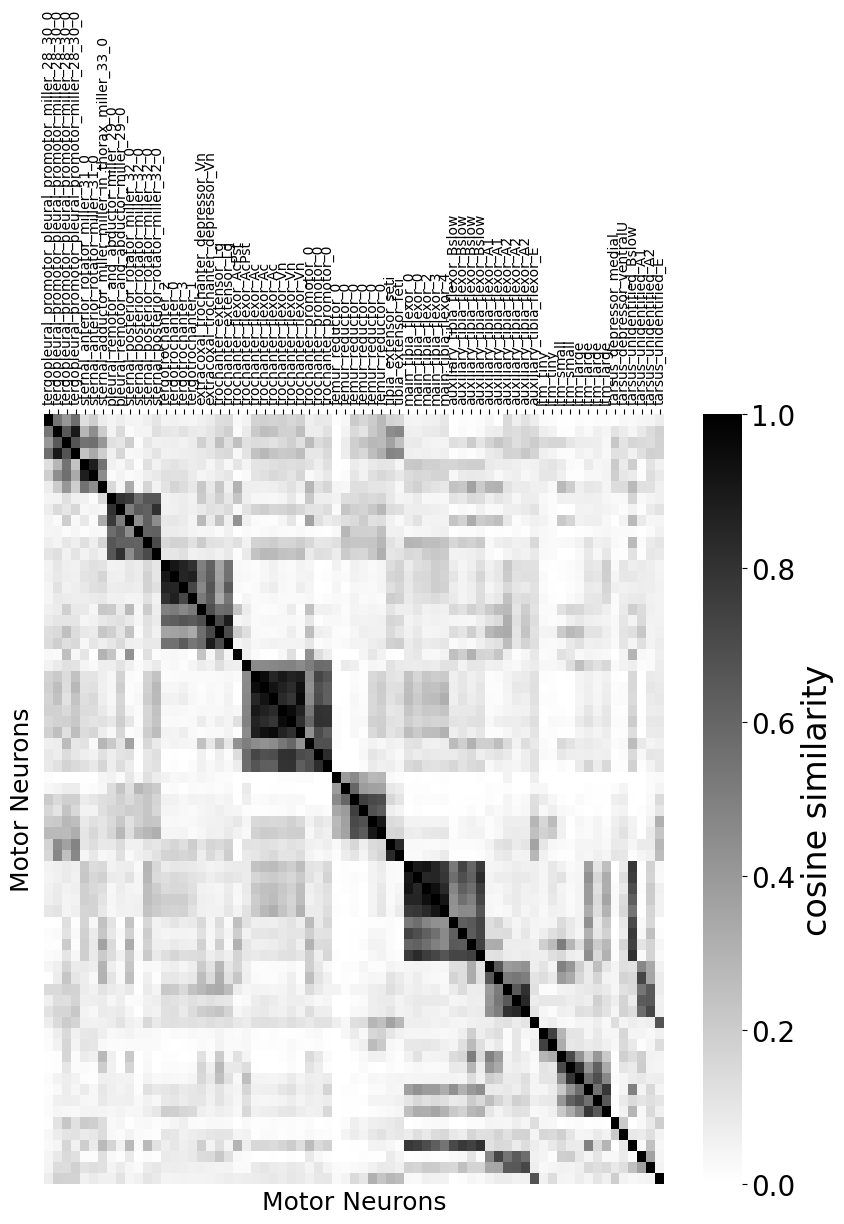

In [12]:
lbls = [ i + '_'+j for i,j in zip(pre_to_mn_df.columns.get_level_values('muscle'),pre_to_mn_df.columns.get_level_values('rank').astype('str'))]

sim_mat = cosine_similarity(pre_to_mn_df.to_numpy().transpose())
fig = plt.figure(1, figsize = [10,10])
ax = sns.heatmap(sim_mat, xticklabels=lbls, yticklabels=[],cmap=cos_cmap) # plt.get_cmap('Greys'))
ax.xaxis.set_ticks_position('top')
cbar = ax.collections[0].colorbar
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

# here set the labelsize by 20
cbar.ax.tick_params(labelsize=20)
cbar.set_label(label = 'cosine similarity', size=24)
plt.xlabel('Motor Neurons', fontsize =18)
plt.ylabel('Motor Neurons', fontsize =18)
plt.yticks(fontsize = 10)
plt.xticks(fontsize = 10)
plt.show()

fig.savefig('./figpanels/cos_sim_all_grayscale_sns_palette.svg',format='svg')

In [13]:
def clean_hmax(ax,xlab='',ylab=''):
    ax.xaxis.set_ticks_position('top')
    cbar = ax.collections[0].colorbar
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
    # here set the labelsize by 20
    cbar.ax.tick_params(labelsize=10)
    cbar.set_label(label = 'cosine similarity', size=10)
    plt.xlabel(xlab, fontsize =10)
    plt.ylabel(ylab, fontsize =10)
    plt.yticks(fontsize = 10)
    plt.xticks(fontsize = 10)
    plt.show()

# Cluster based on cosine similarity of single classes

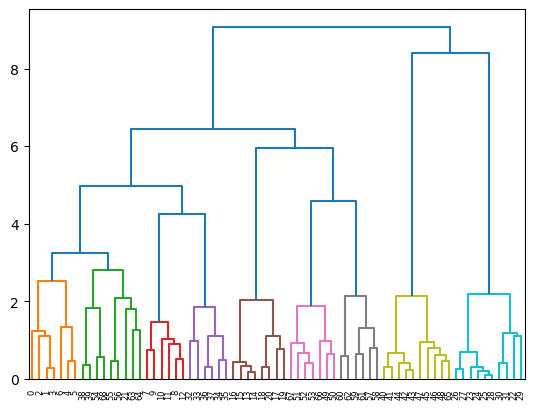

In [14]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import cluster 
from scipy.cluster.hierarchy import dendrogram

sim_mat = cosine_similarity(pre_to_mn_df.to_numpy().transpose())

# setting distance_threshold=0 ensures we compute the full tree.
# model = cluster.AgglomerativeClustering(n_clusters=9,compute_distances=True).fit(sim_mat)
model = cluster.AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(sim_mat)
model.distances_

counts = np.zeros(model.children_.shape[0])
n_samples = len(model.labels_)
for i, merge in enumerate(model.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack(
    [model.children_, model.distances_, counts]
).astype(float)

dend_dict = dendrogram(linkage_matrix,labels=np.arange(len(lbls)),color_threshold=3)
leaves_color_dict = {'all': dend_dict['leaves_color_list']}
ivl_dict = {'all': dend_dict['ivl']}


[ 1 39  5 10 14 13 15 12 24 25 28 42 43 44  4  6 22 33 45 30 21 32 46 47
  0  9 49 64 35 63 56 68 34 36 37 65  7 17  2 31 16 18 20 26 23 27 40 41
  3 11 38  8 48 54 50 66 51 53 19 29 55 57 58 60 59 61 62 52 67]
[ 1  3 64 18 20 34  6  9 11 35 17 15 13 14  2 16 60 62 57 61 58 59 31 24
 25 26 28 23 27  8  7 10 12  4  5 36 37  0 21 39 56 55 68 65 63 33 32 22
 29 54 49 50 38 19 66 53 45 30 67 51 52 41 42 43 44 48 40 46 47]
[52 53 17 50 15 13 14 19 66 16 51 18 20 47 65 59 60 22 30 58 61 62 46 48
 67 40 41 44 42 43 11  7  9 21 49 57 45 35 33 29 32 10 63  8 64 34 36 37
 26 27 12 23 24 25 28 54 68 39  0 38  6 31  2  1  3  4  5 55 56]
[44 40 41 42 43 45 65 47 48 61 60 62 49 59 57 58 51 53 46 30 67 16 15 13
 14 52 66 19 20 17 18  0 29 26 27 25 28 23 24  5  4 31  2 39  1  3 34 22
 33 38  8  9  7 12 10 11 36 37 54 68 55 56  6 50 63 64 35 21 32]
[ 7  9 10 11  8 12 36 37 34 35 32 33  2  0  1  3 38 39 63 54 68 15 16 13
 14 18 20 17 19 67 51 52 53 66 49 50 60 62 61 58 59 55 56 57 64  4  5  6
 21 26 27 

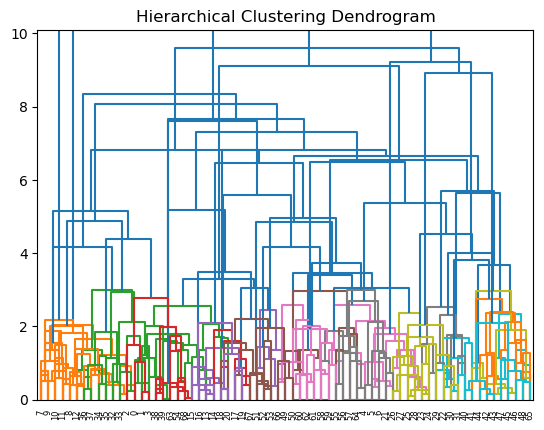

In [15]:

for cell_class in pre_to_mn_df.index.get_level_values('cell_class').unique():

    df = pre_to_mn_df.loc[cell_class].copy()

    lbls = [ i + '_'+j for i,j in zip(df.columns.get_level_values('muscle'),df.columns.get_level_values('rank').astype('str'))]

    sim_mat = cosine_similarity(df.to_numpy().transpose())

    # setting distance_threshold=0 ensures we compute the full tree.
    model = cluster.AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(sim_mat)

    plt.title("Hierarchical Clustering Dendrogram")

    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    dend_dict = dendrogram(linkage_matrix,labels=np.arange(len(lbls)),color_threshold=3)
    fig = plt.gcf()
    fig.savefig('./figpanels/cluster_dengrogram_leg_{}.svg'.format(cell_class),format='svg')

    # sorted order of indices found through clustering
    clustered_order_class = dend_dict['ivl']
    # plt.close()

    clustered_order_class = np.array(clustered_order_class).astype(int) # convert strings into integers
    print(clustered_order_class)

    leaves_color_dict[cell_class] = dend_dict['leaves_color_list']
    ivl_dict[cell_class] = dend_dict['ivl']
    

all
descending
sensory
ascending
intersegmental
local


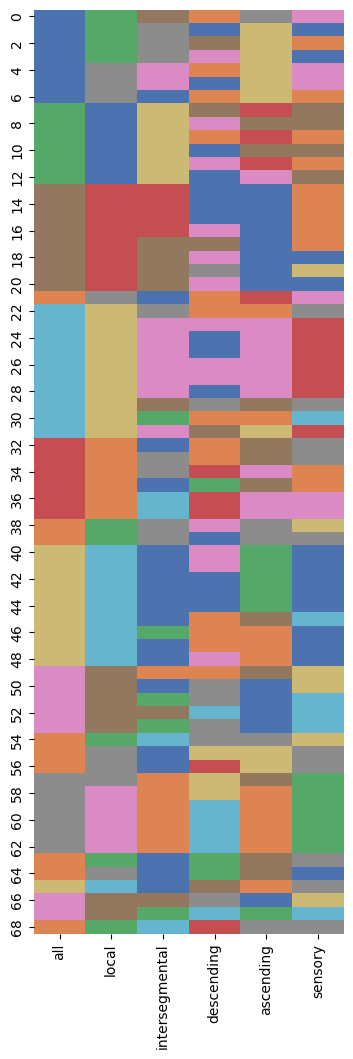

In [16]:
ivl_df = pd.DataFrame.from_dict(ivl_dict)
ivl_df
leaves_df = pd.DataFrame.from_dict(leaves_color_dict)
leaves_df


for col in ivl_dict.keys():
    print(col)
    idx = np.argsort(ivl_df.loc[:,col].values)
    leaves_df[col] = leaves_df[col].iloc[idx].values
    ivl_df[col] = ivl_df[col].iloc[idx].values


ivl_df.head()
leaves_df.head()
leaves_df = leaves_df.loc[:,['all','local','intersegmental','descending','ascending','sensory']]
leaves_df
int_map = {'C1': 1, 'C2': 2, 'C3': 3, 'C4': 4, 'C5': 5, 'C6':6, 'C7': 7,'C8': 8,'C9': 9}

df_colors = leaves_df.replace(int_map)

plt.figure(figsize=(4, 12))
ax = sns.heatmap(df_colors, fmt='',  cbar=False,cmap=sns.color_palette("deep"))
ax.get_figure().savefig('./figpanels/cluster_sns_palette.svg',format='svg')

all


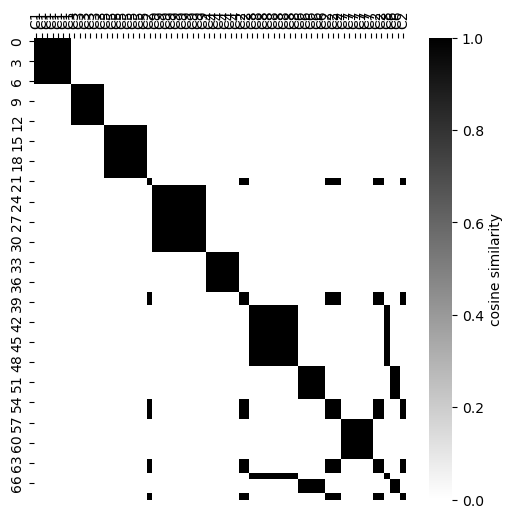

local


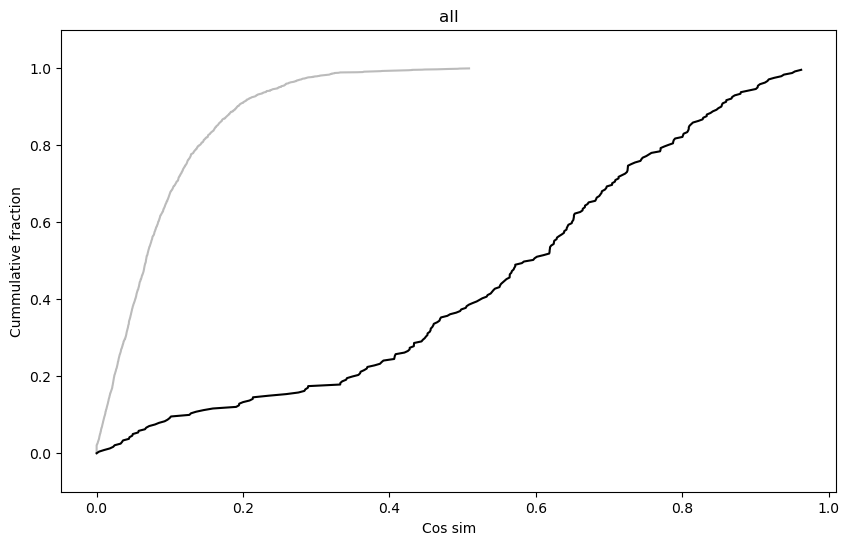

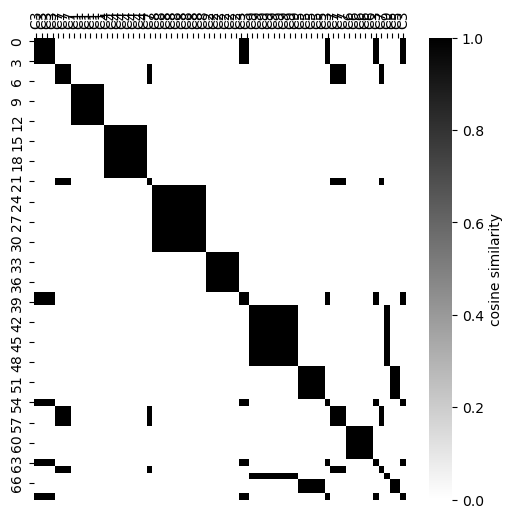

intersegmental


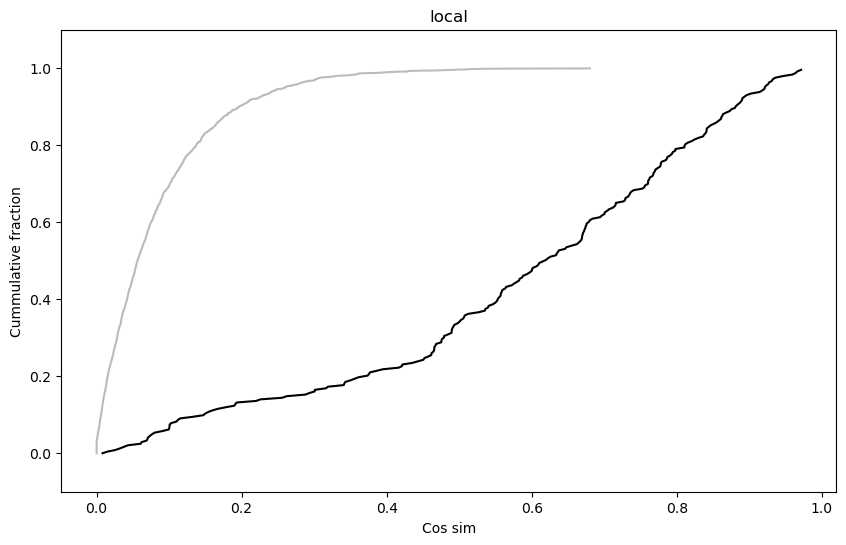

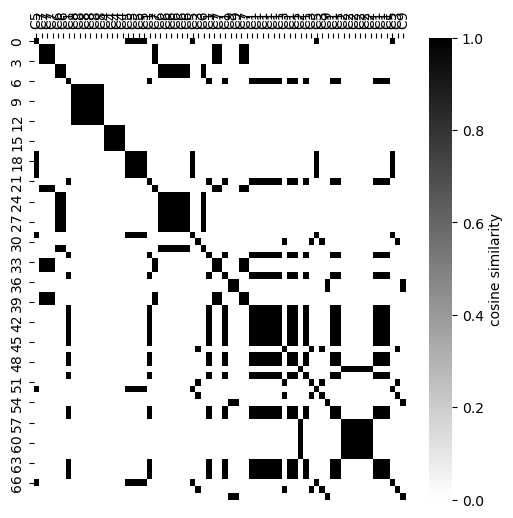

descending


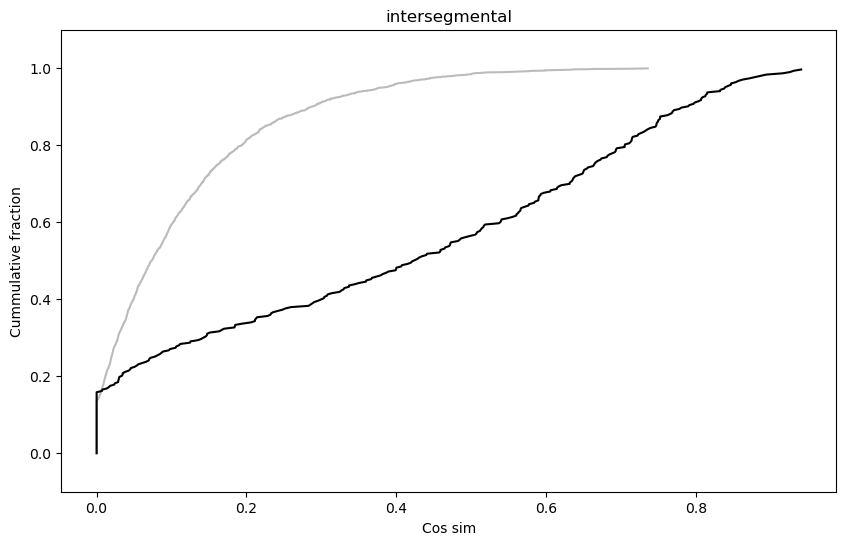

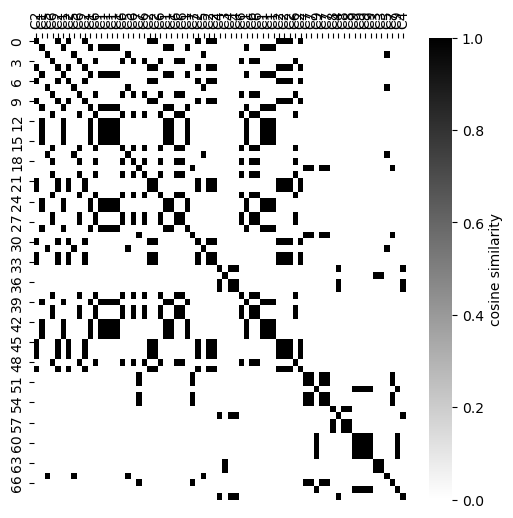

ascending


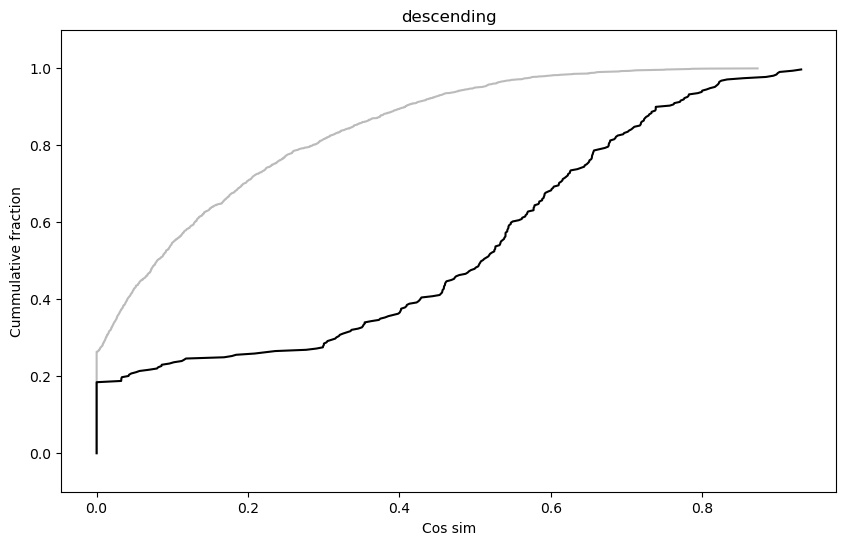

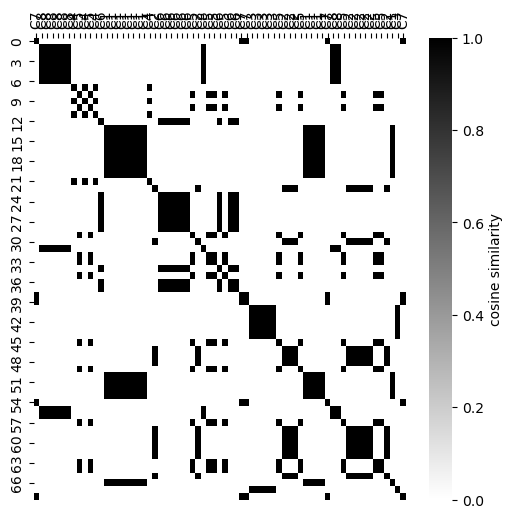

sensory


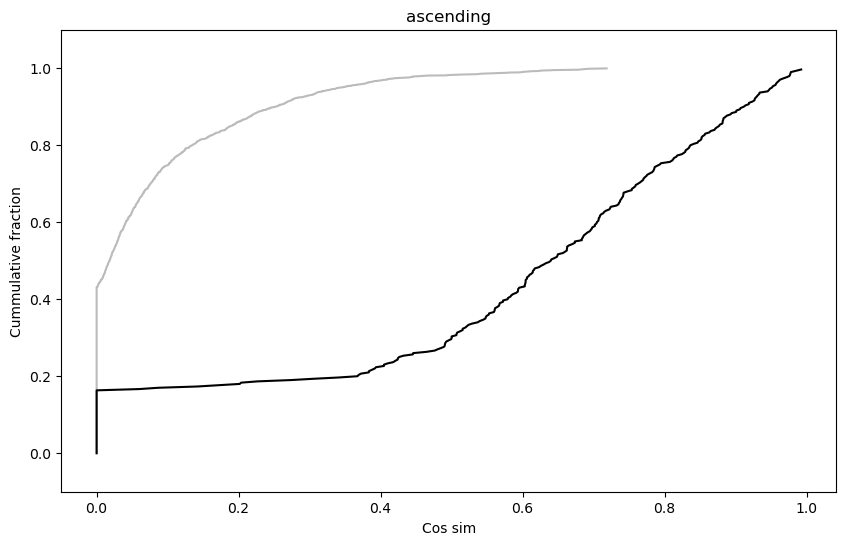

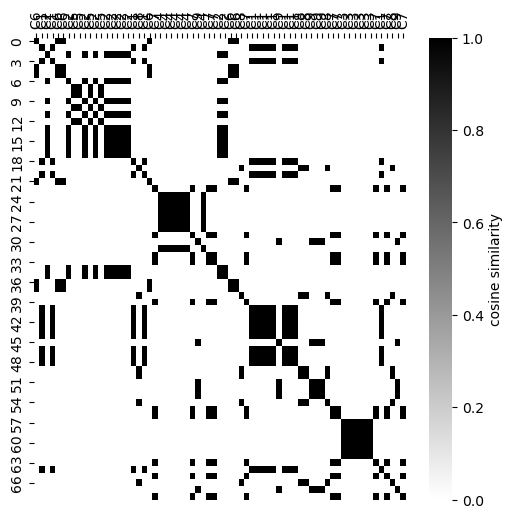

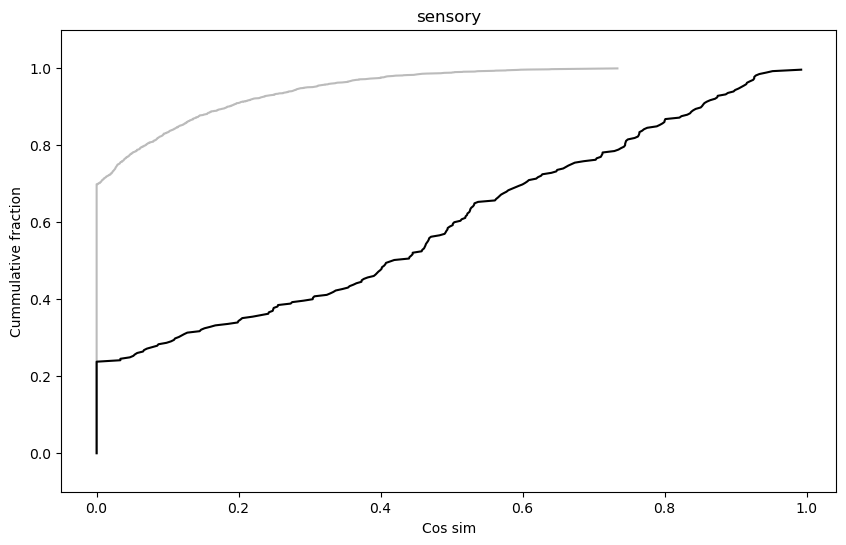

In [17]:
from scipy.stats import mannwhitneyu

mwu_val = []

for cell_class in df_colors.columns.to_list():
    print(cell_class)
    if cell_class=='all':
        df = pre_to_mn_df
    else:
        df = pre_to_mn_df.loc[cell_class]

    sim_mat = cosine_similarity(df.to_numpy().transpose())
    
    tril_mask = np.full((sim_mat.shape[0], sim_mat.shape[1]), True, dtype=bool)
    motor_pool_mask = np.full((sim_mat.shape[0], sim_mat.shape[1]), False, dtype=bool)
    i_index = np.full((sim_mat.shape[0], sim_mat.shape[1]), 0, dtype=int)
    j_index = np.full((sim_mat.shape[0], sim_mat.shape[1]), 0, dtype=int)
    for i in range(motor_pool_mask.shape[0]):
        for j in range(motor_pool_mask.shape[1]):
            motor_pool_mask[i,j] =(df_colors[cell_class].iloc[i]==df_colors[cell_class].iloc[j])
            i_index[i,j] = i
            j_index[i,j] = j

    fig = plt.figure(figsize = [6,6])
    ax = sns.heatmap(motor_pool_mask, xticklabels=leaves_df[cell_class].to_list(),cmap=cos_cmap)
    clean_hmax(ax)
    # fig = plt.figure(2, figsize = [6,6])
    # ax = sns.heatmap(np.tril(motor_pool_mask,-1), xticklabels=mn_mi_df.module.to_list(),cmap=cos_cmap)

    tril_mask = np.tril(tril_mask,-1)
    pool_arr = df_colors[cell_class].to_numpy()
    pool_arr = np.tile(pool_arr.reshape((-1,1)),len(pool_arr))

    sim_dict = {
        'pool':pool_arr.reshape(-1),
        'same_pool': motor_pool_mask.reshape(-1),
        'lower_tri':tril_mask.reshape(-1),
        'i_index':i_index.reshape(-1),
        'j_index':j_index.reshape(-1)
        }

    sim_compare_df = pd.DataFrame.from_dict(data = sim_dict,orient='columns')
    sim_compare_df['sim_vals'] = sim_mat.reshape(-1)
    # # get rid of upper triangle
    sim_compare_df = sim_compare_df.loc[sim_compare_df.lower_tri.to_numpy()]

    
    # def plot_shuf_cdf(x_unsorted,color = '#000000',ref_x=None, fn=None,fignum=4,title=None):
    fig = plt.figure(figsize=(10, 6))
    ax = plt.subplot()
    ax.set_ylim([-.1, 1.1])
    # ax.set_xlim([.945, .96])
    # ax.set_xlim([0, 1])
    ax.set_ylabel('Cummulative fraction')
    ax.set_xlabel('Cos sim')
    ax.set_title(cell_class)

    x_outofpool = sim_compare_df.loc[~sim_compare_df['same_pool'],'sim_vals']

    y = np.array(range(len(x_outofpool))).astype(float)/len(x_outofpool)
    ax.plot(sorted(x_outofpool),y,color='#BBBBBB')

    x_inpool = sim_compare_df.loc[sim_compare_df['same_pool'],'sim_vals']

    y = np.array(range(len(x_inpool))).astype(float)/len(x_inpool)
    ax.plot(sorted(x_inpool),y,color='#000000')

    mwu_out = mannwhitneyu(x_inpool,x_outofpool)
    mwu_val.append(mwu_out.statistic / (len(x_inpool)*len(x_outofpool)))

# mwu_val_max = mwu_val[-1]
# print(mwu_val_max)

# x_inpool_median = x_inpool.median()
# print(x_inpool_median)
# ax.plot(x_inpool_median*np.array([1,1]),np.array([0,1]),color='#0000FF')

# fig.savefig('./figpanels/cdf_sim_ta_assigned_pools_coxa_ab_asterix.svg',format='svg')

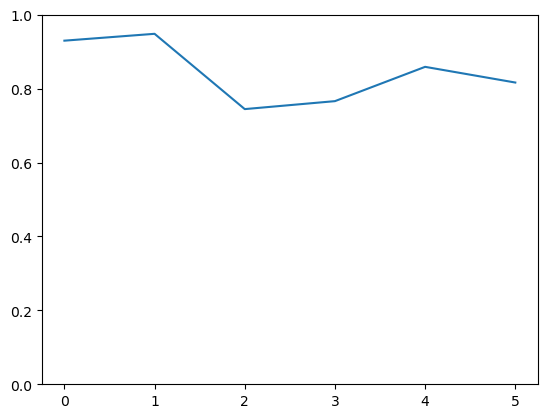

In [18]:
mwu_val

fig = plt.figure()
plt.plot(np.arange(len(mwu_val)),mwu_val)
plt.gca().set_ylim([0, 1])

fig.savefig('./figpanels/cdf_sim_auc_clustered_by_class.svg',format='svg')

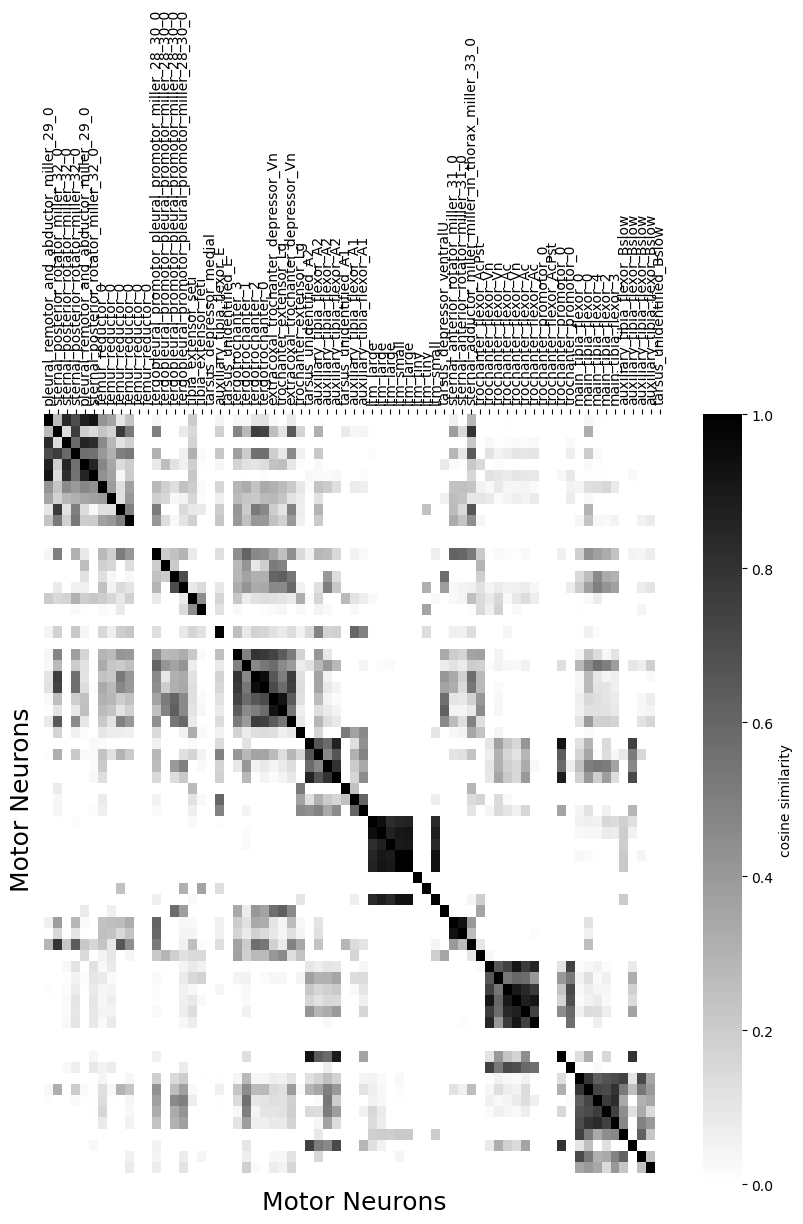

In [19]:
reordered_leg = df.iloc[:,clustered_order_class]

lbls = [ i + '_'+j for i,j in zip(reordered_leg.columns.get_level_values('muscle'),reordered_leg.columns.get_level_values('rank').astype('str'))]

sim_mat = cosine_similarity(reordered_leg.to_numpy().transpose())

fig = plt.figure(1, figsize = [10,10])
ax = sns.heatmap(sim_mat, xticklabels=lbls, yticklabels=[],cmap=cos_cmap)
ax.xaxis.set_ticks_position('top')
cbar = ax.collections[0].colorbar
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

# here set the labelsize by 20
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label = 'cosine similarity', size=10)
plt.xlabel('Motor Neurons', fontsize =18)
plt.ylabel('Motor Neurons', fontsize =18)
plt.yticks(fontsize = 10)
plt.xticks(fontsize = 10)
plt.show()
fig.savefig('./figpanels/hierarchical_clustering_{}.svg'.format(cell_class),format='svg')

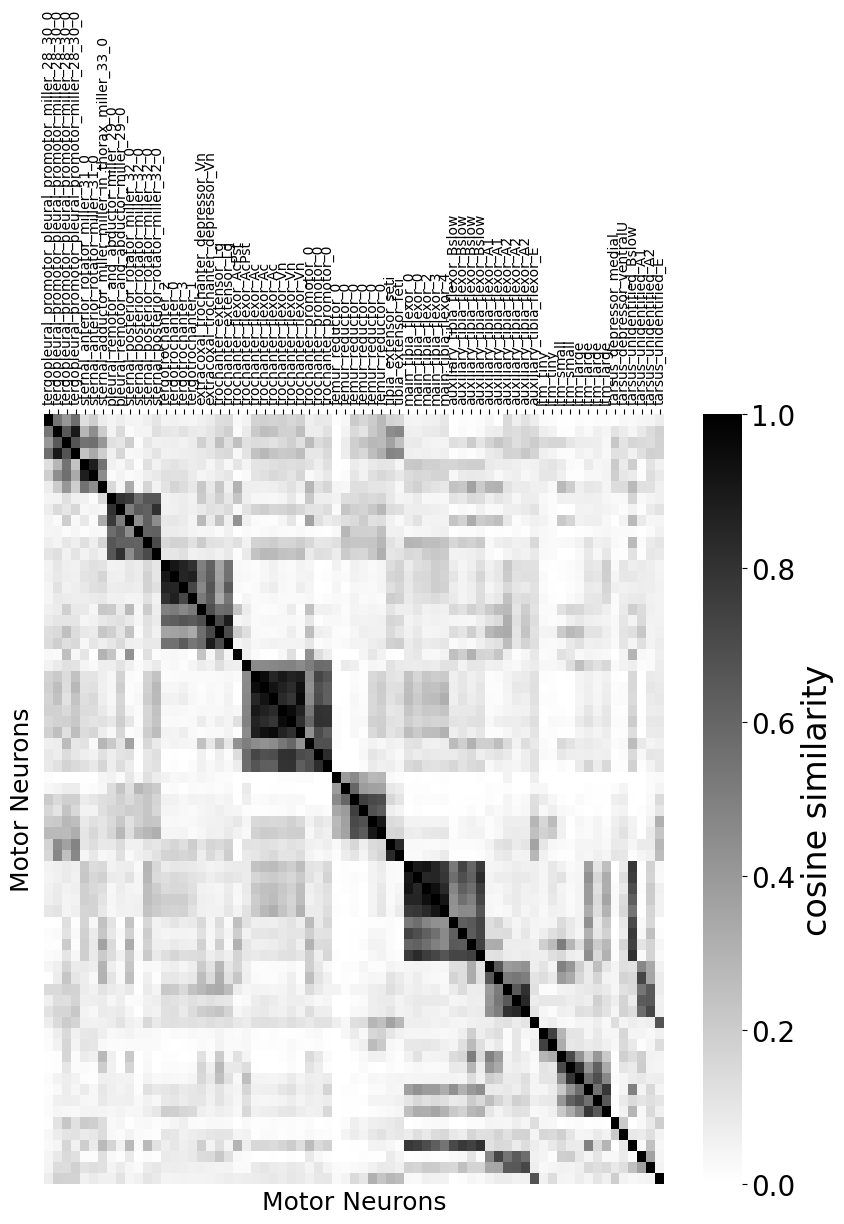

In [20]:
lbls = [ i + '_'+j for i,j in zip(pre_to_mn_df.columns.get_level_values('muscle'),pre_to_mn_df.columns.get_level_values('rank').astype('str'))]

sim_mat = cosine_similarity(pre_to_mn_df.to_numpy().transpose())
fig = plt.figure(1, figsize = [10,10])
ax = sns.heatmap(sim_mat, xticklabels=lbls, yticklabels=[],cmap=cos_cmap) # plt.get_cmap('Greys'))
ax.xaxis.set_ticks_position('top')
cbar = ax.collections[0].colorbar
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

# here set the labelsize by 20
cbar.ax.tick_params(labelsize=20)
cbar.set_label(label = 'cosine similarity', size=24)
plt.xlabel('Motor Neurons', fontsize =18)
plt.ylabel('Motor Neurons', fontsize =18)
plt.yticks(fontsize = 10)
plt.xticks(fontsize = 10)
plt.show()

fig.savefig('./figpanels/cos_sim_all_grayscale_sns_palette.svg',format='svg')

In [21]:
def clean_hmax(ax,xlab='',ylab=''):
    ax.xaxis.set_ticks_position('top')
    cbar = ax.collections[0].colorbar
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
    # here set the labelsize by 20
    cbar.ax.tick_params(labelsize=10)
    cbar.set_label(label = 'cosine similarity', size=10)
    plt.xlabel(xlab, fontsize =10)
    plt.ylabel(ylab, fontsize =10)
    plt.yticks(fontsize = 10)
    plt.xticks(fontsize = 10)
    plt.show()

## Bootstrap module structure


### Compare the masks for 1a +1b vs just 1

### ta_assigned_pools_coxa_ab

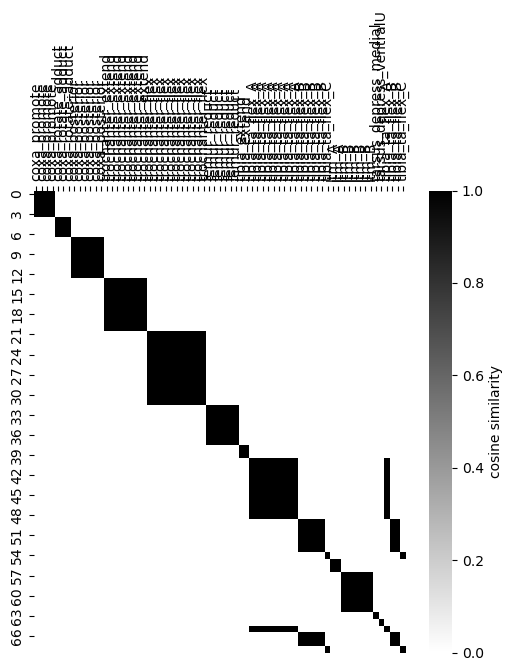

In [22]:
mn_mi_df = pre_to_mn_df.columns.to_frame()
mn_mi_df

# Ha! for this, put the tarsus neurons in the right pools
muscle_tuple_dict = utils.get_motor_pool_tuple_dict()
pool_keys = utils.ta_assigned_pools_coxa_ab()

for key in pool_keys:
    mn_tup = muscle_tuple_dict[key]
    mn_mi_df.loc[mn_tup,'preferred_pool'] = key

mn_mi_df.module = mn_mi_df.preferred_pool.astype("category")
mn_mi_df.preferred_pool = mn_mi_df.preferred_pool.cat.set_categories(pool_keys)
mn_mi_df

sim_mat = cosine_similarity(pre_to_mn_df.to_numpy().transpose())

tril_mask = np.full((sim_mat.shape[0], sim_mat.shape[1]), True, dtype=bool)
motor_pool_mask = np.full((sim_mat.shape[0], sim_mat.shape[1]), False, dtype=bool)
i_index = np.full((sim_mat.shape[0], sim_mat.shape[1]), 0, dtype=int)
j_index = np.full((sim_mat.shape[0], sim_mat.shape[1]), 0, dtype=int)
for i in range(motor_pool_mask.shape[0]):
    for j in range(motor_pool_mask.shape[1]):
        motor_pool_mask[i,j] =(mn_mi_df.iloc[i,:].preferred_pool==mn_mi_df.iloc[j,:].preferred_pool)
        i_index[i,j] = i
        j_index[i,j] = j

fig = plt.figure(1, figsize = [6,6])
ax = sns.heatmap(motor_pool_mask, xticklabels=mn_mi_df.preferred_pool.to_list(),cmap=cos_cmap)
clean_hmax(ax)
# fig = plt.figure(2, figsize = [6,6])
# ax = sns.heatmap(np.tril(motor_pool_mask,-1), xticklabels=mn_mi_df.preferred_pool.to_list(),cmap=cos_map)


In [23]:

tril_mask = np.tril(tril_mask,-1)

pool_arr = mn_mi_df.preferred_pool.to_numpy()
pool_arr = np.tile(pool_arr.reshape((-1,1)),len(pool_arr))

sim_dict = {
    'pool':pool_arr.reshape(-1),
    'same_pool': motor_pool_mask.reshape(-1),
    'lower_tri':tril_mask.reshape(-1),
    'i_index':i_index.reshape(-1),
    'j_index':j_index.reshape(-1)
    }

sim_compare_df = pd.DataFrame.from_dict(data = sim_dict,orient='columns')
sim_compare_df['sim_vals'] = sim_mat.reshape(-1)
# # get rid of upper triangle
sim_compare_df = sim_compare_df.loc[sim_compare_df.lower_tri.to_numpy()]


[0.9693743761909083]

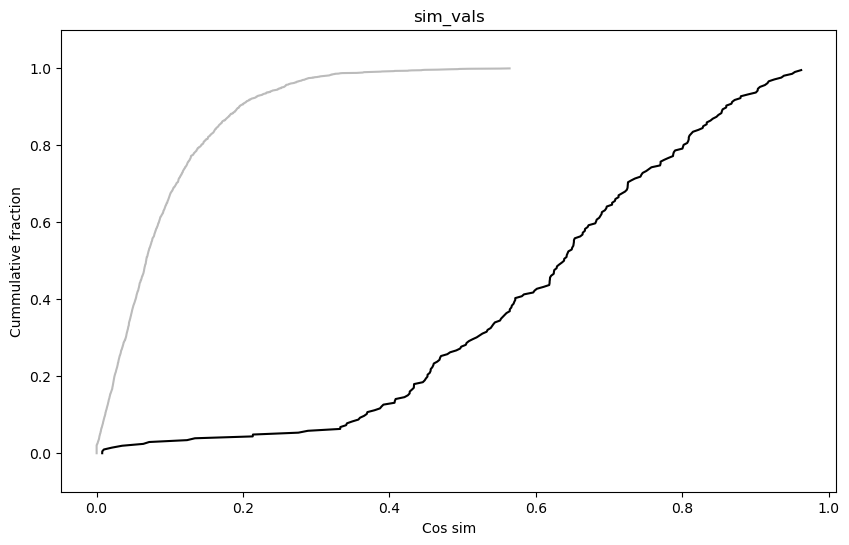

In [24]:


cnt = 0
ks_val = {}
mwu_val = []
dprime_a = []

cnt=cnt+1
idx = 'sim_vals'

# def plot_shuf_cdf(x_unsorted,color = '#000000',ref_x=None, fn=None,fignum=4,title=None):
fig = plt.figure(cnt, figsize=(10, 6))
ax = plt.subplot()
ax.set_ylim([-.1, 1.1])
# ax.set_xlim([.945, .96])
# ax.set_xlim([0, 1])
ax.set_ylabel('Cummulative fraction')
ax.set_xlabel('Cos sim')
ax.set_title(idx)

x_outofpool = sim_compare_df.loc[~sim_compare_df['same_pool'],idx]

y = np.array(range(len(x_outofpool))).astype(float)/len(x_outofpool)
ax.plot(sorted(x_outofpool),y,color='#BBBBBB')

x_inpool = sim_compare_df.loc[sim_compare_df['same_pool'],idx]

y = np.array(range(len(x_inpool))).astype(float)/len(x_inpool)
ax.plot(sorted(x_inpool),y,color='#000000')

fig.savefig('./figpanels/cdf_sim_ta_assigned_pools_coxa_ab.svg',format='svg')

ks_val = kstest(x_inpool,x_outofpool)
mwu_out = mannwhitneyu(x_inpool,x_outofpool)
mwu_val.append(mwu_out.statistic / (len(x_inpool)*len(x_outofpool)))
dprime_a.append(np.abs(np.mean(x_inpool)-np.mean(x_outofpool))/np.sqrt((np.var(x_inpool)+np.var(x_outofpool))/2))

# pct_below_actual = (x_unsorted<ref_x).sum() / len(x_unsorted)
# p=1-pct_below_actual
# ax.text(.94,.5,'p = {:.5f}'.format(p))

# if not fn is None:
#     fig.savefig('./figpanels/{}.eps'.format(fn),format='eps')

mwu_val

In [25]:
mwu_val

[0.9693743761909083]

### ta_assigned_pools

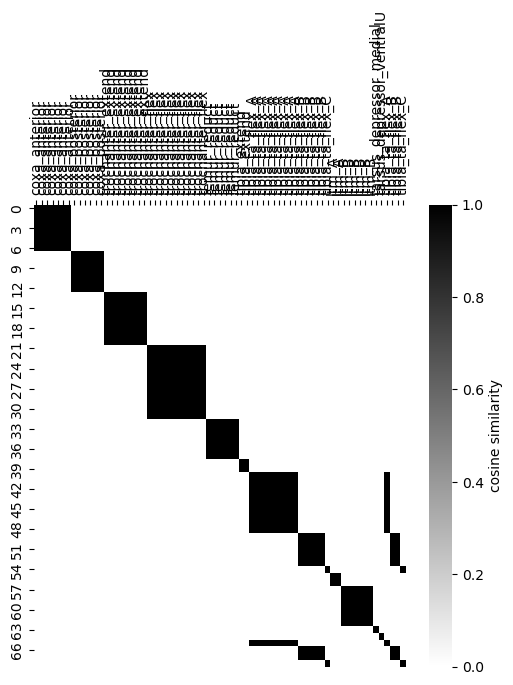

In [29]:
import utils
mn_mi_df = pre_to_mn_df.columns.to_frame()
mn_mi_df

# Ha! for this, put the tarsus neurons in the right pools
muscle_tuple_dict = utils.get_motor_pool_tuple_dict()
pool_keys = utils.ta_assigned_pools()

for key in pool_keys:
    mn_tup = muscle_tuple_dict[key]
    mn_mi_df.loc[mn_tup,'preferred_pool'] = key

mn_mi_df.preferred_pool = mn_mi_df.preferred_pool.astype("category")
mn_mi_df.preferred_pool = mn_mi_df.preferred_pool.cat.set_categories(pool_keys)
mn_mi_df

sim_mat = cosine_similarity(pre_to_mn_df.to_numpy().transpose())

tril_mask = np.full((sim_mat.shape[0], sim_mat.shape[1]), True, dtype=bool)
motor_pool_mask = np.full((sim_mat.shape[0], sim_mat.shape[1]), False, dtype=bool)
i_index = np.full((sim_mat.shape[0], sim_mat.shape[1]), 0, dtype=int)
j_index = np.full((sim_mat.shape[0], sim_mat.shape[1]), 0, dtype=int)
for i in range(motor_pool_mask.shape[0]):
    for j in range(motor_pool_mask.shape[1]):
        motor_pool_mask[i,j] =(mn_mi_df.iloc[i,:].preferred_pool==mn_mi_df.iloc[j,:].preferred_pool)
        i_index[i,j] = i
        j_index[i,j] = j

fig = plt.figure(1, figsize = [6,6])
ax = sns.heatmap(motor_pool_mask, xticklabels=mn_mi_df.module.to_list(),cmap=cos_cmap)
clean_hmax(ax)
# fig = plt.figure(2, figsize = [6,6])
# ax = sns.heatmap(np.tril(motor_pool_mask,-1), xticklabels=mn_mi_df.preferred_pool.to_list(),cmap=cos_cmap)


In [30]:

tril_mask = np.tril(tril_mask,-1)

pool_arr = mn_mi_df.preferred_pool.to_numpy()
pool_arr = np.tile(pool_arr.reshape((-1,1)),len(pool_arr))

sim_dict = {
    'pool':pool_arr.reshape(-1),
    'same_pool': motor_pool_mask.reshape(-1),
    'lower_tri':tril_mask.reshape(-1),
    'i_index':i_index.reshape(-1),
    'j_index':j_index.reshape(-1)
    }

sim_compare_df = pd.DataFrame.from_dict(data = sim_dict,orient='columns')
sim_compare_df['sim_vals'] = sim_mat.reshape(-1)
# # get rid of upper triangle
sim_compare_df = sim_compare_df.loc[sim_compare_df.lower_tri.to_numpy()]


[0.9664909119128096]

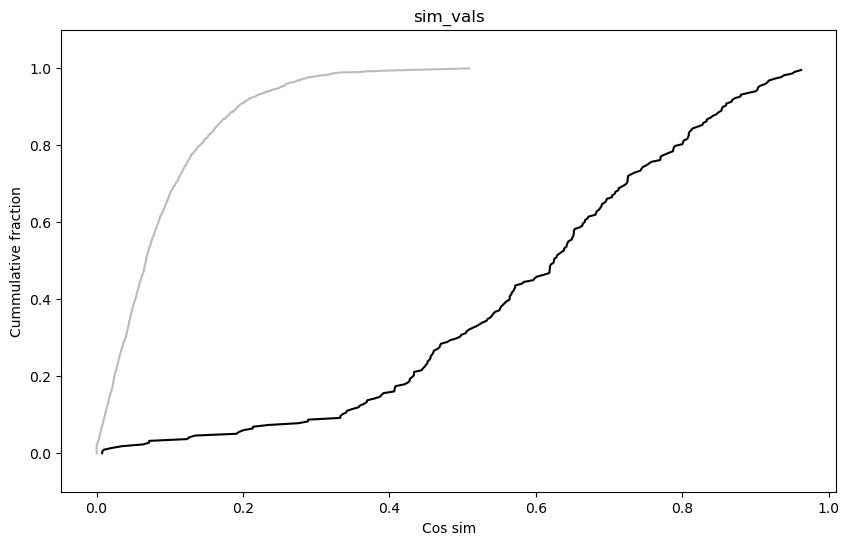

In [31]:


cnt = 0
ks_val = {}
mwu_val = []
dprime_a = []

cnt=cnt+1
idx = 'sim_vals'

# def plot_shuf_cdf(x_unsorted,color = '#000000',ref_x=None, fn=None,fignum=4,title=None):
fig = plt.figure(cnt, figsize=(10, 6))
ax = plt.subplot()
ax.set_ylim([-.1, 1.1])
# ax.set_xlim([.945, .96])
# ax.set_xlim([0, 1])
ax.set_ylabel('Cummulative fraction')
ax.set_xlabel('Cos sim')
ax.set_title(idx)

x_outofpool = sim_compare_df.loc[~sim_compare_df['same_pool'],idx]

y = np.array(range(len(x_outofpool))).astype(float)/len(x_outofpool)
ax.plot(sorted(x_outofpool),y,color='#BBBBBB')

x_inpool = sim_compare_df.loc[sim_compare_df['same_pool'],idx]

y = np.array(range(len(x_inpool))).astype(float)/len(x_inpool)
ax.plot(sorted(x_inpool),y,color='#000000')

fig.savefig('./figpanels/cdf_sim_ta_assigned_pools.svg',format='svg')

ks_val = kstest(x_inpool,x_outofpool)
mwu_out = mannwhitneyu(x_inpool,x_outofpool)
mwu_val.append(mwu_out.statistic / (len(x_inpool)*len(x_outofpool)))
dprime_a.append(np.abs(np.mean(x_inpool)-np.mean(x_outofpool))/np.sqrt((np.var(x_inpool)+np.var(x_outofpool))/2))

# pct_below_actual = (x_unsorted<ref_x).sum() / len(x_unsorted)
# p=1-pct_below_actual
# ax.text(.94,.5,'p = {:.5f}'.format(p))

# if not fn is None:
#     fig.savefig('./figpanels/{}.eps'.format(fn),format='eps')

mwu_val

### ta_assigned_pools_asterix (use this one)

In [32]:
mn_mi_df.iloc[21]

side                               L
nerve                      Accessory
segment                         coxa
function                        flex
muscle             trochanter_flexor
rank                           AcPst
segID             648518346477140752
module               trochanter_flex
preferred_pool       trochanter_flex
Name: (L, Accessory, coxa, flex, trochanter_flexor, AcPst, 648518346477140752, trochanter_flex), dtype: object

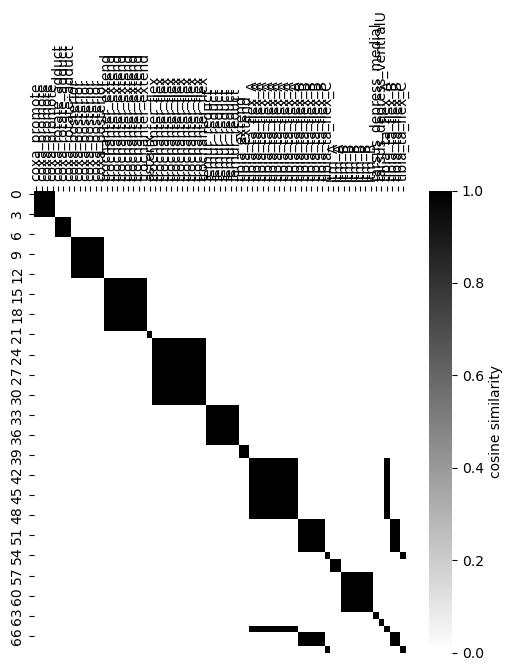

0.9973682961556716
0.643923737681696


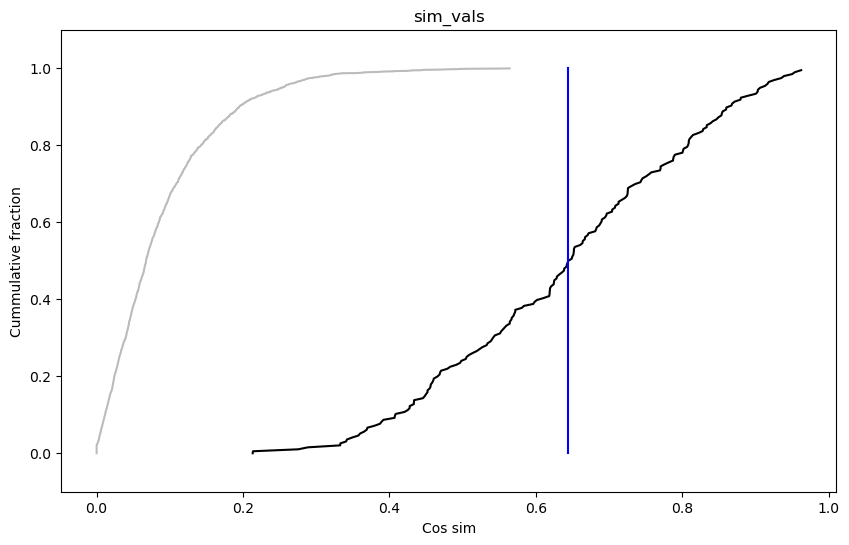

In [33]:
mn_mi_df = pre_to_mn_df.columns.to_frame()
mn_mi_df

# Ha! for this, put the tarsus neurons in the right pools
muscle_tuple_dict = utils.get_motor_pool_tuple_dict()
pool_keys = utils.ta_assigned_pools_coxa_ab()

for key in pool_keys:
    mn_tup = muscle_tuple_dict[key]
    mn_mi_df.loc[mn_tup,'preferred_pool'] = key

pool_keys.append('asterix')
mn_mi_df.loc[mn_mi_df.segID==mn_mi_df.iloc[21].segID,'preferred_pool'] = 'asterix'

mn_mi_df.preferred_pool = mn_mi_df.preferred_pool.astype("category")
mn_mi_df.preferred_pool = mn_mi_df.preferred_pool.cat.set_categories(pool_keys)
mn_mi_df.iloc[21]


sim_mat = cosine_similarity(pre_to_mn_df.to_numpy().transpose())

tril_mask = np.full((sim_mat.shape[0], sim_mat.shape[1]), True, dtype=bool)
motor_pool_mask = np.full((sim_mat.shape[0], sim_mat.shape[1]), False, dtype=bool)
i_index = np.full((sim_mat.shape[0], sim_mat.shape[1]), 0, dtype=int)
j_index = np.full((sim_mat.shape[0], sim_mat.shape[1]), 0, dtype=int)
for i in range(motor_pool_mask.shape[0]):
    for j in range(motor_pool_mask.shape[1]):
        motor_pool_mask[i,j] =(mn_mi_df.iloc[i,:].preferred_pool==mn_mi_df.iloc[j,:].preferred_pool)
        i_index[i,j] = i
        j_index[i,j] = j

fig = plt.figure(1, figsize = [6,6])
ax = sns.heatmap(motor_pool_mask, xticklabels=mn_mi_df.preferred_pool.to_list(),cmap=cos_cmap)
clean_hmax(ax)
# fig = plt.figure(2, figsize = [6,6])
# ax = sns.heatmap(np.tril(motor_pool_mask,-1), xticklabels=mn_mi_df.preferred_pool.to_list(),cmap=cos_cmap)


tril_mask = np.tril(tril_mask,-1)

pool_arr = mn_mi_df.preferred_pool.to_numpy()
pool_arr = np.tile(pool_arr.reshape((-1,1)),len(pool_arr))

sim_dict = {
    'pool':pool_arr.reshape(-1),
    'same_pool': motor_pool_mask.reshape(-1),
    'lower_tri':tril_mask.reshape(-1),
    'i_index':i_index.reshape(-1),
    'j_index':j_index.reshape(-1)
    }

sim_compare_df = pd.DataFrame.from_dict(data = sim_dict,orient='columns')
sim_compare_df['sim_vals'] = sim_mat.reshape(-1)
# # get rid of upper triangle
sim_compare_df = sim_compare_df.loc[sim_compare_df.lower_tri.to_numpy()]



cnt = 0
ks_val = {}
mwu_val = []
dprime_a = []

cnt=cnt+1
idx = 'sim_vals'

# def plot_shuf_cdf(x_unsorted,color = '#000000',ref_x=None, fn=None,fignum=4,title=None):
fig = plt.figure(cnt, figsize=(10, 6))
ax = plt.subplot()
ax.set_ylim([-.1, 1.1])
# ax.set_xlim([.945, .96])
# ax.set_xlim([0, 1])
ax.set_ylabel('Cummulative fraction')
ax.set_xlabel('Cos sim')
ax.set_title(idx)

x_outofpool = sim_compare_df.loc[~sim_compare_df['same_pool'],idx]

y = np.array(range(len(x_outofpool))).astype(float)/len(x_outofpool)
ax.plot(sorted(x_outofpool),y,color='#BBBBBB')

x_inpool = sim_compare_df.loc[sim_compare_df['same_pool'],idx]

y = np.array(range(len(x_inpool))).astype(float)/len(x_inpool)
ax.plot(sorted(x_inpool),y,color='#000000')



ks_val = kstest(x_inpool,x_outofpool)
mwu_out = mannwhitneyu(x_inpool,x_outofpool)
mwu_val.append(mwu_out.statistic / (len(x_inpool)*len(x_outofpool)))
dprime_a.append(np.abs(np.mean(x_inpool)-np.mean(x_outofpool))/np.sqrt((np.var(x_inpool)+np.var(x_outofpool))/2))

mwu_val_max = mwu_val[-1]
print(mwu_val_max)

x_inpool_median = x_inpool.median()
print(x_inpool_median)
ax.plot(x_inpool_median*np.array([1,1]),np.array([0,1]),color='#0000FF')

fig.savefig('./figpanels/cdf_sim_ta_assigned_pools_coxa_ab_asterix.svg',format='svg')




In [34]:
np.max(x_inpool.to_list()+x_outofpool.to_list())
np.median(x_inpool.to_list()+x_outofpool.to_list())

0.07442612781095304

# Remove each MN from its module and recompute mvu_val

Start with the arrangement where the trochanter flexor neuron is separated

In [35]:
# mn_mi_df.iloc[21]
# mn_mi_df = pre_to_mn_df.columns.to_frame()
# mn_mi_df

# # Ha! for this, put the tarsus neurons in the right pools
# muscle_tuple_dict = utils.get_motor_pool_tuple_dict()
# pool_keys = utils.ta_assigned_pools_coxa_ab()

# for key in pool_keys:
#     mn_tup = muscle_tuple_dict[key]
#     mn_mi_df.loc[mn_tup,'preferred_pool'] = key

# pool_keys.append('asterix')
# mn_mi_df.loc[mn_mi_df.segID==mn_mi_df.iloc[21].segID,'preferred_pool'] = 'asterix'

# pool_keys.append('hold_out')

# mn_mi_df.preferred_pool = mn_mi_df.preferred_pool.astype("category")
# mn_mi_df.preferred_pool = mn_mi_df.preferred_pool.cat.set_categories(pool_keys)
# import scipy

# mwu_val = []

# for sid in mn_mi_df.segID:
#     mn_mi_df_holdout = mn_mi_df.copy()
#     mn_mi_df_holdout.loc[mn_mi_df_holdout.segID==sid,'preferred_pool'] = 'hold_out'
#     mn_mi_df_holdout.preferred_pool = mn_mi_df_holdout.preferred_pool.astype("category")
#     mn_mi_df_holdout.preferred_pool = mn_mi_df_holdout.preferred_pool.cat.set_categories(pool_keys)

#     motor_pool_mask = np.full((sim_mat.shape[0], sim_mat.shape[1]), False, dtype=bool)
#     for i in range(motor_pool_mask.shape[0]):
#         for j in range(motor_pool_mask.shape[1]):
#             motor_pool_mask[i,j] =(mn_mi_df_holdout.iloc[i,:].preferred_pool==mn_mi_df_holdout.iloc[j,:].preferred_pool)

#     tril_mask = np.full((sim_mat.shape[0], sim_mat.shape[1]), True, dtype=bool)
#     tril_mask = np.tril(tril_mask,-1)
#     pool_arr = mn_mi_df_holdout.preferred_pool.to_numpy()
#     pool_arr = np.tile(pool_arr.reshape((-1,1)),len(pool_arr))
#     sim_dict = {
#         'pool':pool_arr.reshape(-1),
#         'same_pool': motor_pool_mask.reshape(-1),
#         'lower_tri':tril_mask.reshape(-1),
#         'i_index':i_index.reshape(-1),
#         'j_index':j_index.reshape(-1)
#         }

#     sim_compare_df = pd.DataFrame.from_dict(data = sim_dict,orient='columns')
#     sim_compare_df['sim_vals'] = sim_mat.reshape(-1)
#     # # get rid of upper triangle
#     sim_compare_df = sim_compare_df.loc[sim_compare_df.lower_tri.to_numpy()]

#     idx = 'sim_vals'
#     x_outofpool = sim_compare_df.loc[~sim_compare_df['same_pool'],idx]
#     x_inpool = sim_compare_df.loc[sim_compare_df['same_pool'],idx]
#     mwu_out = scipy.stats.mannwhitneyu(x_inpool,x_outofpool)
#     mwu_val.append(mwu_out.statistic / (len(x_inpool)*len(x_outofpool)))

#     print('Hold out MN {}: {} vs. {}'.format(sid,mwu_val_max,mwu_out.statistic / (len(x_inpool)*len(x_outofpool))))

# # add the mwu_val to the dataframe
# mn_mi_df_holdout['mwu_holdout_auc'] = mwu_val

# # plot the MWU AUC curves
# fig = plt.figure(cnt, figsize=(10, 6))
# ax = plt.subplot()
# ax.set_ylim([.992, 0.999])
# ax.set_ylabel('MWU AUC value')
# ax.set_xlabel('MN')
# ax.set_title('Hold out each MN')

# ax.plot([0,68],[mwu_val_max,mwu_val_max],color='#000000',linestyle='dashed')
# ax.plot(range(len(mwu_val)),np.array(mwu_val),color='#BBBBBB')
# fig.savefig('./figpanels/hold_out_leg_MNs.svg',format='svg')

# print(mwu_val_max)
# mn_mi_df_holdout.loc[mn_mi_df_holdout.mwu_holdout_auc>mwu_val_max,:]
# mn_mi_df_holdout.loc[(mn_mi_df_holdout.mwu_holdout_auc>=mwu_val_max) & (mn_mi_df_holdout.preferred_pool=='femur_reduct'),:]
# pre_to_mn_df.loc[:,(mn_mi_df_holdout.mwu_holdout_auc>=mwu_val_max) & (mn_mi_df_holdout.preferred_pool=='ltm_nondipa')].sum()

# Finally, assign small ltm neuron to other modules

Start with the arrangement where the trochanter flexor neuron is separated, and the small ltm neuron is separated.

In [36]:
# mn_mi_df = pre_to_mn_df.columns.to_frame()

# muscle_tuple_dict = utils.get_motor_pool_tuple_dict()
# pool_keys = utils.ta_assigned_pools_coxa_ab()

# for key in pool_keys:
#     mn_tup = muscle_tuple_dict[key]
#     mn_mi_df.loc[mn_tup,'preferred_pool'] = key

# pool_keys.append('asterix')
# mn_mi_df.loc[mn_mi_df.segID==mn_mi_df.iloc[21].segID,'preferred_pool'] = 'asterix'

# pool_keys.append('ltm_holdout')
# mn_mi_df.loc[mn_mi_df.segID==648518346488943373,'preferred_pool'] = 'ltm_holdout'

# mn_mi_df.preferred_pool = mn_mi_df.preferred_pool.astype("category")
# mn_mi_df.preferred_pool = mn_mi_df.preferred_pool.cat.set_categories(pool_keys)
# import scipy

# mwu_val = []

# for pk in pool_keys:
#     mn_mi_df_putin = mn_mi_df.copy()
#     mn_mi_df_putin.loc[mn_mi_df_putin.preferred_pool=='ltm_holdout','preferred_pool'] = pk
#     mn_mi_df_putin.preferred_pool = mn_mi_df_putin.preferred_pool.astype("category")
#     mn_mi_df_putin.preferred_pool = mn_mi_df_putin.preferred_pool.cat.set_categories(pool_keys)

#     motor_pool_mask = np.full((sim_mat.shape[0], sim_mat.shape[1]), False, dtype=bool)
#     for i in range(motor_pool_mask.shape[0]):
#         for j in range(motor_pool_mask.shape[1]):
#             motor_pool_mask[i,j] =(mn_mi_df_putin.iloc[i,:].preferred_pool==mn_mi_df_putin.iloc[j,:].preferred_pool)

#     tril_mask = np.full((sim_mat.shape[0], sim_mat.shape[1]), True, dtype=bool)
#     tril_mask = np.tril(tril_mask,-1)
#     pool_arr = mn_mi_df_putin.preferred_pool.to_numpy()
#     pool_arr = np.tile(pool_arr.reshape((-1,1)),len(pool_arr))
#     sim_dict = {
#         'pool':pool_arr.reshape(-1),
#         'same_pool': motor_pool_mask.reshape(-1),
#         'lower_tri':tril_mask.reshape(-1),
#         'i_index':i_index.reshape(-1),
#         'j_index':j_index.reshape(-1)
#         }

#     sim_compare_df = pd.DataFrame.from_dict(data = sim_dict,orient='columns')
#     sim_compare_df['sim_vals'] = sim_mat.reshape(-1)
#     # # get rid of upper triangle
#     sim_compare_df = sim_compare_df.loc[sim_compare_df.lower_tri.to_numpy()]

#     idx = 'sim_vals'
#     x_outofpool = sim_compare_df.loc[~sim_compare_df['same_pool'],idx]
#     x_inpool = sim_compare_df.loc[sim_compare_df['same_pool'],idx]
#     mwu_out = scipy.stats.mannwhitneyu(x_inpool,x_outofpool)
#     mwu_val.append(mwu_out.statistic / (len(x_inpool)*len(x_outofpool)))

#     print('Put MN in {}: {} vs. {}'.format(pk,mwu_val_max,mwu_out.statistic / (len(x_inpool)*len(x_outofpool))))

# # add the mwu_val to the dataframe
# # mn_mi_df_putin['mwu_holdout_auc'] = mwu_val


# # plot the MWU AUC curves
# fig = plt.figure(cnt, figsize=(10, 6))
# ax = plt.subplot()
# ax.set_ylim([.95, 0.999])
# ax.set_ylabel('MWU AUC value')
# ax.set_xlabel('MN')
# ax.set_title('put the ltm in each pool')
# # ax.xaxis.set_ticks_position('top')
# ax.set_xticks(range(len(mwu_val)))
# ax.set_xticklabels(pool_keys,rotation = 90)


# ax.plot([0,len(mwu_val)],[mwu_val_max,mwu_val_max],color='#000000',linestyle='dashed')
# ax.plot(range(len(mwu_val)),np.array(mwu_val),color='#BBBBBB')

In [37]:
# mwu_val_max

To summarize: 
Holding out the asterix trochanter flexor increases the mvu_val.
Then, holding out either the small reductor or the small ltm increases further, a little.
Finally, putting the small ltm with the dip-alpha ltm looks a little better but not as good as putting it in its own pool.

# How does shuffling affect clustering?
First simply shuffle all values. How does this affect the cosine similarity?

## Bootstrap the cosine similarity metrics
There are a number of ways to make these comparisons. We can consider both which weights are shuffled, and what the metric of comparison is. 

Metrics
1. Compute the average similarity within the pool, project each neuron onto the average. What I have done so far, gives a single number.
2. Compute the pairwise similarity between each neuron. Then what? Compute mean and variance?

Shuffling
1. I could shuffle only the weights that a particular preMN makes onto the pool, i.e. just in the small square. That preserves density but mixes up propotionality.
2. I could shuffle the weights of all the connections that a hemilineage makes within the preferred pool. That preserve density, but shuffles the propotionality a bit more. 
3. I could shuffle all of the weights of a given premotor neuron, across pools. That preserves neither density nor proportionality. 
4. I could shuffle the weights of all the connection from a hemilineages onto the pools, including preMNs that don't prefer the pool. That also preserves neither density nor propotionality.
Start with local neurons onto extensors and flexors

## Bootstrap functions

In [38]:
def mix_up_under_mask(mat_in,mask=None,rng=None):
    if mask is None:
        mask = np.full(mat_in.shape, True)
    if rng is None:
        rng = np.random.default_rng()
    
    mat_out = mat_in.copy()
    mat_out[mask] = rng.permutation(mat_in[mask])
    return mat_out


def choice_under_mask(mat_in,mask=None,rng=None,replace=True):
    if mask is None:
        mask = np.full(mat_in.shape, True)
    if rng is None:
        rng = np.random.default_rng()
    
    mat_out = mat_in.copy()
    mat_out[mask] = rng.choice(mat_in[mask],size=mat_in[mask].size, replace=replace)
    return mat_out

def mix_up_columns_under_mask(mat_in,mask=None,rng=None,permute = True):
    if mask is None:
        mask = np.full(mat_in.shape, True)
    if rng is None:
        rng = np.random.default_rng()
    
    mat_out = mat_in.copy()
    for r in range(mask.shape[0]):
        if mask[r,0]:
            if permute:
                mat_out[r,:] = mat_out[r,rng.permutation(mask.shape[1])]
            else:
                mat_out[r,:] = mat_out[r,rng.integers(0,high=mask.shape[1],size=5)]
            
    return mat_out

def mix_up_rows_under_mask(mat_in,mask=None,rng=None,permute = True):
    if mask is None:
        mask = np.full(mat_in.shape, True)
    if rng is None:
        rng = np.random.default_rng()
    
    mat_out = mat_in.copy()
    for c in range(mask.shape[1]):
        if mask[0,c]:
            if permute:
                mat_out[:,c] = mat_out[rng.permutation(mask.shape[0]),c]
            else:
                mat_out[:,c] = mat_out[rng.integers(0,high=mask.shape[0],size=5),c]
            
    return mat_out

# Shuffle everything, keep the pools

In [39]:
mn_mi_df.iloc[21]
mn_mi_df = pre_to_mn_df.columns.to_frame()
mn_mi_df

# Ha! for this, put the tarsus neurons in the right pools
muscle_tuple_dict = utils.get_motor_pool_tuple_dict()
pool_keys = utils.ta_assigned_pools_coxa_ab()

for key in pool_keys:
    mn_tup = muscle_tuple_dict[key]
    mn_mi_df.loc[mn_tup,'preferred_pool'] = key

pool_keys.append('asterix')
mn_mi_df.loc[mn_mi_df.segID==mn_mi_df.iloc[21].segID,'preferred_pool'] = 'asterix'

pool_keys.append('hold_out')

mn_mi_df.preferred_pool = mn_mi_df.preferred_pool.astype("category")
mn_mi_df.preferred_pool = mn_mi_df.preferred_pool.cat.set_categories(pool_keys)

mwu_val = []

rng = np.random.default_rng()

cos_sim_mean_dict = {}
mixups_dict = {}
mixups_means_dict = {}

motor_pool_mask = np.full((len(mn_mi_df), len(mn_mi_df)), False, dtype=bool)
for i in range(motor_pool_mask.shape[0]):
    for j in range(motor_pool_mask.shape[1]):
        motor_pool_mask[i,j] =(mn_mi_df.iloc[i,:].preferred_pool==mn_mi_df.iloc[j,:].preferred_pool)


tril_mask = np.full((sim_mat.shape[0], sim_mat.shape[1]), True, dtype=bool)
tril_mask = np.tril(tril_mask,-1)
pool_arr = mn_mi_df.preferred_pool.to_numpy()
pool_arr = np.tile(pool_arr.reshape((-1,1)),len(pool_arr))
sim_dict = {
    'pool':pool_arr.reshape(-1),
    'same_pool': motor_pool_mask.reshape(-1),
    'lower_tri':tril_mask.reshape(-1),
    'i_index':i_index.reshape(-1),
    'j_index':j_index.reshape(-1)
    }

sim_compare_df = pd.DataFrame.from_dict(data = sim_dict,orient='columns')
sim_compare_df['sim_vals'] = sim_mat.reshape(-1)
# # get rid of upper triangle
sim_compare_lt_df = sim_compare_df.loc[sim_compare_df.lower_tri.to_numpy()]
# print('Put MN in {}: {} vs. {}'.format(pk,mwu_val_max,mwu_out.statistic / (len(x_inpool)*len(x_outofpool))))

mwu_val =[]
x_inpool_total = []
x_total = []

N=1000
for r in range(N):
    mixupmat = pre_to_mn_df.to_numpy().copy()   
    mixup = mix_up_under_mask(mixupmat,mask=None,rng=rng)
    sim_mat = cosine_similarity(mixup.transpose())
    
    sim_compare_df['sim_vals'] = sim_mat.reshape(-1)
    sim_compare_lt_df = sim_compare_df.loc[sim_compare_df.lower_tri.to_numpy()]
    idx = 'sim_vals'
    x_outofpool = sim_compare_lt_df.loc[~sim_compare_lt_df['same_pool'],idx]
    x_inpool = sim_compare_lt_df.loc[sim_compare_lt_df['same_pool'],idx]
    mwu_out = mannwhitneyu(x_inpool,x_outofpool)
    mwu_val.append(mwu_out.statistic / (len(x_inpool)*len(x_outofpool)))
    x_inpool_total=x_inpool_total+x_inpool.to_list()
    # x_total=x_total+x_inpool.to_list() + x_outofpool.to_list()


In [40]:

# np.max(x_total)

In [41]:
np.median(x_total)

c:\Users\tony\miniconda3\envs\fanc_py39_1023\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\tony\miniconda3\envs\fanc_py39_1023\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

How large can the cosine similarity be, in the defined pools, if the adj mat is shuffled?

0.022152626093270962

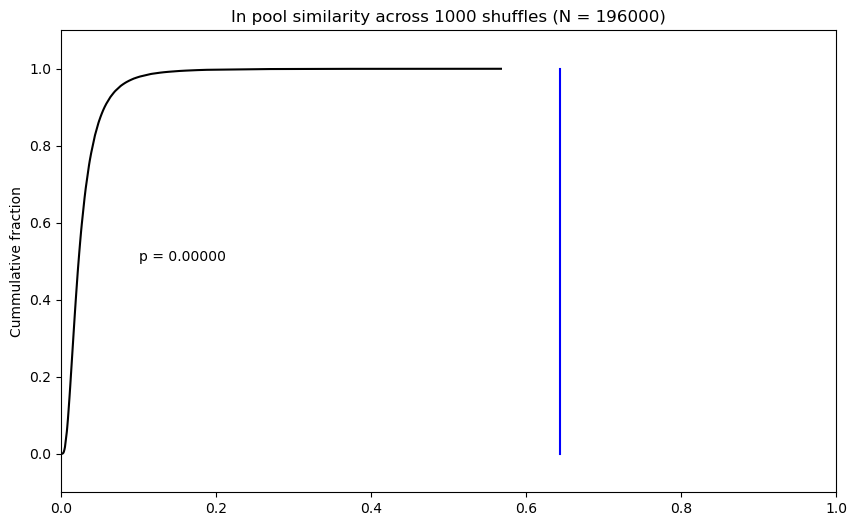

In [42]:
plot_shuf_cdf(x_inpool_total,color = '#000000',ref_x=x_inpool_median, fn='cdf_inpool_sim_cr_shuffled',fignum=4,title='In pool similarity across {} shuffles (N = {})'.format(N,len(x_inpool_total)))
np.median(x_inpool_total)

The within pool similarity is almost always less than .1, whereas the median in pool similarity is actually 0.64

How large can the auc be when comparing within pool distributions vs. across pool distributions?

<AxesSubplot: title={'center': 'MWU AUC (N = 1000 shuffles)'}, ylabel='Cummulative fraction'>

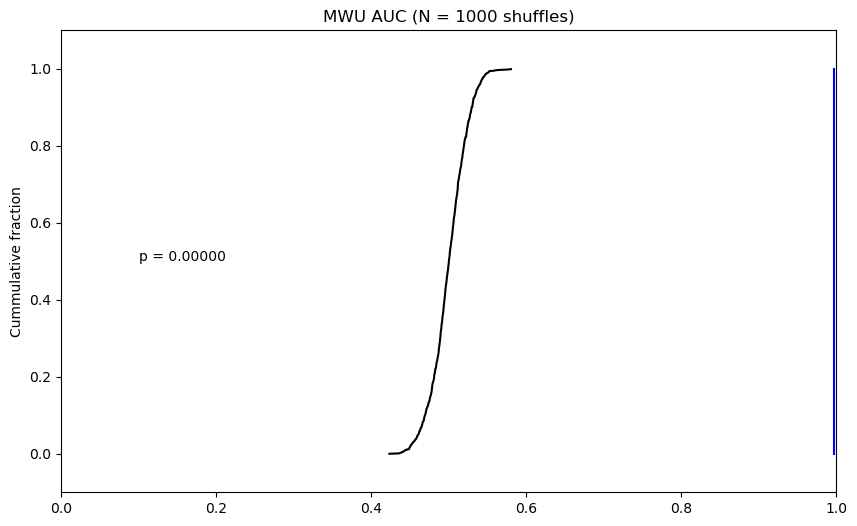

In [43]:
plot_shuf_cdf(mwu_val,color = '#000000',ref_x=mwu_val_max, fn='cdf_sim_auc_cr_shuffled',fignum=4,title='MWU AUC (N = {} shuffles)'.format(N))


In [44]:
np.min(mwu_val)

0.42323682961556713

So, the in pool similarity is always small, and within pool vs. across pool distributions are always similar.

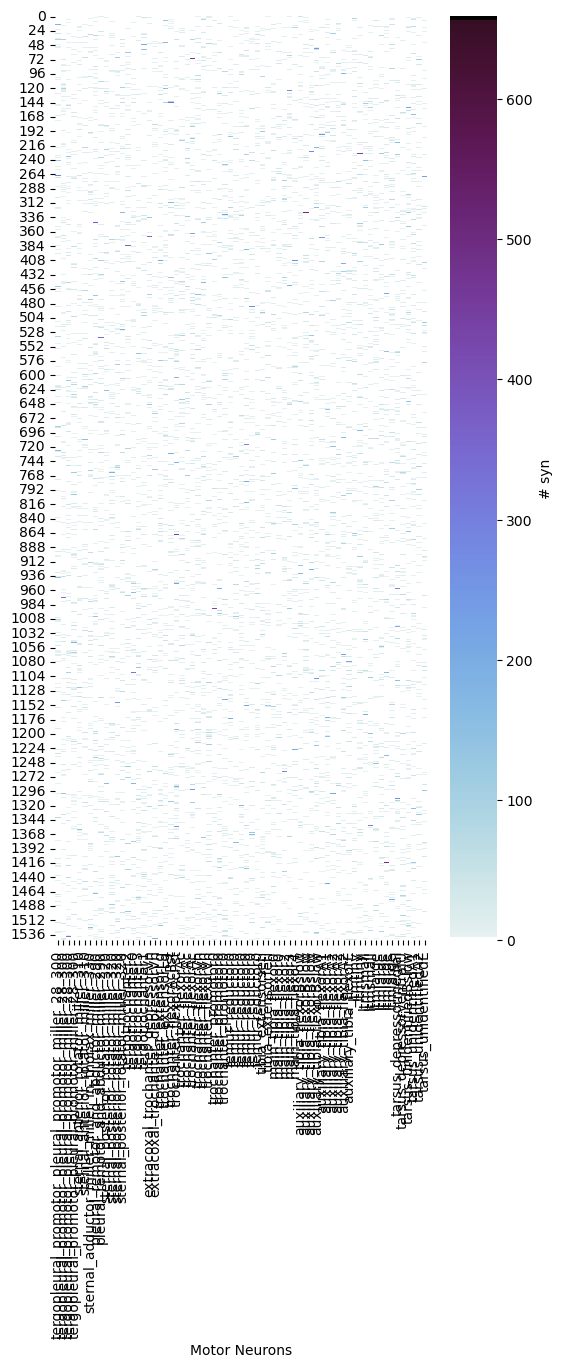

In [45]:
plot_conn_map(mixup,pre_to_mn_df)

# Shuffle columns, keep the pools

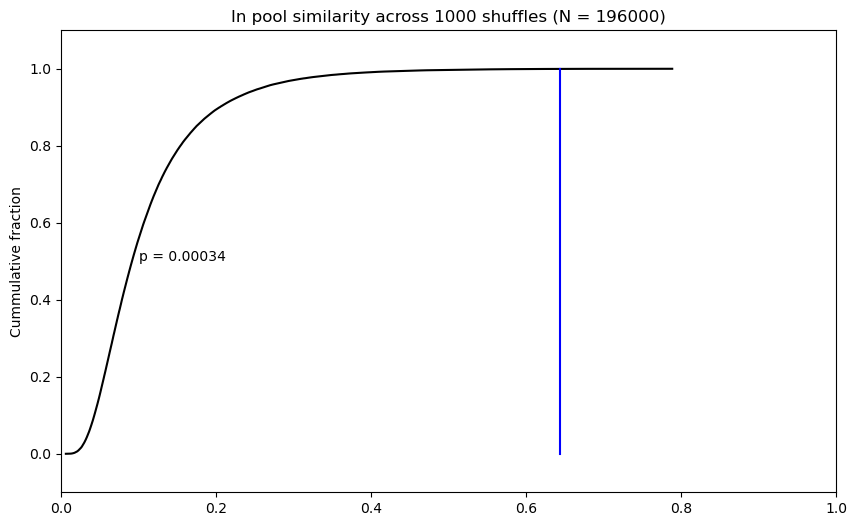

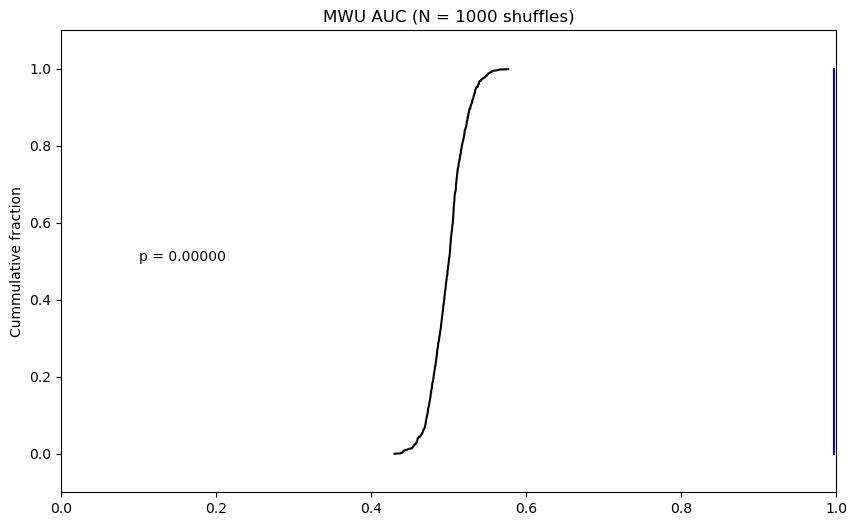

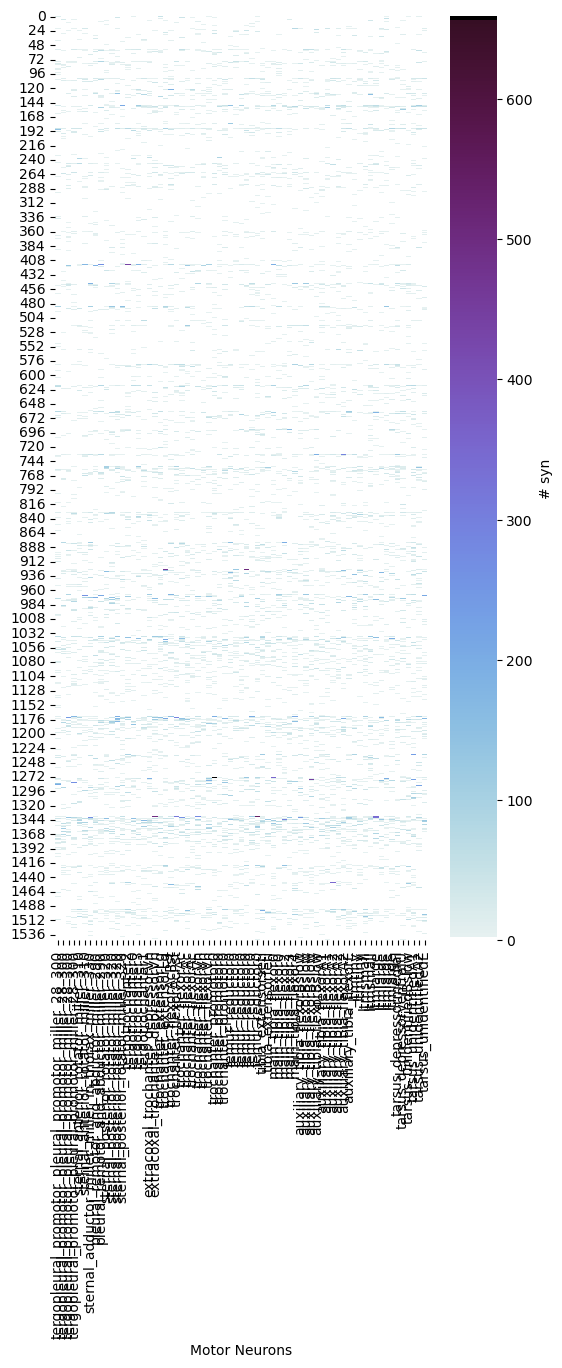

In [46]:
mn_mi_df.iloc[21]
mn_mi_df = pre_to_mn_df.columns.to_frame()
mn_mi_df

# Ha! for this, put the tarsus neurons in the right pools
muscle_tuple_dict = utils.get_motor_pool_tuple_dict()
pool_keys = utils.ta_assigned_pools_coxa_ab()

for key in pool_keys:
    mn_tup = muscle_tuple_dict[key]
    mn_mi_df.loc[mn_tup,'preferred_pool'] = key

pool_keys.append('asterix')
mn_mi_df.loc[mn_mi_df.segID==mn_mi_df.iloc[21].segID,'preferred_pool'] = 'asterix'

pool_keys.append('hold_out')

mn_mi_df.preferred_pool = mn_mi_df.preferred_pool.astype("category")
mn_mi_df.preferred_pool = mn_mi_df.preferred_pool.cat.set_categories(pool_keys)

mwu_val = []

rng = np.random.default_rng()

cos_sim_mean_dict = {}
mixups_dict = {}
mixups_means_dict = {}

motor_pool_mask = np.full((len(mn_mi_df), len(mn_mi_df)), False, dtype=bool)
for i in range(motor_pool_mask.shape[0]):
    for j in range(motor_pool_mask.shape[1]):
        motor_pool_mask[i,j] =(mn_mi_df.iloc[i,:].preferred_pool==mn_mi_df.iloc[j,:].preferred_pool)


tril_mask = np.full((sim_mat.shape[0], sim_mat.shape[1]), True, dtype=bool)
tril_mask = np.tril(tril_mask,-1)
pool_arr = mn_mi_df.preferred_pool.to_numpy()
pool_arr = np.tile(pool_arr.reshape((-1,1)),len(pool_arr))
sim_dict = {
    'pool':pool_arr.reshape(-1),
    'same_pool': motor_pool_mask.reshape(-1),
    'lower_tri':tril_mask.reshape(-1),
    'i_index':i_index.reshape(-1),
    'j_index':j_index.reshape(-1)
    }

sim_compare_df = pd.DataFrame.from_dict(data = sim_dict,orient='columns')
sim_compare_df['sim_vals'] = sim_mat.reshape(-1)
# # get rid of upper triangle
sim_compare_lt_df = sim_compare_df.loc[sim_compare_df.lower_tri.to_numpy()]
# print('Put MN in {}: {} vs. {}'.format(pk,mwu_val_max,mwu_out.statistic / (len(x_inpool)*len(x_outofpool))))

mwu_val =[]
x_inpool_total = []
x_total = []

N=1000
for r in range(N):
    mixupmat = pre_to_mn_df.to_numpy().copy()   
    mixup = mix_up_columns_under_mask(mixupmat,mask=None,rng=rng)
    sim_mat = cosine_similarity(mixup.transpose())
    
    sim_compare_df['sim_vals'] = sim_mat.reshape(-1)
    sim_compare_lt_df = sim_compare_df.loc[sim_compare_df.lower_tri.to_numpy()]
    idx = 'sim_vals'
    x_outofpool = sim_compare_lt_df.loc[~sim_compare_lt_df['same_pool'],idx]
    x_inpool = sim_compare_lt_df.loc[sim_compare_lt_df['same_pool'],idx]
    mwu_out = mannwhitneyu(x_inpool,x_outofpool)
    mwu_val.append(mwu_out.statistic / (len(x_inpool)*len(x_outofpool)))
    x_inpool_total=x_inpool_total+x_inpool.to_list()
    # x_total=x_total+x_inpool.to_list() + x_outofpool.to_list()
    

plot_shuf_cdf(x_inpool_total,color = '#000000',ref_x=x_inpool_median, fn='cdf_inpool_sim_cr_shuffled',fignum=3,title='In pool similarity across {} shuffles (N = {})'.format(N,len(x_inpool_total)))
np.median(x_inpool_total)
plot_shuf_cdf(mwu_val,color = '#000000',ref_x=mwu_val_max, fn='cdf_sim_auc_cr_shuffled',fignum=4,title='MWU AUC (N = {} shuffles)'.format(N))
plot_conn_map(mixup,pre_to_mn_df)
# np.max(x_total)

In [47]:
# np.max(x_total)
# np.median(x_total)

How large can the cosine similarity be, in the defined pools, if the adj mat is shuffled?

The within pool similarity is almost always less than .1, whereas the median in pool similarity is actually 0.64

How large can the auc be when comparing within pool distributions vs. across pool distributions?

So, the in pool similarity is always small, and within pool vs. across pool distributions are always similar.

# Shuffle rows, keep the pools

In [48]:
mn_mi_df.iloc[21]
mn_mi_df = pre_to_mn_df.columns.to_frame()
mn_mi_df

# Ha! for this, put the tarsus neurons in the right pools
muscle_tuple_dict = utils.get_motor_pool_tuple_dict()
pool_keys = utils.ta_assigned_pools_coxa_ab()

for key in pool_keys:
    mn_tup = muscle_tuple_dict[key]
    mn_mi_df.loc[mn_tup,'preferred_pool'] = key

pool_keys.append('asterix')
mn_mi_df.loc[mn_mi_df.segID==mn_mi_df.iloc[21].segID,'preferred_pool'] = 'asterix'

pool_keys.append('hold_out')

mn_mi_df.preferred_pool = mn_mi_df.preferred_pool.astype("category")
mn_mi_df.preferred_pool = mn_mi_df.preferred_pool.cat.set_categories(pool_keys)

mwu_val = []

rng = np.random.default_rng()

cos_sim_mean_dict = {}
mixups_dict = {}
mixups_means_dict = {}

motor_pool_mask = np.full((len(mn_mi_df), len(mn_mi_df)), False, dtype=bool)
for i in range(motor_pool_mask.shape[0]):
    for j in range(motor_pool_mask.shape[1]):
        motor_pool_mask[i,j] =(mn_mi_df.iloc[i,:].preferred_pool==mn_mi_df.iloc[j,:].preferred_pool)


tril_mask = np.full((sim_mat.shape[0], sim_mat.shape[1]), True, dtype=bool)
tril_mask = np.tril(tril_mask,-1)
pool_arr = mn_mi_df.preferred_pool.to_numpy()
pool_arr = np.tile(pool_arr.reshape((-1,1)),len(pool_arr))
sim_dict = {
    'pool':pool_arr.reshape(-1),
    'same_pool': motor_pool_mask.reshape(-1),
    'lower_tri':tril_mask.reshape(-1),
    'i_index':i_index.reshape(-1),
    'j_index':j_index.reshape(-1)
    }

sim_compare_df = pd.DataFrame.from_dict(data = sim_dict,orient='columns')
sim_compare_df['sim_vals'] = sim_mat.reshape(-1)
# # get rid of upper triangle
sim_compare_lt_df = sim_compare_df.loc[sim_compare_df.lower_tri.to_numpy()]
# print('Put MN in {}: {} vs. {}'.format(pk,mwu_val_max,mwu_out.statistic / (len(x_inpool)*len(x_outofpool))))

mwu_val =[]
x_inpool_total = []
x_total = []

N=1000
for r in range(N):
    mixupmat = pre_to_mn_df.to_numpy().copy()   
    mixup = mix_up_rows_under_mask(mixupmat,mask=None,rng=rng)
    sim_mat = cosine_similarity(mixup.transpose())
    
    sim_compare_df['sim_vals'] = sim_mat.reshape(-1)
    sim_compare_lt_df = sim_compare_df.loc[sim_compare_df.lower_tri.to_numpy()]
    idx = 'sim_vals'
    x_outofpool = sim_compare_lt_df.loc[~sim_compare_lt_df['same_pool'],idx]
    x_inpool = sim_compare_lt_df.loc[sim_compare_lt_df['same_pool'],idx]
    mwu_out = mannwhitneyu(x_inpool,x_outofpool)
    mwu_val.append(mwu_out.statistic / (len(x_inpool)*len(x_outofpool)))
    x_inpool_total=x_inpool_total+x_inpool.to_list()
    # x_total=x_total+x_inpool.to_list() + x_outofpool.to_list()


In [49]:
# np.max(x_total)
# np.median(x_total)

How large can the cosine similarity be, in the defined pools, if the adj mat is shuffled?

0.026690540064246815

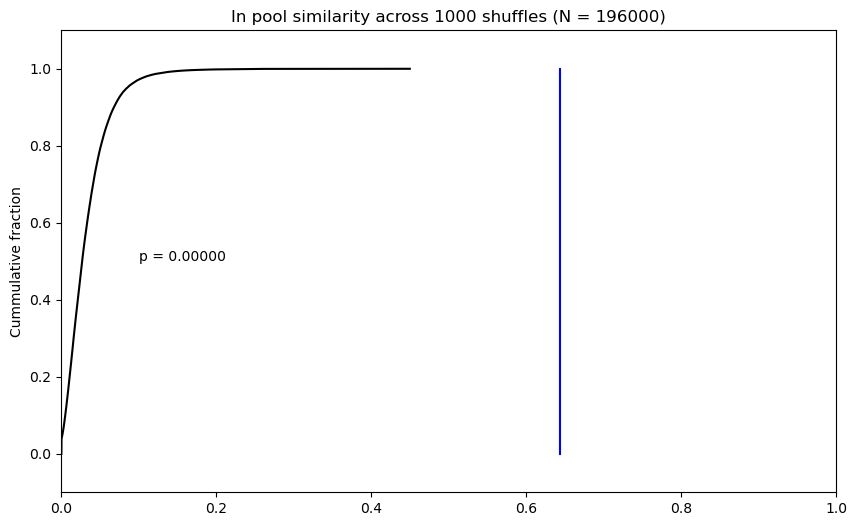

In [50]:
plot_shuf_cdf(x_inpool_total,color = '#000000',ref_x=x_inpool_median, fn='cdf_inpool_sim_cr_shuffled',fignum=4,title='In pool similarity across {} shuffles (N = {})'.format(N,len(x_inpool_total)))
np.median(x_inpool_total)

The within pool similarity is almost always less than .1, whereas the median in pool similarity is actually 0.64

How large can the auc be when comparing within pool distributions vs. across pool distributions?

<AxesSubplot: title={'center': 'MWU AUC (N = 1000 shuffles)'}, ylabel='Cummulative fraction'>

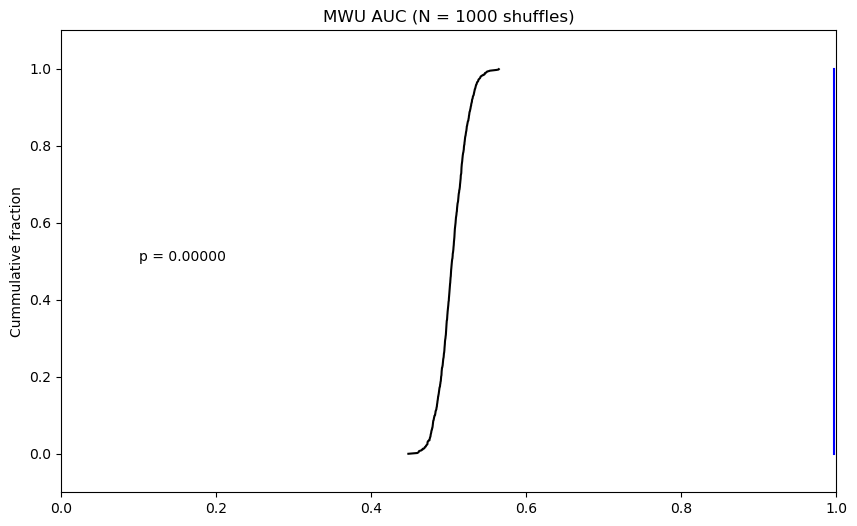

In [51]:
plot_shuf_cdf(mwu_val,color = '#000000',ref_x=mwu_val_max, fn='cdf_sim_auc_cr_shuffled',fignum=4,title='MWU AUC (N = {} shuffles)'.format(N))

So, the in pool similarity is always small, and within pool vs. across pool distributions are always similar.

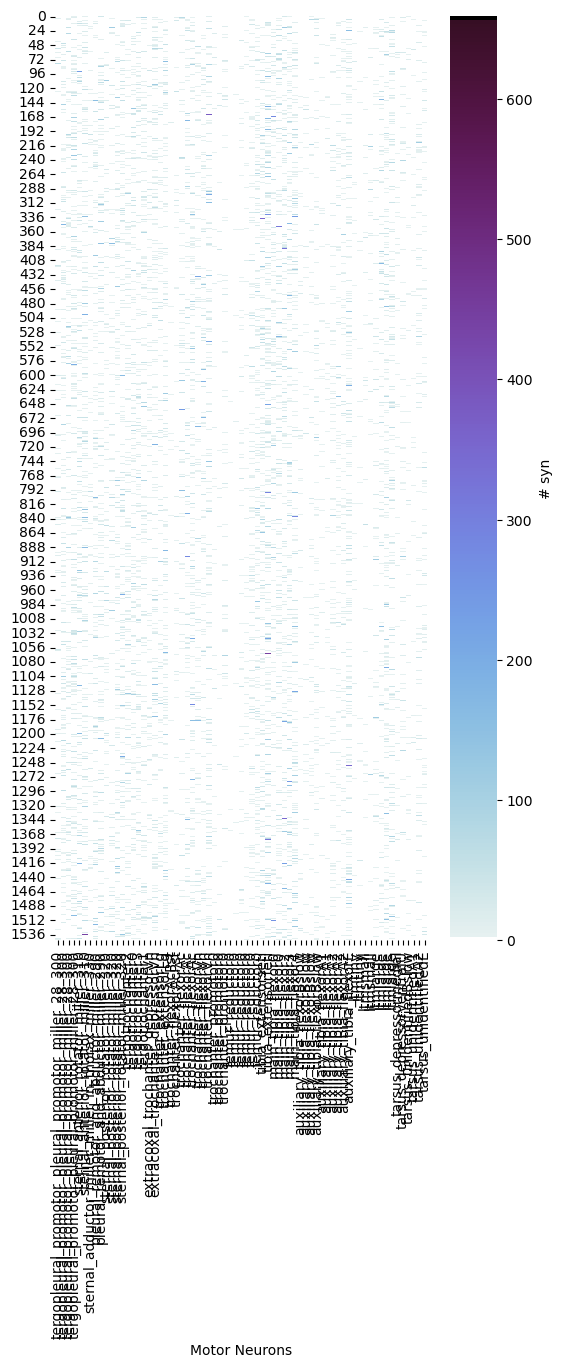

In [52]:
plot_conn_map(mixup,pre_to_mn_df)

# Pool preference for preMNs under column shuffle

In [53]:
len(pool_keys)

16

mean: 0.7506653156142181 +- 0.23703416758242127
median: 0.7984375 +- 0.4557607853267889
0
100
200
300
400
500
600
700
800
900


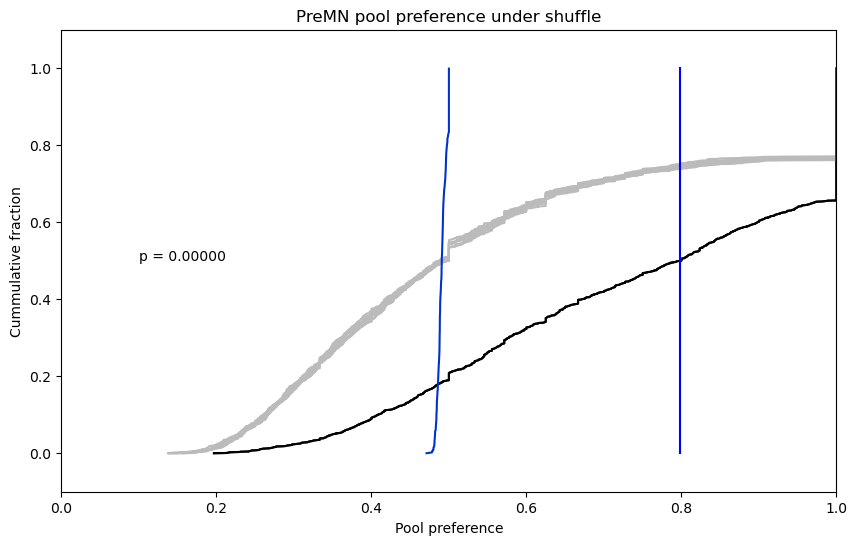

<Figure size 1000x600 with 0 Axes>

In [54]:

rng = np.random.default_rng()

mn_mi_df = pre_to_mn_df.columns.to_frame()
muscle_tuple_dict = utils.get_motor_pool_tuple_dict()
pool_keys = utils.ta_assigned_pools_coxa_ab()

for key in pool_keys:
    mn_tup = muscle_tuple_dict[key]
    mn_mi_df.loc[mn_tup,'preferred_pool'] = key

mn_mi_df.preferred_pool = mn_mi_df.preferred_pool.astype("category")
mn_mi_df.preferred_pool = mn_mi_df.preferred_pool.cat.set_categories(pool_keys)

pool_mat = np.full((pre_to_mn_df.shape[0],len(pool_keys)),fill_value=0,dtype=np.int64)
out_df = pd.DataFrame(pool_mat[:,0:2],columns=['pool','pref'])

out_df['pool'] = ''
denom = pre_to_mn_df.sum(axis=1).reset_index(drop=True).to_numpy()
out_df['sum'] = denom

pk_idx_dict = {}
for pk in pool_keys:
        pk_idx = mn_mi_df.preferred_pool==pk
        pk_idx_dict[pk] = pk_idx.to_numpy()

mixupmat = pre_to_mn_df.to_numpy()
pool_keys_mat = np.tile(pool_keys, (pre_to_mn_df.shape[0], 1))
r_idx = np.arange(len(denom))

def calc_pool_pref_from_mat(mixupmat, pool_mat ,out_df):
    
    c = -1
    for pk in pool_keys:
        c=c+1
        pk_idx = pk_idx_dict[pk]
        pool_mat[:,c] = mixupmat[:,pk_idx].sum(axis=1)

    idx = np.argmax(pool_mat,axis=1)
    # return  pool_keys[idx], pool_mat[:,idx] / denom
    out_df['pool'] = pool_keys_mat[r_idx,idx]
    out_df['pref'] = np.divide(pool_mat[r_idx,idx], denom)
    return out_df

out_df = calc_pool_pref_from_mat(mixupmat, pool_mat ,out_df)

x = out_df['pref'].to_numpy()
ax = plot_shuf_cdf(x,color = '#000000',ref_x=None, fn=None,fignum=4,title=None)
pool_pref_median = np.median(x)
iqr = np.percentile(x, 75) - np.percentile(x, 25)
print('mean: {} +- {}'.format(np.mean(x),np.std(x)))
print('median: {} +- {}'.format(np.median(x),iqr))

frac_100pct_unshuff = np.sum(out_df['pref']==1)/out_df.shape[0]

N=1000
# Redo this, incorrect
mixed_prefs = []
mixed_pref_median = []
frac_100pct = []
for r in range(N):
    mixupmat = pre_to_mn_df.to_numpy().copy()
    mixup = mix_up_columns_under_mask(mixupmat,mask=None,rng=rng)
    out_df = calc_pool_pref_from_mat(mixup, pool_mat ,out_df)
    # mixed_prefs = mixed_prefs + out_df['pref'].to_list()
    mixed_pref_median.append(out_df['pref'].median())
    frac_100pct.append(np.sum(out_df['pref']==1)/out_df.shape[0])
    if np.mod(r,100)==0:
        print(r)
        plot_shuf_cdf(out_df['pref'].to_numpy(),color = '#BBBBBB',ref_x=None, fn=None,fignum=3,title=None,ax=ax)

plot_shuf_cdf(x,color = '#000000',ref_x=None, fn=None,fignum=3,title=None,ax=ax)
ax = plot_shuf_cdf(mixed_pref_median,color = '#0033CC',ref_x=pool_pref_median, fn=None,fignum=3,title='PreMN pool preference under shuffle',ax=ax,xlabel='Pool preference')

f = ax.get_figure()
f.savefig('./figpanels/shuffled_pool_preference.svg',format='svg')

0.4711431742508324
0.5


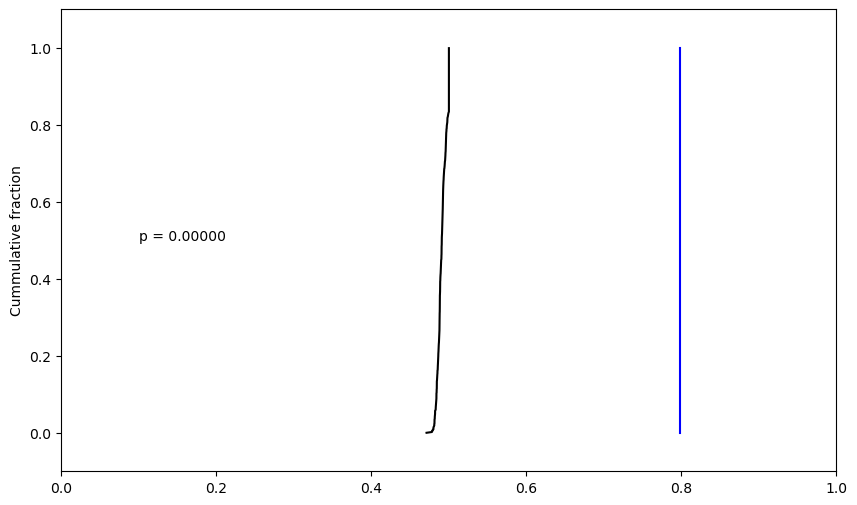

In [55]:
plot_shuf_cdf(mixed_pref_median,color = '#000000',ref_x=pool_pref_median, fn=None,fignum=3,title=None)
print(np.array(mixed_pref_median).min())
print(np.array(mixed_pref_median).max())


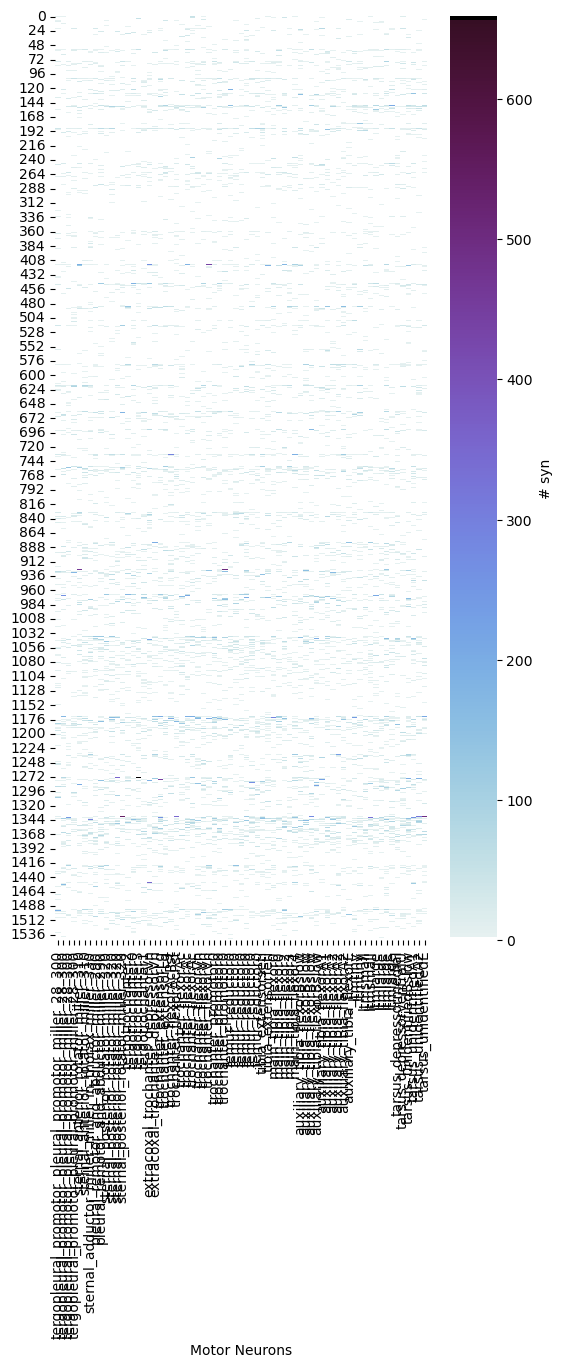

In [56]:
plot_conn_map(mixup,pre_to_mn_df)

# Pool preference for Ach vs. GABA vs. Glu preMNs under column shuffle

In [62]:
mn_mi_df = pre_to_mn_df.columns.to_frame()
mn_mi_df

side  \
side nerve   segment function muscle                                             rank     segID              module                         
L    Dorsal  thorax  swing    tergopleural_promotor_pleural_promotor_miller_2... 0        648518346487756866 coxa_promote               L   
                                                                                          648518346491659326 coxa_promote               L   
                                                                                          648518346517437482 coxa_promote               L   
                                                                                          648518346479446972 coxa_promote               L   
     Ventral thorax  swing    sternal_anterior_rotator_miller_31                 0        648518346479325585 coxa_rotate_adduct         L   
...                                                                                                                                   ...   
     Leg     tibia   flex     tarsus_depressor                                   ventralU 648518346486890393 tarsus_depress_ventralU    L   
                     unknown  tarsus_unidentified                                Bslow    648518346480904925 tibia_ta_flex_A            L   
                                                                                 A1       648518346489767549 tibia_ta_flex_B            L   
                                                                                 A2       648518346495467855 tibia_ta_flex_B            L   
                                                                                 E        648518346511950704 tibia_ta_flex_C            L   

                                                                                                                                        nerve  \
side nerve   segment function muscle                                             rank     segID              module                             
L    Dorsal  thorax  swing    tergopleural_promotor_pleural_promotor_miller_2... 0        648518346487756866 coxa_promote              Dorsal   
                                                                                          648518346491659326 coxa_promote              Dorsal   
                                                                                          648518346517437482 coxa_promote              Dorsal   
                                                                                          648518346479446972 coxa_promote              Dorsal   
     Ventral thorax  swing    sternal_anterior_rotator_miller_31                 0        648518346479325585 coxa_rotate_adduct       Ventral   
...                                                                                                                                       ...   
     Leg     tibia   flex     tarsus_depressor                                   ventralU 648518346486890393 tarsus_depress_ventralU      Leg   
                     unknown  tarsus_unidentified                                Bslow    648518346480904925 tibia_ta_flex_A              Leg   
                                                                                 A1       648518346489767549 tibia_ta_flex_B              Leg   
                                                                                 A2       648518346495467855 tibia_ta_flex_B              Leg   
                                                                                 E        648518346511950704 tibia_ta_flex_C              Leg   

                                                                                                                                     segment  \
side nerve   segment function muscle                                             rank     segID              module                            
L    Dorsal  thorax  swing    tergopleural_promotor_pleural_promotor_miller_2... 0        648518346487756866 coxa_promote    

In [63]:
pre_to_mn_pref_df = pre_to_mn_df.copy()

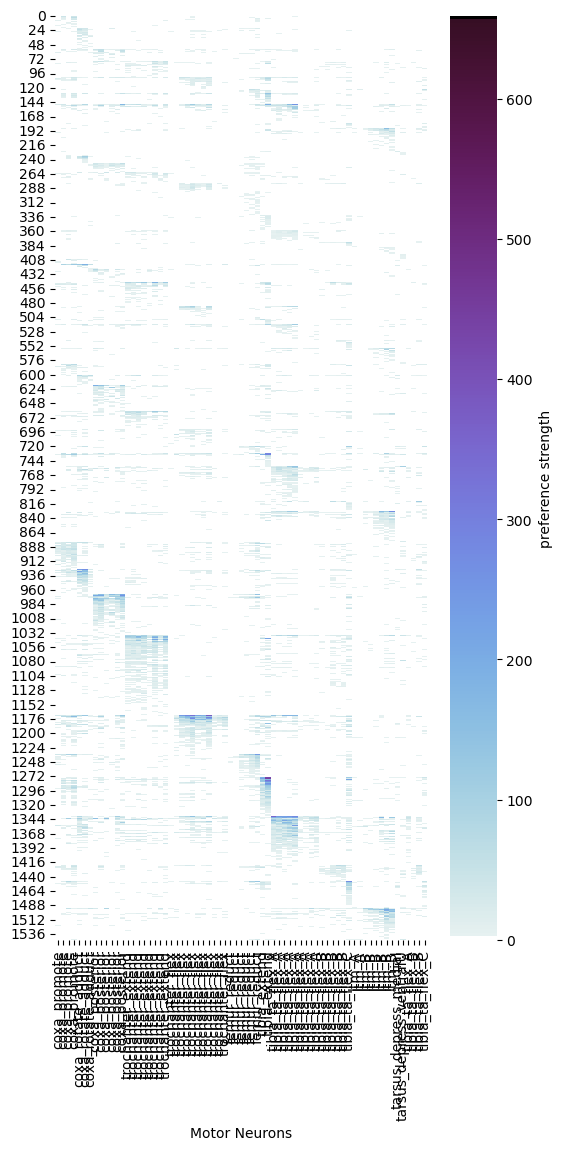

In [65]:
lbls = pre_to_mn_pref_df.columns.get_level_values('module').to_list()
fig = plt.figure(figsize = [6,12])
ax = sns.heatmap(pre_to_mn_pref_df.values, xticklabels=lbls, cmap=utils.white_dense())
# ax.xaxis.set_ticks_position('top')
cbar = ax.collections[0].colorbar
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

cbar.set_label(label = 'preference strength')
plt.xlabel('Motor Neurons')
plt.show()


0.6474287828338883
0
100
200
300
400
500
600
700
800
900
Ach range: 0.3482620320855615-0.3989247311827957
0.6474287828338883
Ach single mod faction: 0.16095890410958905
0.8033018867924528
0
100


C:\Users\tony\AppData\Local\Temp\ipykernel_18588\3578662235.py:72: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot2grid((1,1),(0,0))


200
300
400
500
600
700
800
900
GABA range: 0.41102756892230574-0.47368421052631576
0.8033018867924528
GABA single mod faction: 0.2755102040816326
0.8354430379746836
0
100


C:\Users\tony\AppData\Local\Temp\ipykernel_18588\3578662235.py:72: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot2grid((1,1),(0,0))


200
300
400
500
600
700
800
900
Glu range: 0.41202672605790647-0.46938775510204084
0.8354430379746836
Glu single mod faction: 0.2598870056497175


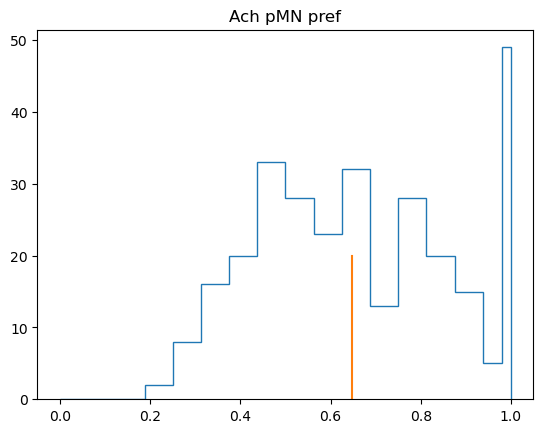

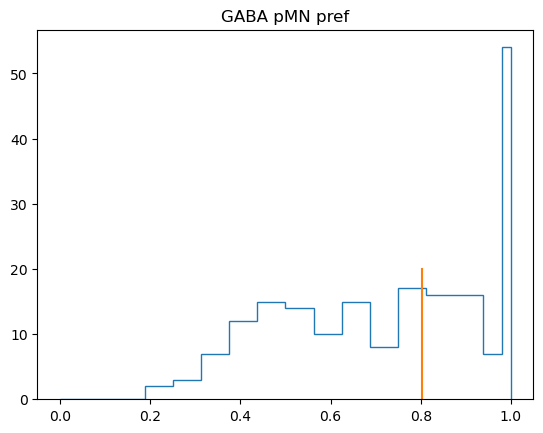

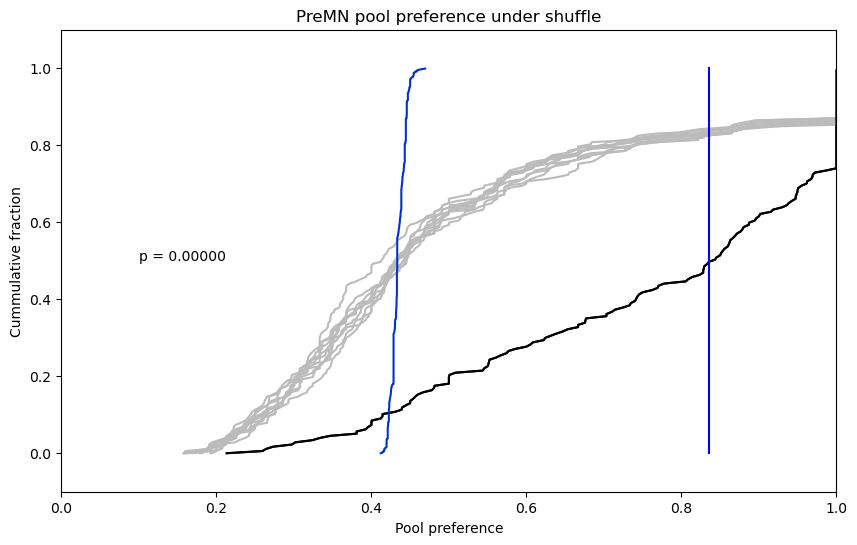

<Figure size 1000x600 with 0 Axes>

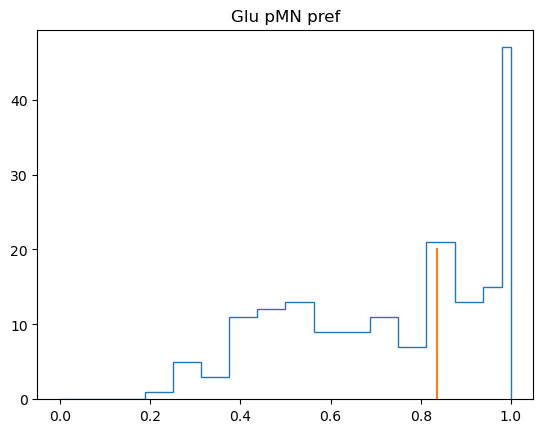

In [67]:
rng = np.random.default_rng()
nt_prefs_dict = {}
prefs_test_df = None
cnt = 0

for NT in ['Ach','GABA','Glu']:


    select_local_df = pre_to_mn_pref_df.loc[('local',All,NT,All,All,All)]

    pool_mat = np.full((select_local_df.shape[0],len(pool_keys)),fill_value=0,dtype=np.int64)
    out_df = pd.DataFrame(pool_mat[:,0:2],columns=['pool','pref'])

    out_df['pool'] = ''
    denom = select_local_df.sum(axis=1).reset_index(drop=True).to_numpy()
    out_df['sum'] = denom

    pk_idx_dict = {}
    for pk in pool_keys:
            pk_idx = mn_mi_df.module==pk
            pk_idx_dict[pk] = pk_idx.to_numpy()

    mixupmat = select_local_df.to_numpy()
    pool_keys_mat = np.tile(pool_keys, (select_local_df.shape[0], 1))
    r_idx = np.arange(len(denom))

    def calc_pool_pref_from_mat(mixupmat, pool_mat ,out_df):
        
        c = -1
        for pk in pool_keys:
            c=c+1
            pk_idx = pk_idx_dict[pk]
            pool_mat[:,c] = mixupmat[:,pk_idx].sum(axis=1)

        idx = np.argmax(pool_mat,axis=1)
        # return  pool_keys[idx], pool_mat[:,idx] / denom
        out_df['pool'] = pool_keys_mat[r_idx,idx]
        out_df['pref'] = np.divide(pool_mat[r_idx,idx], denom)
        return out_df

    out_df = calc_pool_pref_from_mat(mixupmat, pool_mat ,out_df)

    x = out_df['pref'].to_numpy()
    ax = plot_shuf_cdf(x,color = '#000000',ref_x=None, fn=None,fignum=4,title='{} preMN preference'.format(NT))
    pool_pref_median = np.median(x)
    print(pool_pref_median)
    frac_100pct_unshuff = np.sum(out_df['pref']==1)/out_df.shape[0]

    N=1000

    mixed_prefs = []
    mixed_pref_median = []
    frac_100pct = []
    for r in range(N):
        mixupmat = select_local_df.to_numpy().copy()
        mixup = mix_up_columns_under_mask(mixupmat,mask=None,rng=rng)
        out_df = calc_pool_pref_from_mat(mixup, pool_mat ,out_df)
        # mixed_prefs = mixed_prefs + out_df['pref'].to_list()
        mixed_pref_median.append(out_df['pref'].median())
        frac_100pct.append(np.sum(out_df['pref']==1)/out_df.shape[0])
        if np.mod(r,100)==0:
            print(r)
            plot_shuf_cdf(out_df['pref'].to_numpy(),color = '#BBBBBB',ref_x=None, fn=None,fignum=3,title=None,ax=ax)

    print('{} range: {}-{}'.format(NT,np.array(mixed_pref_median).min(),np.array(mixed_pref_median).max()))

    plot_shuf_cdf(x,color = '#000000',ref_x=None, fn=None,fignum=3,title=None,ax=ax)
    ax = plot_shuf_cdf(mixed_pref_median,color = '#0033CC',ref_x=pool_pref_median, fn=None,fignum=3,title='PreMN pool preference under shuffle',ax=ax,xlabel='Pool preference')

    fig,ax = plt.subplots()
    e = np.sort(np.append(np.array(range(16+1))/16,.98))
    h,e = np.histogram(x, bins=e, range=None, density=False, weights=None)
    ax.stairs(h, e, label='each_prefs')
    ax.plot(np.median(x)* np.array([1, 1,]),[0.,20])
    ax.set_title('{} pMN pref'.format(NT))
    fig.savefig('./figpanels/pref_hist_{}.svg'.format(NT)) #'Glu' 'GABA'
    print(np.median(x))
    print('{} single mod faction: {}'.format(NT,float(np.sum(x==1))/len(x)))

    nt_prefs_dict[NT] = x
    if prefs_test_df is None:
        df_dict = {'pref':x,'NT':NT,'id':cnt}
        prefs_test_df = pd.DataFrame.from_dict(df_dict)
        cnt=cnt+1
    else:
        df_dict = {'pref':x,'NT':NT,'id':cnt}
        prefs_test_df = pd.concat([prefs_test_df,pd.DataFrame.from_dict(df_dict)],axis=0)
        cnt=cnt+1

In [68]:
from scipy.stats import kruskal
print(kruskal(nt_prefs_dict['Ach'],nt_prefs_dict['Glu'],nt_prefs_dict['GABA']))

from scikit_posthocs import posthoc_conover 

posthoc_conover(prefs_test_df,val_col= 'pref',group_col='NT',p_adjust='holm')


KruskalResult(statistic=21.475675790465715, pvalue=2.1707822136887513e-05)


Ach      GABA       Glu
Ach   1.000000  0.000605  0.000105
GABA  0.000605  1.000000  0.553190
Glu   0.000105  0.553190  1.000000

0.41202672605790647
0.46938775510204084


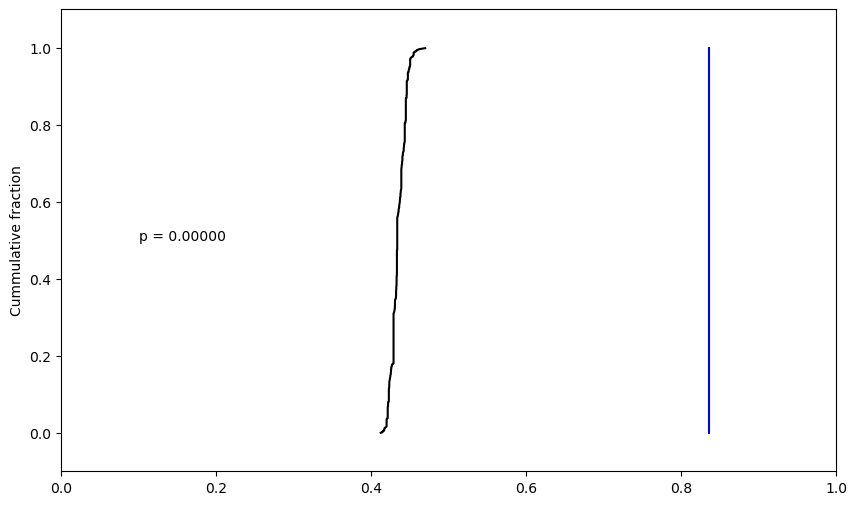

In [69]:
plot_shuf_cdf(mixed_pref_median,color = '#000000',ref_x=pool_pref_median, fn=None,fignum=3,title=None)
print(np.array(mixed_pref_median).min())
print(np.array(mixed_pref_median).max())


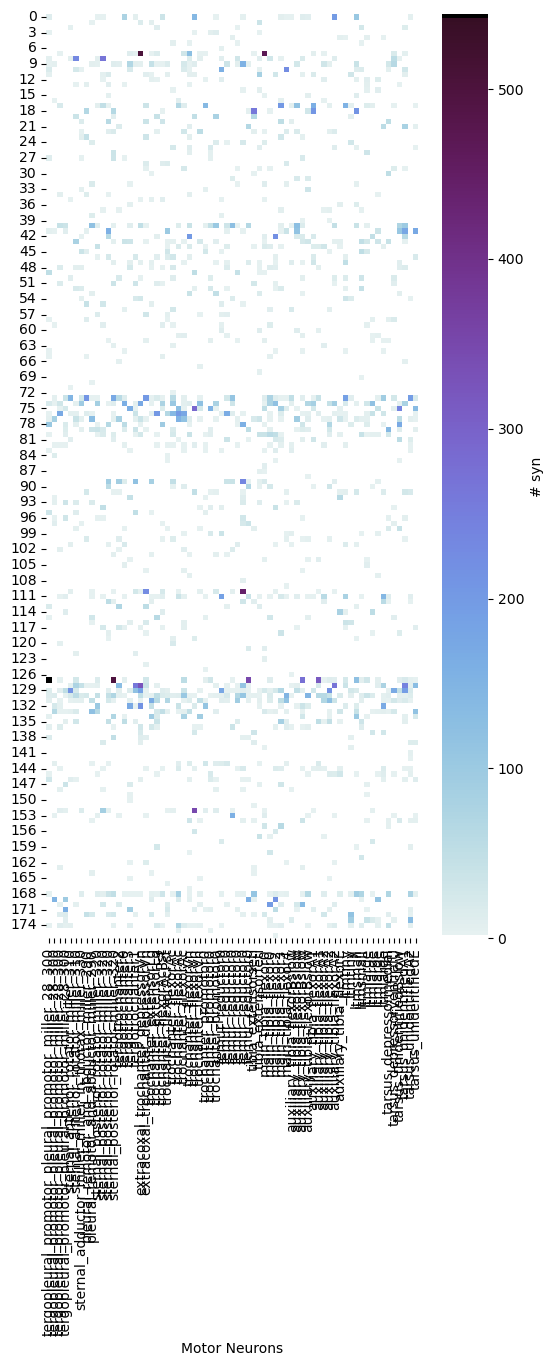

In [70]:
plot_conn_map(mixup,pre_to_mn_df)

# What is the preference strength for the antagonists?

side                                                                                                                                             L  \
nerve                                                                                                                                       Dorsal   
segment                                                                                                                                     thorax   
function                                                                                                                                     swing   
muscle                                                                                         tergopleural_promotor_pleural_promotor_miller_28_30   
rank                                                                                                                                             0   
segID                                                                                                                           648518346487756866   
module                                                                                                                                coxa_promote   
cell_class preferred_pool          NT   classification_system cell_type     segID                                                                    
descending coxa_promote            NaN  NaN                   NaN           648518346493883193                                                  0    
                                                                            648518346497743463                                                  0    
                                                                            648518346494476087                                                  0    
                                                                            648518346507377529                                                  0    
                                                                            648518346494232199                                                  0    
...                                                                                                                                            ...   
local      ltm_B                   GABA 19A                   19A_mid       648518346504149710                                                  0    
                                        09A                   09A           648518346490340104                                                  0    
                                   Ach  22A                   22A_posterior 648518346521544953                                                  0    
           tarsus_depress_medial   GABA 12B                   12B           648518346484940957                                                  0    
           tarsus_depress_ventralU Ach  03A                   03A           648518346491766952                                                  0    

side                                                                                                               \
nerve                                                                                                               
segment                                                                                                             
function                                                                                                            
muscle                                                                                                              
rank                                                                                                                
segID                                                                                          648518346491659326   
module                                                                                               coxa_promote   
cell_class preferred_pool          NT   classification_system c

In [115]:
# pre_to_mn_df = connectome_create.load_pre_to_mn_df(ext='matched_typed_with_nt')
pre_to_mn_df = pd.read_pickle('./dfs_pre_to_mn/pre_to_mn_df_matched_typed_with_nt_v840.pkl')
pre_to_mn_df.shape
pre_to_mn_df.sum(axis=0).sum()

mn_mi_df = pre_to_mn_df.columns.to_frame()

# Ha! for this, put the tarsus neurons in the right pools
muscle_tuple_dict = utils.get_motor_pool_tuple_dict()
pool_keys = utils.ta_assigned_pools_coxa_ab()

for key in pool_keys:
    mn_tup = muscle_tuple_dict[key]
    mn_mi_df.loc[mn_tup,'preferred_pool'] = key

# In this case, keep the asterix neuron as part of the trochanter pool
# pool_keys.append('asterix')
# mn_mi_df.loc[mn_mi_df.segID==mn_mi_df.iloc[21].segID,'preferred_pool'] = 'asterix'
# weird_others.loc[(weird_others==1).any(axis=1)]
# pre_to_mn_pref_df.loc[(All,All,All,All,All,648518346472549067),:].sum(axis=1)

mn_mi_df.preferred_pool = mn_mi_df.preferred_pool.astype("category")
mn_mi_df.preferred_pool = mn_mi_df.preferred_pool.cat.set_categories(pool_keys) 
print(mn_mi_df.iloc[21])
module_names = mn_mi_df.preferred_pool.unique().tolist()

pre_to_mn_pref_df = pre_to_mn_df.copy()
pre_to_mn_pref_df.columns = pd.MultiIndex.from_frame(mn_mi_df)
pre_to_mn_pref_df.head()

side                               L
nerve                      Accessory
segment                         coxa
function                        flex
muscle             trochanter_flexor
rank                           AcPst
segID             648518346477140752
module               trochanter_flex
preferred_pool       trochanter_flex
Name: (L, Accessory, coxa, flex, trochanter_flexor, AcPst, 648518346477140752, trochanter_flex), dtype: object


side                                                                                                                               L  \
nerve                                                                                                                         Dorsal   
segment                                                                                                                       thorax   
function                                                                                                                       swing   
muscle                                                                           tergopleural_promotor_pleural_promotor_miller_28_30   
rank                                                                                                                               0   
segID                                                                                                             648518346487756866   
module                                                                                                                  coxa_promote   
preferred_pool                                                                                                          coxa_promote   
cell_class preferred_pool NT  classification_system cell_type segID                                                                    
descending coxa_promote   NaN NaN                   NaN       648518346493883193                                                  0    
                                                              648518346497743463                                                  0    
                                                              648518346494476087                                                  0    
                                                              648518346507377529                                                  0    
                                                              648518346494232199                                                  0    

side                                                                                                 \
nerve                                                                                                 
segment                                                                                               
function                                                                                              
muscle                                                                                                
rank                                                                                                  
segID                                                                            648518346491659326   
module                                                                                 coxa_promote   
preferred_pool                                                                         coxa_promote   
cell_class preferred_pool NT  classification_system cell_type segID                                   
descending coxa_promote   NaN NaN                   NaN       648518346493883193                 17   
                                                              648518346497743463                 42   
                                                              648518346494476087                 13   
                                                              648518346507377529                 12   
                                                              648518346494232199                 11   

side                                                                                                 \
nerve                                                                                                 
segment                                                                                               
function                                                                                              
m

In [116]:
module_names

['coxa_promote',
 'coxa_rotate_adduct',
 'coxa_posterior',
 'trochanter_extend',
 'trochanter_flex',
 'femur_reduct',
 'tibia_extend',
 'tibia_ta_flex_A',
 'tibia_ta_flex_B',
 'tibia_ta_flex_C',
 'ltm_A',
 'ltm_B',
 'tarsus_depress_medial',
 'tarsus_depress_ventralU']

## Over individual preMNs 

(21644,)
coxa_posterior ant shape = (170,)
(170, 13)
(170, 0)
(250, 12)
(250, 1)
(146, 12)
(146, 1)
(138, 12)
(138, 1)
(213, 12)
(213, 1)
(21644,)
(1546,)
(20098,)
(11174,)
(917,)


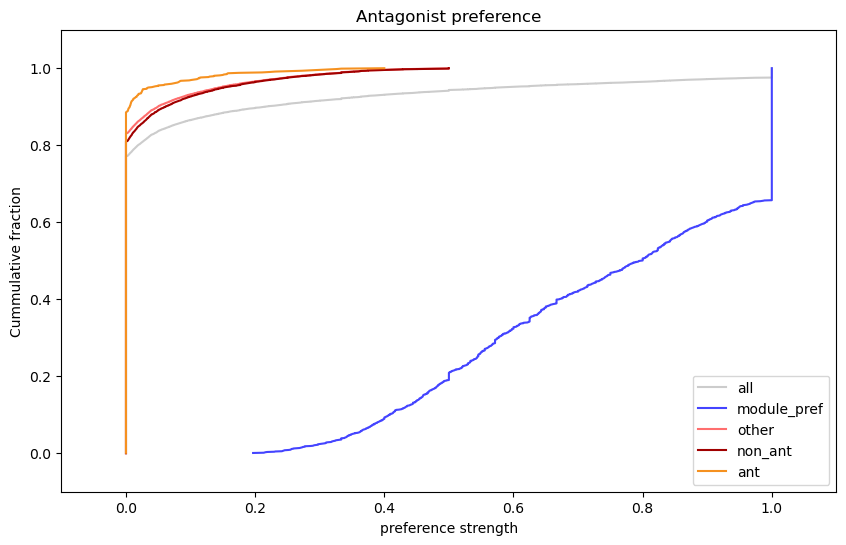

all: 0.07142857142857142 +- 0.0014123626463089418
others: 0.02076735000177679 +- 0.0006117108932106734
antagonist: 0.008163160445710919 +- 0.0012406165252640327


MannwhitneyuResult(statistic=4707416.0, pvalue=1.4146904640961485e-09)

In [117]:
pref_total_df = pre_to_mn_pref_df.T.groupby(level='preferred_pool',observed=True).sum().T
denom = pref_total_df.sum(axis=1)
pref_strength_df = pref_total_df.div(denom,axis=0)
# pref_strength_df = pref_strength_df.droplevel(['cell_class','NT','classification_system','cell_type','segID'])
pref_strength_df = pref_strength_df.droplevel(['cell_class','NT','classification_system','cell_type'])
pref_strength_df.head()

antagonists_dict = {
    'coxa_promote':'coxa_posterior',
    'coxa_rotate_adduct':'coxa_posterior',
    'coxa_posterior':['coxa_promote','coxa_rotate_adduct'],
    'trochanter_extend':'trochanter_flex',
    'trochanter_flex':'trochanter_extend',
    'tibia_extend':'tibia_ta_flex_A',
    'tibia_ta_flex_A':'tibia_extend',
}
ant_distr_dict = {}
other_distr_dict = {}
eachother_distr_dict = {}
each_distr_dict = {}

all_prefs = np.ravel(pref_strength_df.values)
print(all_prefs.shape)
for mod in module_names:
    each = pref_strength_df.loc[mod,((pref_strength_df.columns.get_level_values('preferred_pool') == mod))]
    each_distr_dict[mod] = np.ravel(each.values)
    eachothers = pref_strength_df.loc[mod,((pref_strength_df.columns.get_level_values('preferred_pool') != mod))]
    eachother_distr_dict[mod] = np.ravel(eachothers.values)
    if mod in antagonists_dict.keys():
        others = pref_strength_df.loc[mod,((pref_strength_df.columns.get_level_values('preferred_pool') != mod) & ([True if i not in antagonists_dict[mod] else False for i in pref_strength_df.columns.get_level_values('preferred_pool')]))]
        #others = pref_strength_df.loc[mod,((pref_strength_df.columns.get_level_values('preferred_pool') != mod))]
        other_distr_dict[mod] = np.ravel(others.values)
        antagonists = pref_strength_df.loc[mod,([True if i in antagonists_dict[mod] else False for i in pref_strength_df.columns.get_level_values('preferred_pool')])]
        if mod=='coxa_posterior':
            ant_distr_dict[mod] = np.ravel(antagonists.sum(axis=1).values)
            print('{} ant shape = {}'.format(mod,ant_distr_dict[mod].shape))
        else:
            ant_distr_dict[mod] = np.ravel(antagonists.values)
        if np.any(np.ravel(other_distr_dict[mod]==1)):
            print(mod)
            weird_others = others.copy()
        print(others.shape)
        print(antagonists.shape)

print(all_prefs.shape)
each_prefs = np.concatenate(list(each_distr_dict.values()), axis=0)
print(each_prefs.shape)
eachothers_prefs = np.concatenate(list(eachother_distr_dict.values()), axis=0)
print(eachothers_prefs.shape)
others_prefs = np.concatenate(list(other_distr_dict.values()), axis=0)
print(others_prefs.shape)
antagonist_prefs = np.concatenate(list(ant_distr_dict.values()), axis=0)
print(antagonist_prefs.shape)


fig = plt.figure(figsize=(10, 6))
ax = plt.subplot2grid((1,1),(0,0))
ax.set_ylim([-.1, 1.1])
ax.set_xlim([-.1, 1.1])

ax.set_ylabel('Cummulative fraction')
ax.set_xlabel('preference strength')
ax.set_title('Antagonist preference')

y_all = (np.array(range(len(all_prefs))).astype(float)+1)/len(all_prefs)
y_each = (np.array(range(len(each_prefs))).astype(float)+1)/len(each_prefs)
y_eachothers = (np.array(range(len(eachothers_prefs))).astype(float)+1)/len(eachothers_prefs)
y_other = (np.array(range(len(others_prefs))).astype(float)+1)/len(others_prefs)
y_ants = (np.array(range(len(antagonist_prefs))).astype(float)+1)/len(antagonist_prefs)

ax.plot(sorted(all_prefs),y_all,color='#CCCCCC',label='all')
ax.plot(sorted(each_prefs),y_each,color='#4444FF',label='module_pref')
ax.plot(sorted(eachothers_prefs),y_eachothers,color='#ff6e6e',label='other')
ax.plot(sorted(others_prefs),y_other,color='#a00000',label='non_ant')
ax.plot(sorted(antagonist_prefs),y_ants,color='#f59120',label='ant')
    # fig.savefig('./figpanels/{}.svg'.format(fn),format='svg')

ax.legend()
plt.show()

print('all: {} +- {}'.format(all_prefs.mean(),np.std(all_prefs,ddof=1)/np.sqrt(len(all_prefs))))
print('others: {} +- {}'.format(others_prefs.mean(),np.std(others_prefs,ddof=1)/np.sqrt(len(others_prefs))))
print('antagonist: {} +- {}'.format(antagonist_prefs.mean(),np.std(antagonist_prefs,ddof=1)/np.sqrt(len(antagonist_prefs))))

mwu_out = mannwhitneyu(antagonist_prefs,others_prefs)
mwu_out

0.0
0.8854961832061069


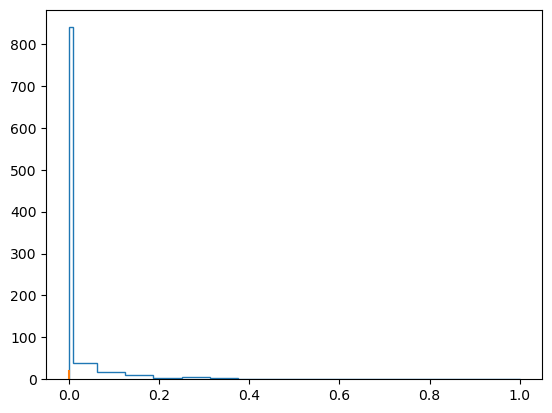

In [118]:
fig,ax = plt.subplots()
e = np.sort(np.append(np.array(range(16+1))/16,.01))
h,e = np.histogram(antagonist_prefs, bins=e, range=None, density=False, weights=None)
ax.stairs(h, e, label='each_prefs')
ax.plot(np.median(antagonist_prefs)* np.array([1, 1,]),[0.,20])
fig.savefig('./figpanels/pref_hist_antagonist.svg')
print(np.median(antagonist_prefs))
print(float(np.sum(antagonist_prefs==0))/len(antagonist_prefs))

# ax = sns.violinplot(data=others_prefs[others_prefs<.8], orient='vertical',scale='area', cut=0,bw=.25)

# antagonist_prefs
# sns.violinplot(data=antagonist_prefs, orient='vertical',scale='area', cut=0,bw=.25)

## Shuffle columns, then calculate antagonist prefs

In [119]:
pre_to_mn_pref_df

side                                                                                                                                             L  \
nerve                                                                                                                                       Dorsal   
segment                                                                                                                                     thorax   
function                                                                                                                                     swing   
muscle                                                                                         tergopleural_promotor_pleural_promotor_miller_28_30   
rank                                                                                                                                             0   
segID                                                                                                                           648518346487756866   
module                                                                                                                                coxa_promote   
preferred_pool                                                                                                                        coxa_promote   
cell_class preferred_pool          NT   classification_system cell_type     segID                                                                    
descending coxa_promote            NaN  NaN                   NaN           648518346493883193                                                  0    
                                                                            648518346497743463                                                  0    
                                                                            648518346494476087                                                  0    
                                                                            648518346507377529                                                  0    
                                                                            648518346494232199                                                  0    
...                                                                                                                                            ...   
local      ltm_B                   GABA 19A                   19A_mid       648518346504149710                                                  0    
                                        09A                   09A           648518346490340104                                                  0    
                                   Ach  22A                   22A_posterior 648518346521544953                                                  0    
           tarsus_depress_medial   GABA 12B                   12B           648518346484940957                                                  0    
           tarsus_depress_ventralU Ach  03A                   03A           648518346491766952                                                  0    

side                                                                                                               \
nerve                                                                                                               
segment                                                                                                             
function                                                                                                            
muscle                                                                                                              
rank                                                                                                                
segID                                                                                          648518346491659326   
module                        

mean antagonist pref: 0.01225726555695267
0
100
200
300
400
500
600
700
800
900
mean antagonist preference = 0.10495627588280433
0.10495627588280433
0.005692498613200146
0.5393004444444445


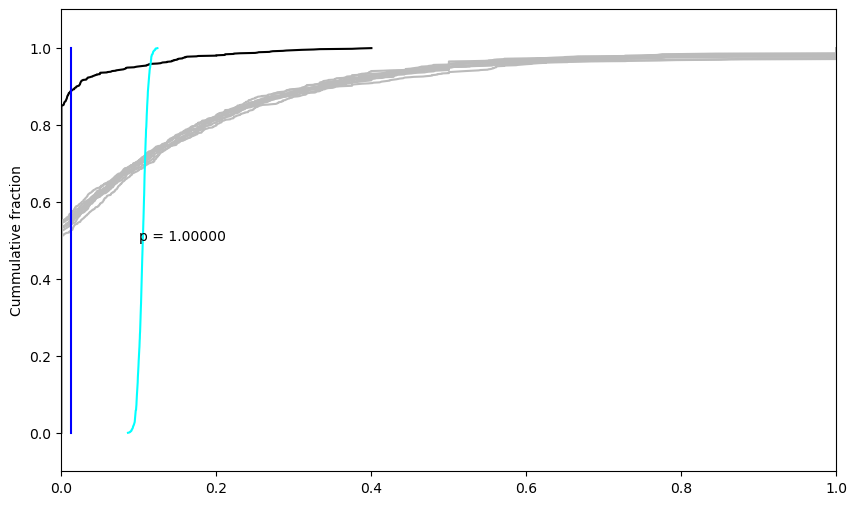

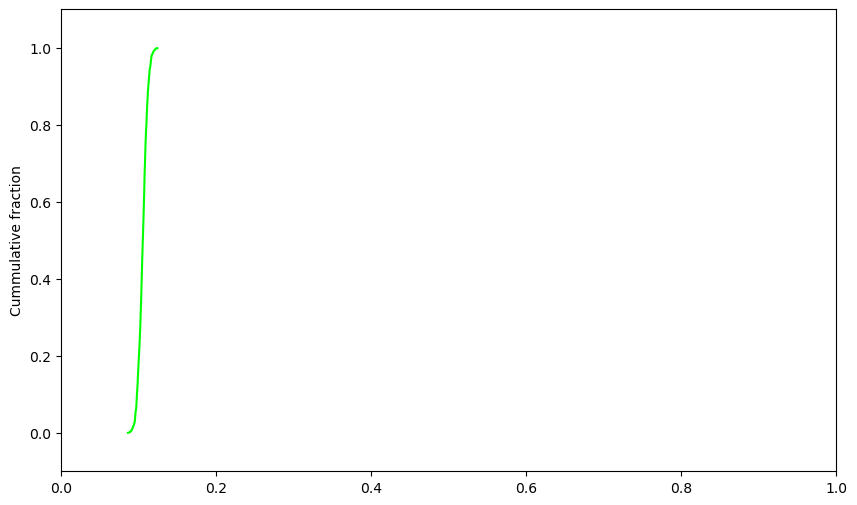

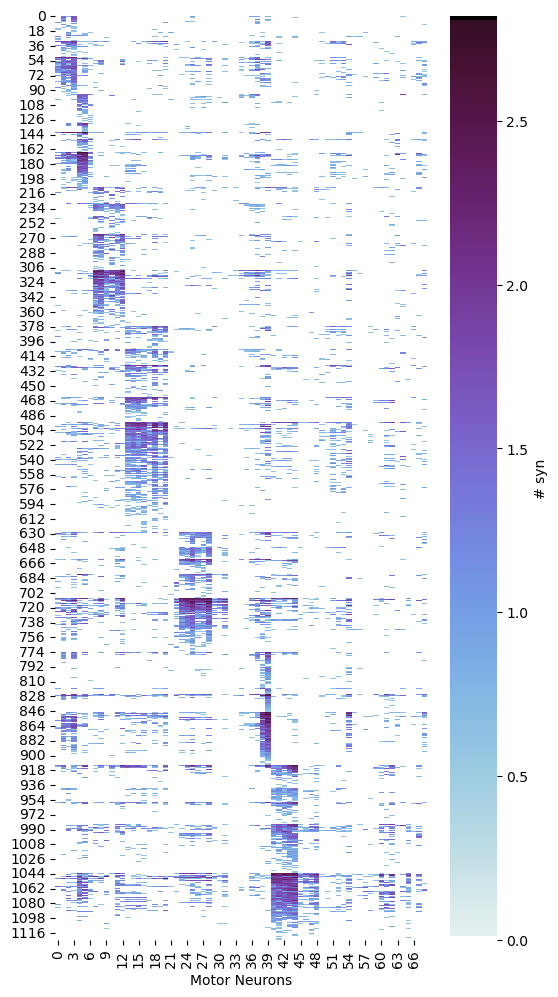

In [122]:
antagonists_dict = {
    'coxa_promote':'coxa_posterior',
    'coxa_rotate_adduct':'coxa_posterior',
    'coxa_posterior':['coxa_promote','coxa_rotate_adduct'],
    'trochanter_extend':'trochanter_flex',
    'trochanter_flex':'trochanter_extend',
    'tibia_extend':'tibia_ta_flex_A',
    'tibia_ta_flex_A':'tibia_extend',
}

# Just take the rows that have an antagonist
with_ant_df = pre_to_mn_pref_df.droplevel(['cell_class','NT','classification_system','cell_type','segID'])
with_ant_df = with_ant_df.loc[[i for i in antagonists_dict.keys()]]

shuffled_ant_df = with_ant_df.copy()
# compute the groupby prefs
pref_total_df = shuffled_ant_df.T.groupby(level='preferred_pool',observed=True).sum().T
pref_strength_df = pref_total_df.div(pref_total_df.sum(axis=1),axis=0)

# loop over mods
for mod in antagonists_dict:
    antagonists = pref_strength_df.loc[mod,([True if i in antagonists_dict[mod] else False for i in pref_strength_df.columns.get_level_values('preferred_pool')])].sum(axis=1)
    ant_distr_dict[mod] = np.ravel(antagonists.values)
ant_pref_vals = np.concatenate(list(ant_distr_dict.values()),axis=0)
ant_pref_mean = ant_pref_vals.mean()
print('mean antagonist pref: {}'.format(ant_pref_mean))
ax = plot_shuf_cdf(ant_pref_vals,color = '#000000',ref_x=None, fn=None,fignum=1,title=None)


N = 1000
rng = np.random.default_rng()
# create a N X N matrix of antagonist values to put the antagonists in, run stats afterward
antagonist_prefs = np.zeros([with_ant_df.shape[0],N])
antagonist_means = np.zeros([1,N])

for c in range(N):
    mixupmat = with_ant_df.to_numpy().copy()
    mixup = mix_up_columns_under_mask(mixupmat,mask=None,rng=rng)
    # shuffled_ant_df = pd.DataFrame(mixup,columns=with_ant_df.columns,index=with_ant_df.index)
    shuffled_ant_df.loc[:,:] = mixup

    # compute the groupby prefs
    pref_total_df = shuffled_ant_df.T.groupby(level='preferred_pool',observed=True).sum().T
    pref_strength_df = pref_total_df.div(pref_total_df.sum(axis=1),axis=0)

    # loop over mods
    for mod in antagonists_dict:
        antagonists = pref_strength_df.loc[mod,([True if i in antagonists_dict[mod] else False for i in pref_strength_df.columns.get_level_values('preferred_pool')])].sum(axis=1)
        ant_distr_dict[mod] = np.ravel(antagonists.values)
    ant_pref_vals = np.concatenate(list(ant_distr_dict.values()),axis=0)
    antagonist_means[:,c] = ant_pref_vals.mean()
    antagonist_prefs[:,c] = ant_pref_vals

    if np.mod(c,100)==0:
            print(c)
            plot_shuf_cdf(antagonist_prefs[:,c],color = '#BBBBBB',ref_x=None, fn=None,fignum=1,title=None,ax=ax)

plot_shuf_cdf(antagonist_means[0],color = '#00FFFF',ref_x=ant_pref_mean, fn='antagonist_pref_under_shuffling',fignum=1,title=None,ax=ax)
print('mean antagonist preference = {}'.format(antagonist_means[0].mean()))
print(antagonist_means.mean())
sem = np.std(antagonist_means, ddof=1) / np.sqrt(len(antagonist_means))
print(sem)

print((np.ravel(antagonist_prefs)==0).sum()/len(np.ravel(antagonist_prefs)))
ax = plot_shuf_cdf(antagonist_means[0],color = '#00FF00',ref_x=None, fn=None,fignum=2,title=None)
plt.show()

fig = plt.figure(figsize = [6,12])
ax = sns.heatmap(np.log10(with_ant_df.values+1), cmap=utils.white_dense())
# ax.xaxis.set_ticks_position('top')
cbar = ax.collections[0].colorbar
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

cbar.set_label(label = '# syn')
plt.xlabel('Motor Neurons')
plt.show()

## Over all synapses onto a module from all module preferring preMNs

In [123]:
mod_pref_total_df = pre_to_mn_pref_df.T.groupby(level='preferred_pool',observed=True).sum().T
mod_pref_total_df = mod_pref_total_df.groupby(level='preferred_pool',observed=True).sum()
mod_pref_total_df = mod_pref_total_df.loc[pool_keys]


(12,)
(1,)
(12,)
(1,)
(11,)
(2,)
(12,)
(1,)
(12,)
(1,)
(12,)
(1,)
(12,)
(1,)
(83,)
(8,)


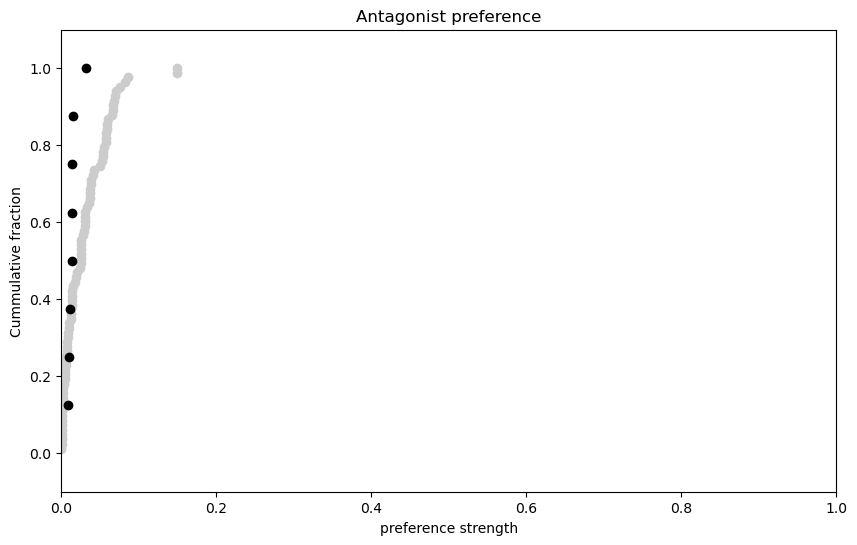

In [124]:

denom = mod_pref_total_df.sum(axis=1)
mod_pref_strength_df = mod_pref_total_df.div(denom,axis=0)

mod_pref_strength_df

antagonists_dict = {
    'coxa_promote':'coxa_posterior',
    'coxa_rotate_adduct':'coxa_posterior',
    'coxa_posterior':['coxa_promote','coxa_rotate_adduct'],
    'trochanter_extend':'trochanter_flex',
    'trochanter_flex':'trochanter_extend',
    'tibia_extend':'tibia_ta_flex_A',
    'tibia_ta_flex_A':'tibia_extend',
}
ant_distr_dict = {}
other_distr_dict = {}

for mod in antagonists_dict.keys():
    others = mod_pref_strength_df.loc[mod,((mod_pref_strength_df.columns.get_level_values('preferred_pool') != mod) & ([True if i not in antagonists_dict[mod] else False for i in mod_pref_strength_df.columns.get_level_values('preferred_pool')]))]
    other_distr_dict[mod] = np.ravel(others.values)
    antagonists = mod_pref_strength_df.loc[mod,([True if i in antagonists_dict[mod] else False for i in mod_pref_strength_df.columns.get_level_values('preferred_pool')])]
    ant_distr_dict[mod] = np.ravel(antagonists.values)
    print(others.shape)
    print(antagonists.shape)

others_prefs = np.concatenate(list(other_distr_dict.values()), axis=0)
print(others_prefs.shape)
antagonist_prefs = np.concatenate(list(ant_distr_dict.values()), axis=0)
print(antagonist_prefs.shape)


fig = plt.figure(figsize=(10, 6))
ax = plt.subplot2grid((1,1),(0,0))
ax.set_ylim([-.1, 1.1])
ax.set_xlim([0, 1])

ax.set_ylabel('Cummulative fraction')
ax.set_xlabel('preference strength')
ax.set_title('Antagonist preference')

y_other = (np.array(range(len(others_prefs))).astype(float)+1)/len(others_prefs)
y_ants = (np.array(range(len(antagonist_prefs))).astype(float)+1)/len(antagonist_prefs)
ax.scatter(sorted(others_prefs),y_other,color='#CCCCCC')
ax.scatter(sorted(antagonist_prefs),y_ants,color='#000000')
    # fig.savefig('./figpanels/{}.svg'.format(fn),format='svg')

## Preference strength heat map

In [133]:
lbls = [i for i in pref_strength_df.columns.values]
pref_total_df = pre_to_mn_pref_df.T.groupby(level='preferred_pool',observed=True).sum().T
denom = pref_total_df.sum(axis=1)
pref_strength_df = pref_total_df.div(denom,axis=0)
# pref_strength_df = pref_strength_df.droplevel(['cell_class','NT','classification_system','cell_type','segID'])
pref_strength_df = pref_strength_df.droplevel(['cell_class','NT','classification_system','cell_type'])
pref_strength_df.head()

preferred_pool                     coxa_promote  coxa_rotate_adduct  \
preferred_pool segID                                                  
coxa_promote   648518346493883193      0.701923                 0.0   
               648518346497743463      0.920455                 0.0   
               648518346494476087      0.895349                 0.0   
               648518346507377529      1.000000                 0.0   
               648518346494232199      0.625000                 0.0   

preferred_pool                     coxa_posterior  trochanter_extend  \
preferred_pool segID                                                   
coxa_promote   648518346493883193             0.0                0.0   
               648518346497743463             0.0                0.0   
               648518346494476087             0.0                0.0   
               648518346507377529             0.0                0.0   
               648518346494232199             0.0                0.0   

preferred_pool                     trochanter_flex  femur_reduct  \
preferred_pool segID                                               
coxa_promote   648518346493883193         0.067308      0.153846   
               648518346497743463         0.045455      0.000000   
               648518346494476087         0.069767      0.034884   
               648518346507377529         0.000000      0.000000   
               648518346494232199         0.000000      0.250000   

preferred_pool                     tibia_extend  tibia_ta_flex_A  \
preferred_pool segID                                               
coxa_promote   648518346493883193      0.048077         0.000000   
               648518346497743463      0.000000         0.034091   
               648518346494476087      0.000000         0.000000   
               648518346507377529      0.000000         0.000000   
               648518346494232199      0.125000         0.000000   

preferred_pool                     tibia_ta_flex_B  tibia_ta_flex_C  ltm_A  \
preferred_pool segID                                                         
coxa_promote   648518346493883193              0.0              0.0    0.0   
               648518346497743463              0.0              0.0    0.0   
               648518346494476087              0.0              0.0    0.0   
               648518346507377529              0.0              0.0    0.0   
               648518346494232199              0.0              0.0    0.0   

preferred_pool                     ltm_B  tarsus_depress_medial  \
preferred_pool segID                                              
coxa_promote   648518346493883193    0.0                    0.0   
               648518346497743463    0.0                    0.0   
               648518346494476087    0.0                    0.0   
               648518346507377529    0.0                    0.0   
               648518346494232199    0.0                    0.0   

preferred_pool                     tarsus_depress_ventralU  
preferred_pool segID                                        
coxa_promote   648518346493883193                 0.028846  
               648518346497743463                 0.000000  
               648518346494476087                 0.000000  
               648518346507377529                 0.000000  
               648518346494232199                 0.000000

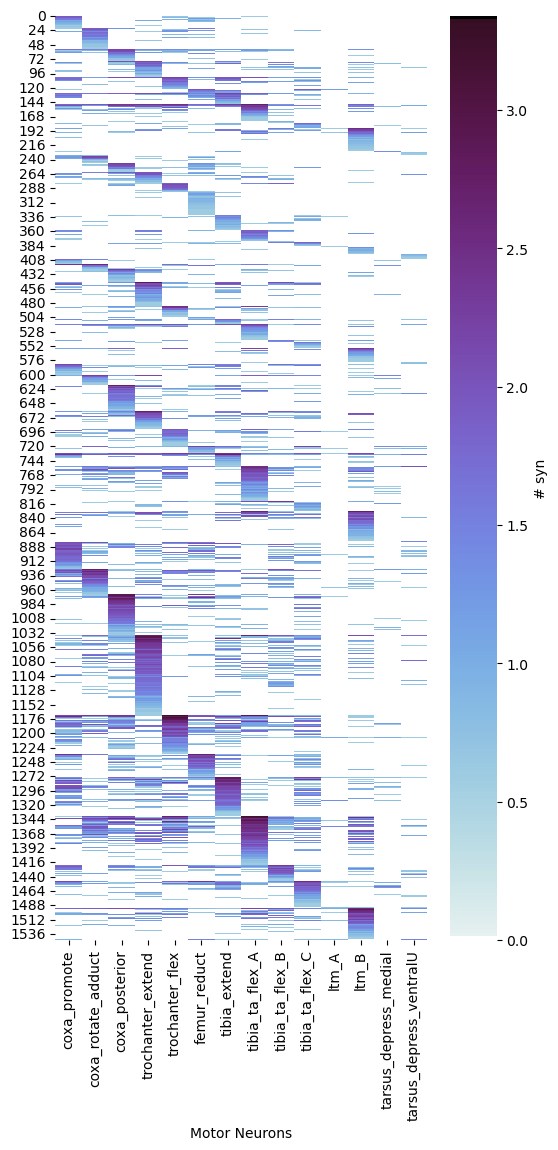

In [134]:
fig = plt.figure(figsize = [6,12])
ax = sns.heatmap(np.log10(pref_total_df.values+1), xticklabels=lbls, cmap=utils.white_dense())
# ax.xaxis.set_ticks_position('top')
cbar = ax.collections[0].colorbar
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

cbar.set_label(label = '# syn')
plt.xlabel('Motor Neurons')
plt.show()

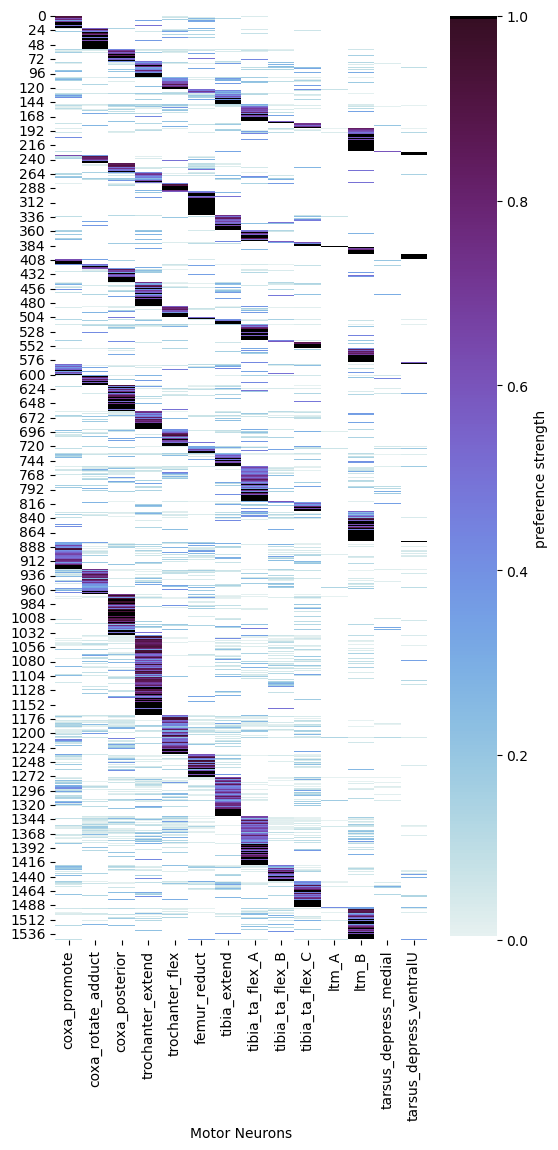

In [135]:
fig = plt.figure(figsize = [6,12])
ax = sns.heatmap(pref_strength_df.values, xticklabels=lbls, cmap=utils.white_dense())
# ax.xaxis.set_ticks_position('top')
cbar = ax.collections[0].colorbar
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

cbar.set_label(label = 'preference strength')
plt.xlabel('Motor Neurons')
plt.show()

## Summed preference strength

In [137]:
mod_pref_total_df
pd.Series(np.diag(mod_pref_total_df), index=[mod_pref_total_df.index, mod_pref_total_df.columns]).sum()/mod_pref_total_df.sum().sum()

0.6224798529619681

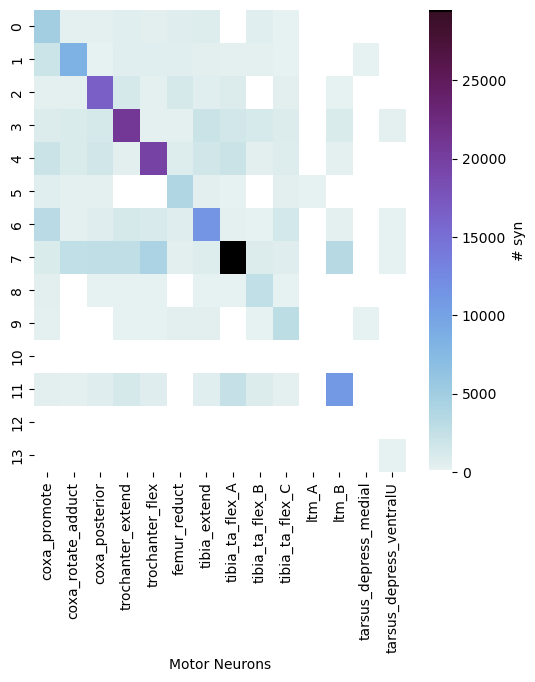

In [138]:
fig = plt.figure(figsize = [6,6])
ax = sns.heatmap(mod_pref_total_df.values, xticklabels=lbls, cmap=utils.white_dense())
# ax.xaxis.set_ticks_position('top')
cbar = ax.collections[0].colorbar
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

cbar.set_label(label = '# syn')
plt.xlabel('Motor Neurons')
plt.show()

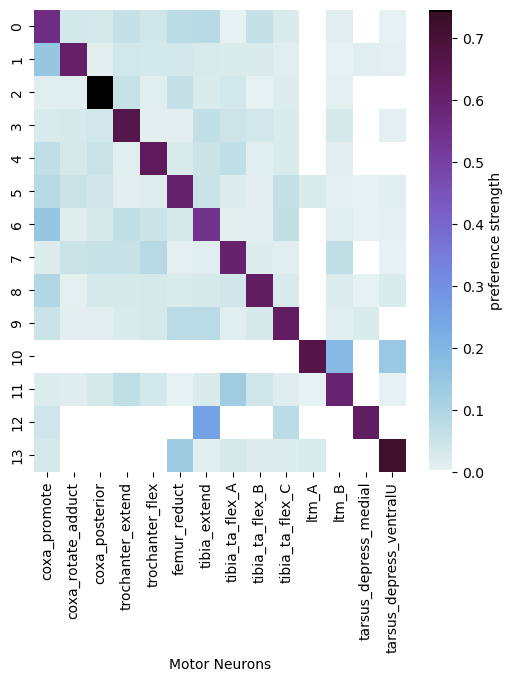

In [139]:
fig = plt.figure(figsize = [6,6])
ax = sns.heatmap(mod_pref_strength_df.values, xticklabels=lbls, cmap=utils.white_dense())
# ax.xaxis.set_ticks_position('top')
cbar = ax.collections[0].colorbar
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

cbar.set_label(label = 'preference strength')
plt.xlabel('Motor Neurons')
plt.show()

# Figure 5h preference strength for secondary antagonist modules

row pref is coxa_promote; row_nonpreferred has no idx ['coxa_promotion', 'coxa_rotator_adductor']
row pref is coxa_promote; row_nonpreferred has no idx ['coxa_promotion', 'coxa_rotator_adductor']
row pref is trochanter_extend; row_nonpreferred has no idx ['coxa_promotion', 'coxa_rotator_adductor']
row pref is trochanter_extend; row_nonpreferred has no idx ['coxa_promotion', 'coxa_rotator_adductor']
row pref is trochanter_extend; row_nonpreferred has no idx ['coxa_promotion', 'coxa_rotator_adductor']
row pref is trochanter_extend; row_nonpreferred has no idx ['coxa_promotion', 'coxa_rotator_adductor']
row pref is trochanter_extend; row_nonpreferred has no idx trochanter_extend
row pref is trochanter_extend; row_nonpreferred has no idx ['coxa_promotion', 'coxa_rotator_adductor']
row pref is trochanter_extend; row_nonpreferred has no idx ['coxa_promotion', 'coxa_rotator_adductor']
row pref is trochanter_extend; row_nonpreferred has no idx ['coxa_promotion', 'coxa_rotator_adductor']
row pr

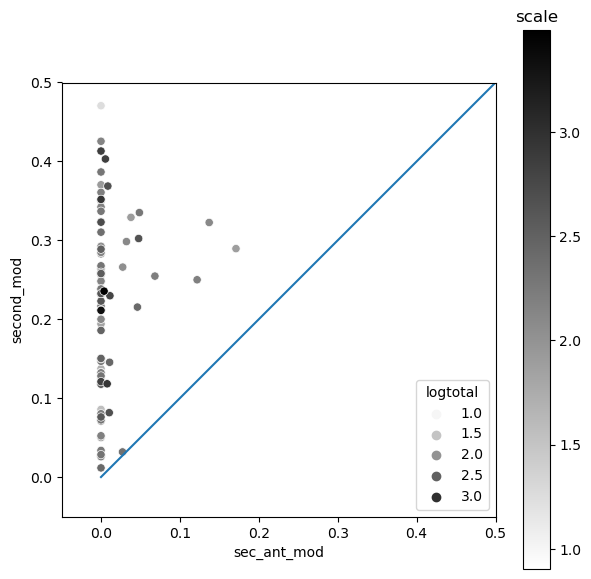

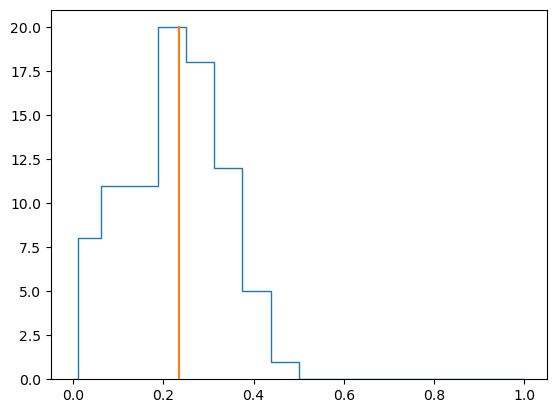

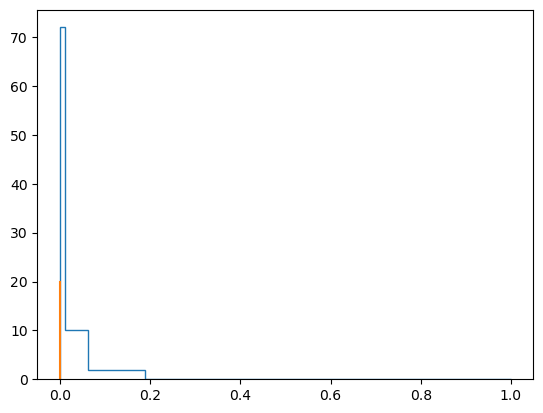

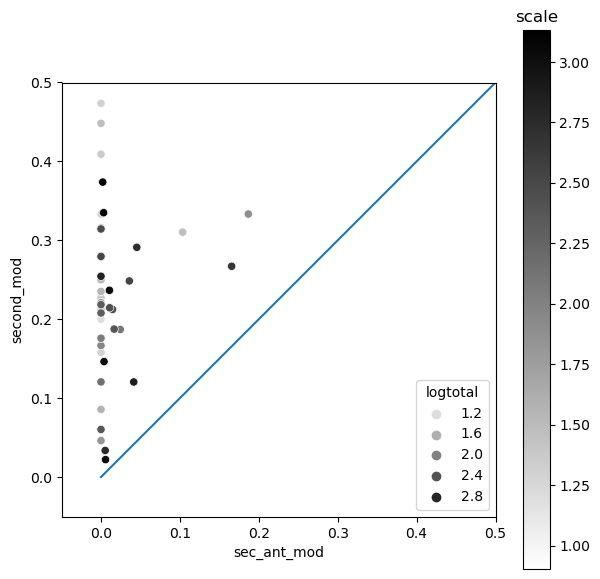

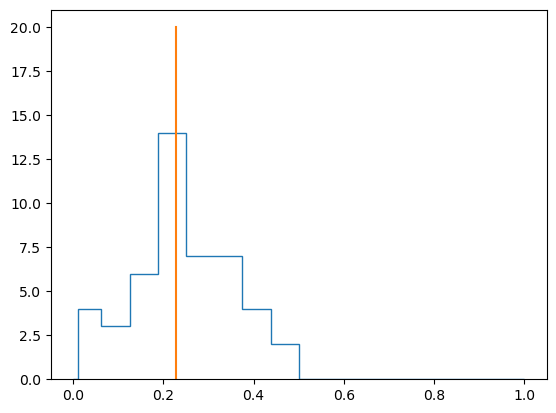

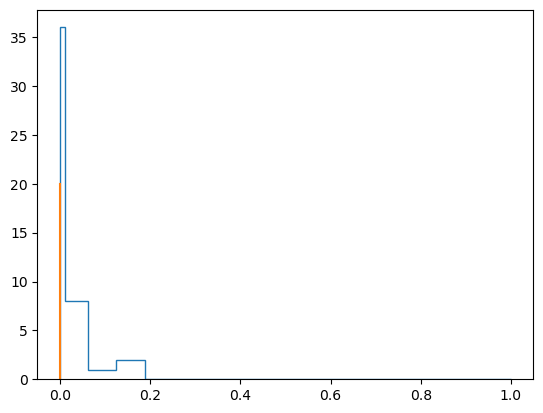

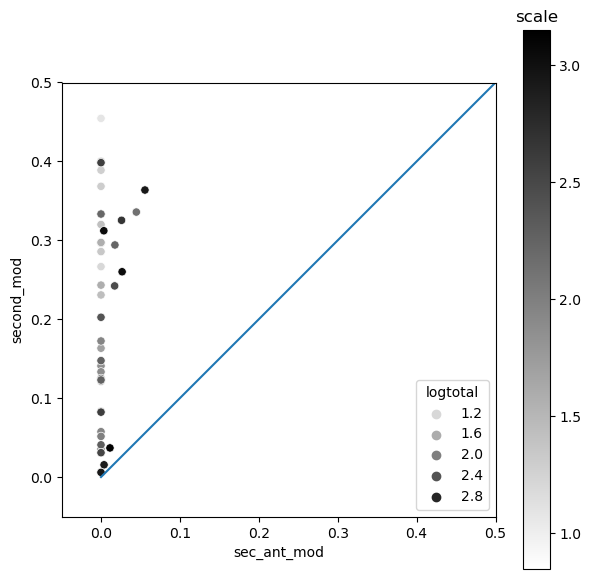

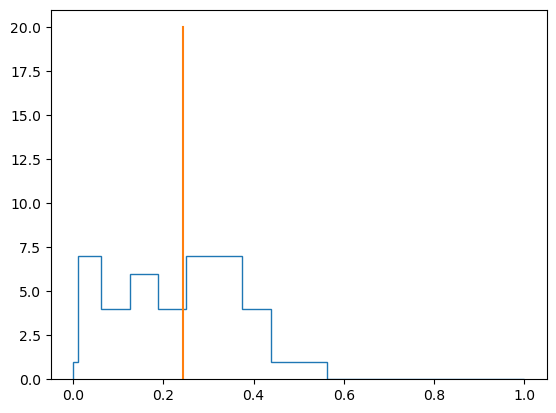

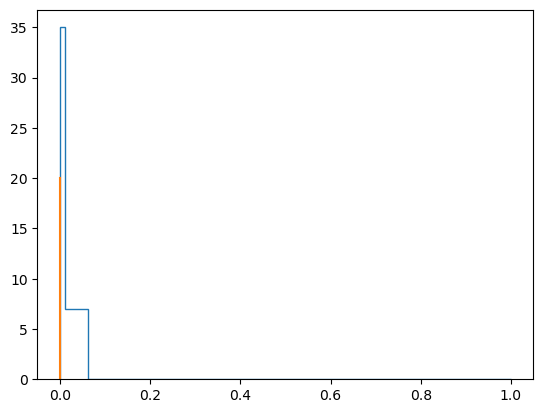

In [164]:
pref_total_df = pre_to_mn_pref_df.T.groupby(level='preferred_pool',observed=True).sum().T
denom = pref_total_df.sum(axis=1)
pref_strength_df = pref_total_df.div(denom,axis=0)
secmodpref_all_df = None
# look only at Ach, but do it for all three
for NT in ['Ach','GABA','Glu']:
    select_local_df = pref_strength_df.loc[('local',All,NT,All,All,All)]
    select_local_total_df = pref_total_df.loc[('local',All,NT,All,All,All)]
    select_local_total_df = select_local_total_df.loc[select_local_df.max(axis=1)<1,:]
    select_local_df = select_local_df.loc[select_local_df.max(axis=1)<1,:]

    second_mod_pref_df = pd.DataFrame(index=select_local_df.index, columns=['second_mod', 'sec_ant_mod'])
    second_mod_pref_df

    for idx,row in select_local_df.iterrows():
        row_nonpreferred = row.loc[row.index.get_level_values('preferred_pool') != idx[0]]
        # other_mods = row_nonpreferred.index.get_level_values('preferred_pool').to_list()
        secnd_mod = row_nonpreferred.loc[row_nonpreferred==row_nonpreferred.max()].index.get_level_values('preferred_pool').to_list()[0]
        if secnd_mod in antagonists_dict.keys():
            if isinstance(antagonists_dict[secnd_mod],list):
                # print(secnd_mod)
                # print(antagonists_dict[secnd_mod])
                try:
                    second_mod_pref_df.loc[idx,'sec_ant_mod'] = row_nonpreferred.loc[antagonists_dict[secnd_mod]].sum()
                except KeyError:
                    print('row pref is {}; row_nonpreferred has no idx {}'.format(idx[0],antagonists_dict[secnd_mod]))
                    continue
            else: 
                try:
                    second_mod_pref_df.loc[idx,'sec_ant_mod'] = row_nonpreferred.loc[antagonists_dict[secnd_mod]]
                except KeyError:
                    print('row pref is {}; row_nonpreferred has no idx {}'.format(idx[0],antagonists_dict[secnd_mod]))
                    continue
            second_mod_pref_df.loc[idx,'second_mod'] = row_nonpreferred.loc[secnd_mod]
            
            
    second_mod_pref_df = second_mod_pref_df.loc[~second_mod_pref_df.isna().any(axis=1)]

    print('{}: {}'.format(NT,second_mod_pref_df.shape))
    second_mod_pref_df['logtotal'] = np.log10(select_local_total_df.sum(axis=1)+1)
    if secmodpref_all_df is None:
        secmodpref_all_df = second_mod_pref_df
    else:
        secmodpref_all_df = pd.concat([secmodpref_all_df,second_mod_pref_df],axis=0)

    from matplotlib.cm import ScalarMappable

    f, ax = plt.subplots(figsize=(7, 7))
    # ax.scatter(pref_agonist_antag_pref.agonist,pref_agonist_antag_pref.antagonist)
    # sns.scatterplot(data=paa_pref.sort_values(by='total',axis=0,ascending=True), x='antagonist', y='agonist', hue="total", style='preferred_pool',ax=ax)
    sns.scatterplot(data=second_mod_pref_df.sort_values(by='logtotal',axis=0,ascending=True), x='sec_ant_mod', y='second_mod', hue="logtotal", palette='gray_r',ax=ax)
    # sns.rugplot(data=paa_pref, x='antagonist', height=0.025, expand_margins=True, palette=None, hue_order=None, hue_norm=None, legend=True, ax=ax)
    # sns.rugplot(data=paa_pref, y='agonist', height=0.025, expand_margins=True, palette=None, hue_order=None, hue_norm=None, legend=True, ax=ax)
    ax.plot([0,0.5],[0, 0.5])
    # sns.scatterplot(data=paa_pref, x='antagonist', y='agonist', hue="total", ax=ax)
    ax.set_ylim([-0.05,.5])
    ax.set_xlim([-0.05,.5])
    ax.set_aspect('equal', adjustable='box')

    norm = plt.Normalize(second_mod_pref_df.logtotal.values.min(), second_mod_pref_df.logtotal.values.max())

    sm =  ScalarMappable(norm=norm,cmap=cos_cmap)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.ax.set_title("scale")

    f.savefig('./figpanels/agonist_vs_antagonist_ru_{}.svg'.format(NT),format='svg')


    fig,ax = plt.subplots()
    e = np.sort(np.append(np.array(range(16+1))/16,.01))
    h,e = np.histogram(second_mod_pref_df['second_mod'], bins=e, range=None, density=False, weights=None)
    ax.stairs(h, e, label='each_prefs')
    ax.plot(np.median(second_mod_pref_df['second_mod'])* np.array([1, 1,]),[0.,20])
    fig.savefig('./figpanels/pref_hist_second_module_{}.svg'.format(NT))
    print('second pref median: {} ({})'.format(np.median(second_mod_pref_df['second_mod']),float(np.sum(second_mod_pref_df['second_mod']==0))/len(second_mod_pref_df['second_mod'])))

    # ax = sns.violinplot(data=others_prefs[others_prefs<.8], orient='vertical',scale='area', cut=0,bw=.25)

    # antagonist_prefs
    # sns.violinplot(data=antagonist_prefs, orient='vertical',scale='area', cut=0,bw=.25)

    fig,ax = plt.subplots()
    e = np.sort(np.append(np.array(range(16+1))/16,.01))
    h,e = np.histogram(second_mod_pref_df['sec_ant_mod'], bins=e, range=None, density=False, weights=None)
    ax.stairs(h, e, label='each_prefs')
    ax.plot(np.median(second_mod_pref_df['sec_ant_mod'])* np.array([1, 1,]),[0.,20])
    fig.savefig('./figpanels/pref_hist_second_module_antagonist_{}.svg'.format(NT))
    print('antagonist median: {} ({})'.format(np.median(second_mod_pref_df['sec_ant_mod']),float(np.sum(second_mod_pref_df['sec_ant_mod']==0))/len(second_mod_pref_df['sec_ant_mod'])))

    # second_mod_dict[NT] = second_mod_pref_df['second_mod']



second pref median: 0.23529411764705882 (0.0)
antagonist median: 0.0 (0.7542857142857143)


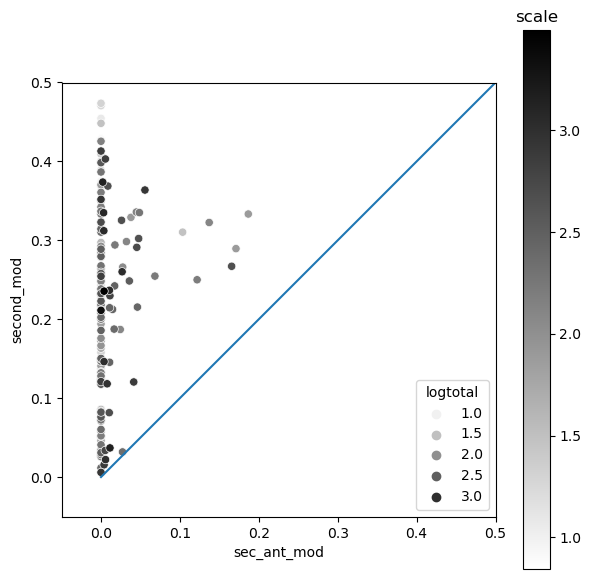

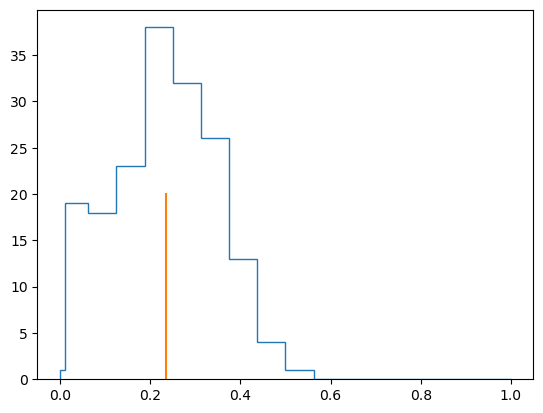

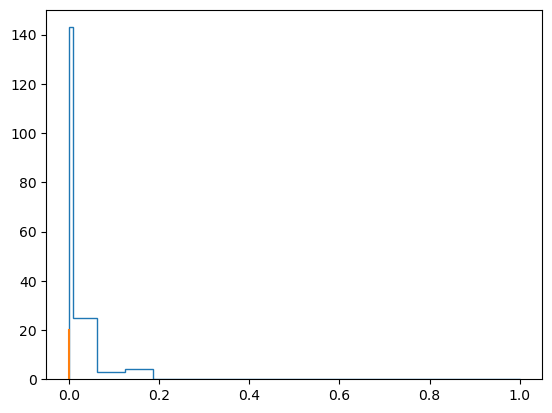

In [165]:
secmodpref_all_df

from matplotlib.cm import ScalarMappable

f, ax = plt.subplots(figsize=(7, 7))
sns.scatterplot(data=secmodpref_all_df.sort_values(by='logtotal',axis=0,ascending=True), x='sec_ant_mod', y='second_mod', hue="logtotal", palette='gray_r',ax=ax)
ax.plot([0,0.5],[0, 0.5])
ax.set_ylim([-0.05,.5])
ax.set_xlim([-0.05,.5])
ax.set_aspect('equal', adjustable='box')

norm = plt.Normalize(secmodpref_all_df.logtotal.values.min(), secmodpref_all_df.logtotal.values.max())

sm =  ScalarMappable(norm=norm,cmap=cos_cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.ax.set_title("scale")

f.savefig('./figpanels/agonist_vs_antagonist_all.svg',format='svg')


fig,ax = plt.subplots()
e = np.sort(np.append(np.array(range(16+1))/16,.01))
h,e = np.histogram(secmodpref_all_df['second_mod'], bins=e, range=None, density=False, weights=None)
ax.stairs(h, e, label='each_prefs')
ax.plot(np.median(secmodpref_all_df['second_mod'])* np.array([1, 1,]),[0.,20])
fig.savefig('./figpanels/pref_hist_second_module_all.svg')
print('second pref median: {} ({})'.format(np.median(secmodpref_all_df['second_mod']),float(np.sum(secmodpref_all_df['second_mod']==0))/len(secmodpref_all_df['second_mod'])))

fig,ax = plt.subplots()
e = np.sort(np.append(np.array(range(16+1))/16,.01))
h,e = np.histogram(secmodpref_all_df['sec_ant_mod'], bins=e, range=None, density=False, weights=None)
ax.stairs(h, e, label='each_prefs')
ax.plot(np.median(secmodpref_all_df['sec_ant_mod'])* np.array([1, 1,]),[0.,20])
fig.savefig('./figpanels/pref_hist_second_module_antagonist_all.svg')
print('antagonist median: {} ({})'.format(np.median(secmodpref_all_df['sec_ant_mod']),float(np.sum(secmodpref_all_df['sec_ant_mod']==0))/len(secmodpref_all_df['sec_ant_mod'])))




In [174]:
# off_row = select_local_total_df.loc[second_mod_pref_df.loc[second_mod_pref_df['sec_ant_mod']>second_mod_pref_df['second_mod']].index[0]]
# correction = (off_row/off_row.sum())
# correction.iloc[[0,1]].sum()

IndexError: index 0 is out of bounds for axis 0 with size 0

# Preference strength across cell_class

In [175]:
pre_to_mn_pref_df.index.get_level_values("cell_class").unique()

CategoricalIndex(['descending', 'sensory', 'ascending', 'intersegmental',
                  'local'],
                 categories=['descending', 'sensory', 'ascending', 'intersegmental', 'local'], ordered=True, dtype='category', name='cell_class')

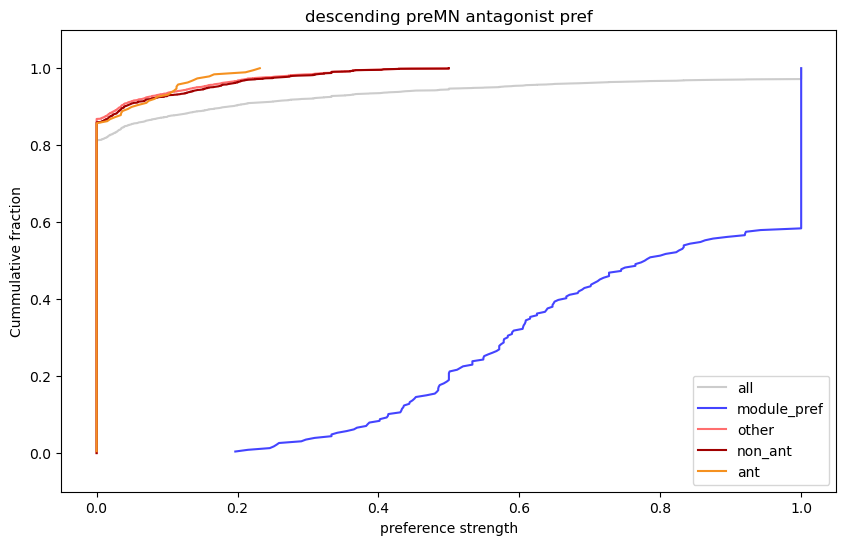

0.7796074517631404
0.42035398230088494


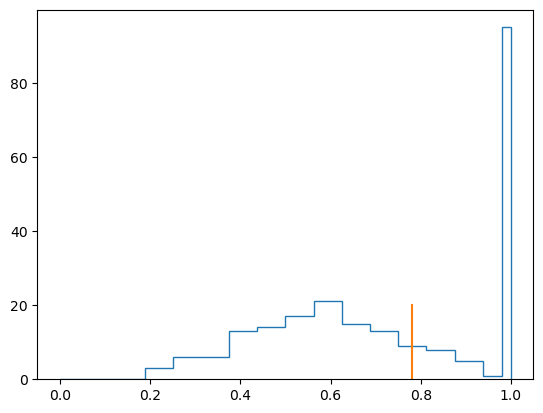

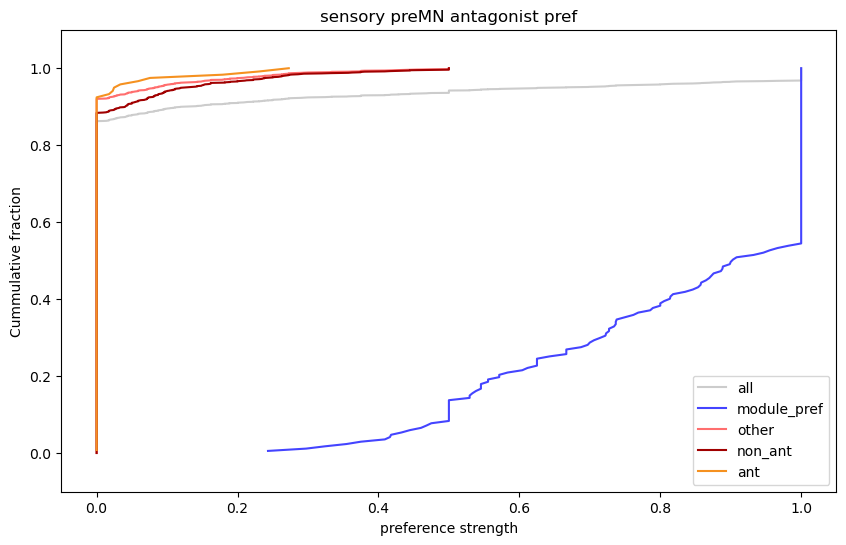

0.9032258064516129
0.46107784431137727


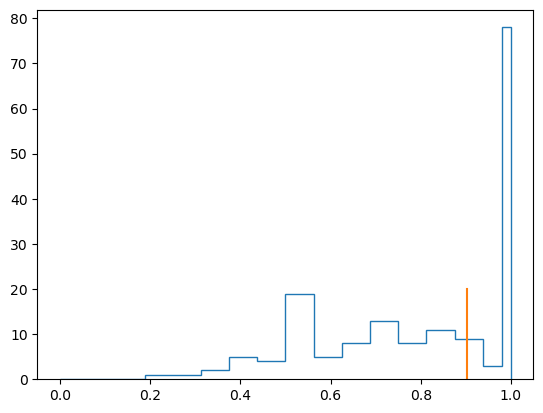

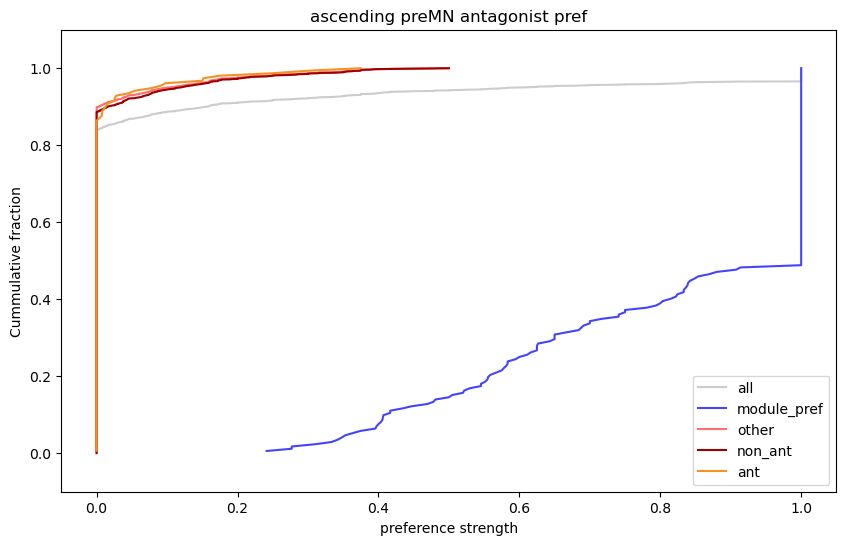

1.0
0.5174418604651163
trochanter_flex


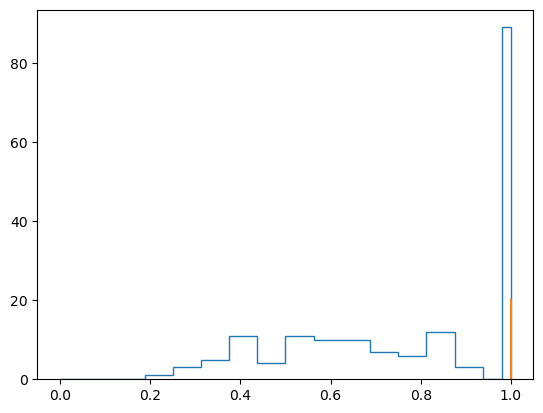

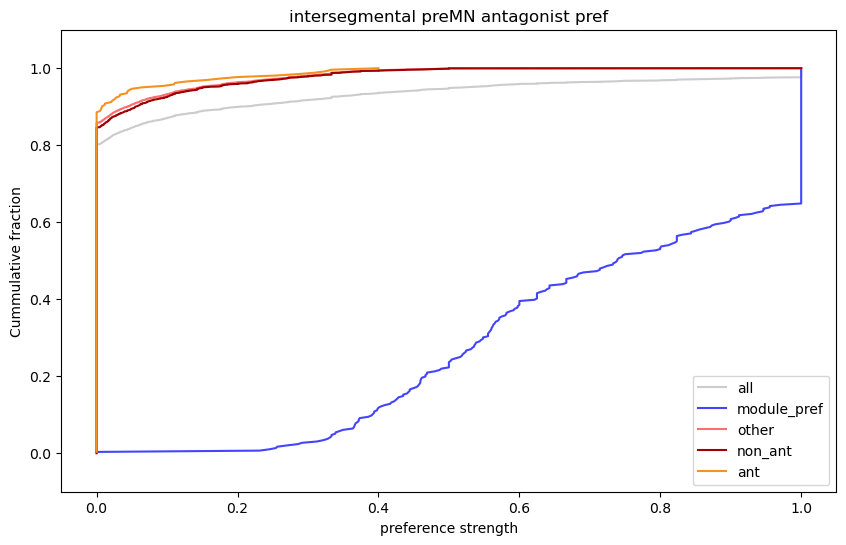

0.7390399487709964
0.3547297297297297


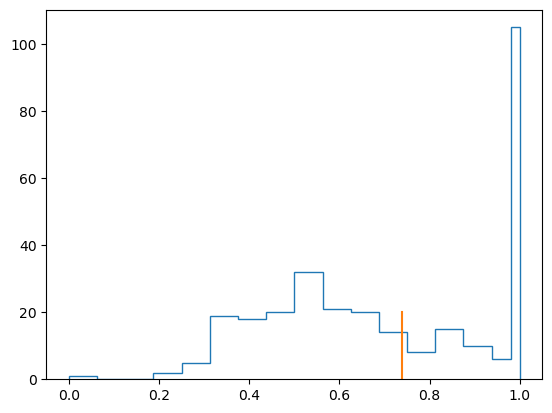

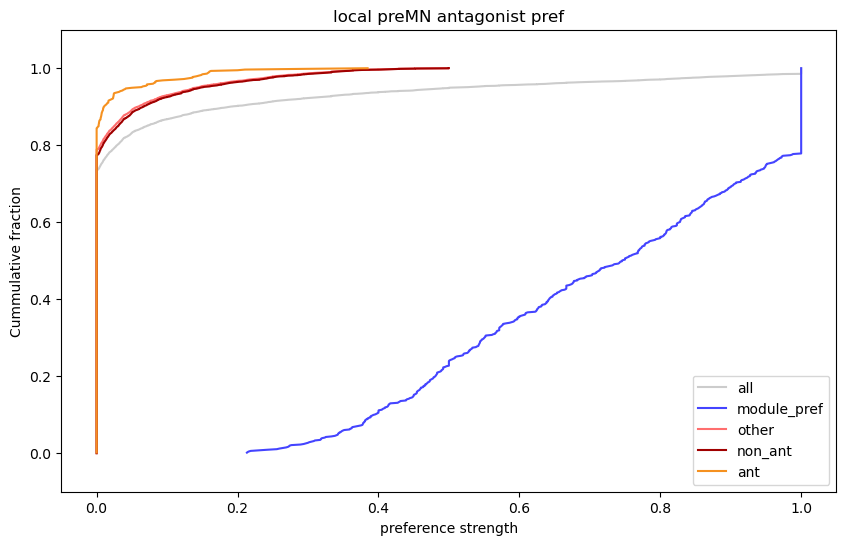

0.7462212486308872
0.22289156626506024


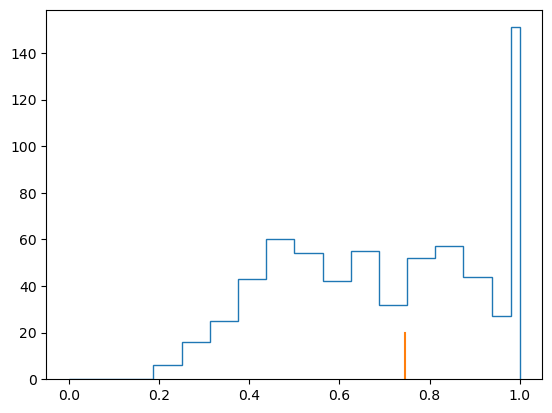

In [176]:
# cell_class = 'intersegmental'
class_pref_dict = {}
for cell_class in pre_to_mn_pref_df.index.get_level_values("cell_class").unique():
    df = pre_to_mn_pref_df.loc[(cell_class,All,All,All,All),:]

    pref_total_df = df.T.groupby(level='preferred_pool',observed=True).sum().T
    denom = pref_total_df.sum(axis=1)
    pref_strength_df = pref_total_df.div(denom,axis=0)
    # pref_strength_df = pref_strength_df.droplevel(['cell_class','NT','classification_system','cell_type','segID'])
    pref_strength_df = pref_strength_df.droplevel(['cell_class','NT','classification_system','cell_type'])

    ant_distr_dict = {}
    other_distr_dict = {}
    eachother_distr_dict = {}
    each_distr_dict = {}

    all_prefs = np.ravel(pref_strength_df.values)
    # print(all_prefs.shape)
    for mod in module_names:
        try: 
            each = pref_strength_df.loc[mod,((pref_strength_df.columns.get_level_values('preferred_pool') == mod))]
            each_distr_dict[mod] = np.ravel(each.values)
            eachothers = pref_strength_df.loc[mod,((pref_strength_df.columns.get_level_values('preferred_pool') != mod))]
            eachother_distr_dict[mod] = np.ravel(eachothers.values)
            if mod in antagonists_dict.keys():
            
                others = pref_strength_df.loc[mod,((pref_strength_df.columns.get_level_values('preferred_pool') != mod) & ([True if i not in antagonists_dict[mod] else False for i in pref_strength_df.columns.get_level_values('preferred_pool')]))]
                #others = pref_strength_df.loc[mod,((pref_strength_df.columns.get_level_values('preferred_pool') != mod))]
                other_distr_dict[mod] = np.ravel(others.values)
                antagonists = pref_strength_df.loc[mod,([True if i in antagonists_dict[mod] else False for i in pref_strength_df.columns.get_level_values('preferred_pool')])]
                ant_distr_dict[mod] = np.ravel(antagonists.values)
                if np.any(np.ravel(other_distr_dict[mod]==1)):
                    print(mod)
                    weird_others = others.copy()
                # print(others.shape)
                # print(antagonists.shape)
        except:
            continue

    each_prefs = np.concatenate(list(each_distr_dict.values()), axis=0)
    class_pref_dict[cell_class] = each_prefs
    eachothers_prefs = np.concatenate(list(eachother_distr_dict.values()), axis=0)
    others_prefs = np.concatenate(list(other_distr_dict.values()), axis=0)
    antagonist_prefs = np.concatenate(list(ant_distr_dict.values()), axis=0)

    # print(all_prefs.shape)
    # print(each_prefs.shape)
    # print(eachothers_prefs.shape)
    # print(others_prefs.shape)
    # print(antagonist_prefs.shape)

    # Calculate the interquartile range (IQR)
    iqr = np.percentile(antagonist_prefs, 75) - np.percentile(antagonist_prefs, 25)

    # Calculate the number of bins using Freeman Diaconis rule
    n_bins = int(2 * (iqr / np.power(len(antagonist_prefs), 1/3)))

    # Plot the histogram
    # plt.hist(data, bins=n_bins, edgecolor='black')

    fig = plt.figure(figsize=(10, 6))
    ax = plt.subplot2grid((1,1),(0,0))
    ax.set_ylim([-.1, 1.1])
    ax.set_xlim([-.05, 1.05])

    ax.set_ylabel('Cummulative fraction')
    ax.set_xlabel('preference strength')
    ax.set_title('{} preMN antagonist pref'.format(cell_class))

    y_all = (np.array(range(len(all_prefs))).astype(float)+1)/len(all_prefs)
    y_each = (np.array(range(len(each_prefs))).astype(float)+1)/len(each_prefs)
    y_eachothers = (np.array(range(len(eachothers_prefs))).astype(float)+1)/len(eachothers_prefs)
    y_other = (np.array(range(len(others_prefs))).astype(float)+1)/len(others_prefs)
    y_ants = (np.array(range(len(antagonist_prefs))).astype(float)+1)/len(antagonist_prefs)

    ax.plot(sorted(all_prefs),y_all,color='#CCCCCC',label='all')
    ax.plot(sorted(each_prefs),y_each,color='#4444FF',label='module_pref')
    ax.plot(sorted(eachothers_prefs),y_eachothers,color='#ff6e6e',label='other')
    ax.plot(sorted(others_prefs),y_other,color='#a00000',label='non_ant')
    ax.plot(sorted(antagonist_prefs),y_ants,color='#f59120',label='ant')
    
    ax.legend()
    plt.show()
    fig.savefig('./figpanels/pre_cdfs_etc_{}.svg'.format(cell_class),format='svg')

    # print(all_prefs.mean())
    # print(others_prefs.mean())
    # print(antagonist_prefs.mean())


    mwu_out = mannwhitneyu(antagonist_prefs,others_prefs)
    mwu_out

    fig,ax = plt.subplots()
    e = np.sort(np.append(np.array(range(16+1))/16,.98))
    h,e = np.histogram(each_prefs, bins=e, range=None, density=False, weights=None)
    ax.stairs(h, e, label='each_prefs')
    ax.plot(np.median(each_prefs)* np.array([1, 1,]),[0.,20])
    fig.savefig('./figpanels/pref_hist_{}.svg'.format(cell_class))
    print(np.median(each_prefs))
    print(float(np.sum(each_prefs==1))/len(each_prefs))

# Plot preference strength vs. total MN synpses

In [177]:
cell_class=='descending'

False

In [178]:
pre_to_mn_pref_df

side                                                                                                                                             L  \
nerve                                                                                                                                       Dorsal   
segment                                                                                                                                     thorax   
function                                                                                                                                     swing   
muscle                                                                                         tergopleural_promotor_pleural_promotor_miller_28_30   
rank                                                                                                                                             0   
segID                                                                                                                           648518346487756866   
module                                                                                                                                coxa_promote   
preferred_pool                                                                                                                        coxa_promote   
cell_class preferred_pool          NT   classification_system cell_type     segID                                                                    
descending coxa_promote            NaN  NaN                   NaN           648518346493883193                                                  0    
                                                                            648518346497743463                                                  0    
                                                                            648518346494476087                                                  0    
                                                                            648518346507377529                                                  0    
                                                                            648518346494232199                                                  0    
...                                                                                                                                            ...   
local      ltm_B                   GABA 19A                   19A_mid       648518346504149710                                                  0    
                                        09A                   09A           648518346490340104                                                  0    
                                   Ach  22A                   22A_posterior 648518346521544953                                                  0    
           tarsus_depress_medial   GABA 12B                   12B           648518346484940957                                                  0    
           tarsus_depress_ventralU Ach  03A                   03A           648518346491766952                                                  0    

side                                                                                                               \
nerve                                                                                                               
segment                                                                                                             
function                                                                                                            
muscle                                                                                                              
rank                                                                                                                
segID                                                                                          648518346491659326   
module                        

In [179]:
# Brake neuron, just curious
pre_to_mn_pref_df.loc[(All,All,All,All,All,648518346514066654)].sum(axis=1)
# pre_to_mn_pref_df.loc[('ascending',All,All,All,All)].to_csv('./dfs_saved/ascending_list.csv')

cell_class  preferred_pool  NT   classification_system  cell_type
ascending   ltm_B           NaN  NaN                    NaN          3
dtype: int64

(226,)
r = -0.3815717306228036, p = 3.0224252467894e-09


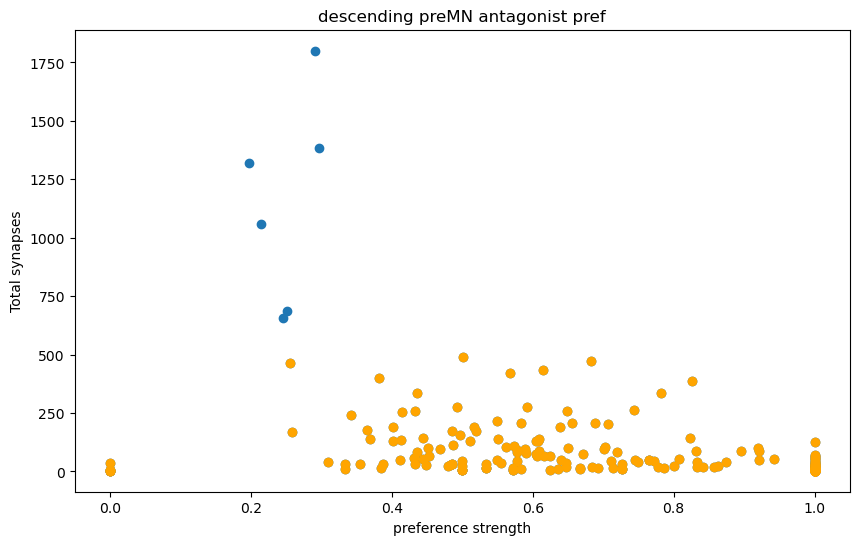

r = -0.13370400721368245, p = 0.0777334768473595


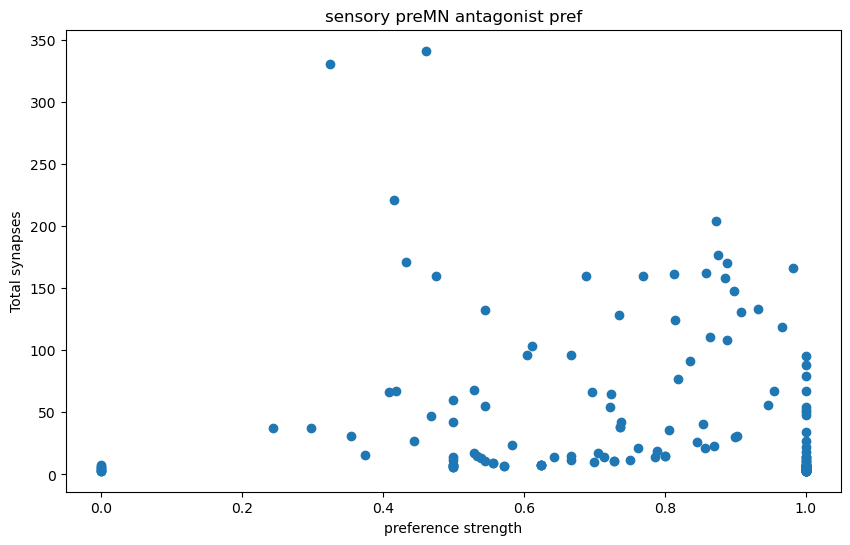

r = -0.34700822044029145, p = 2.5435291005004685e-06


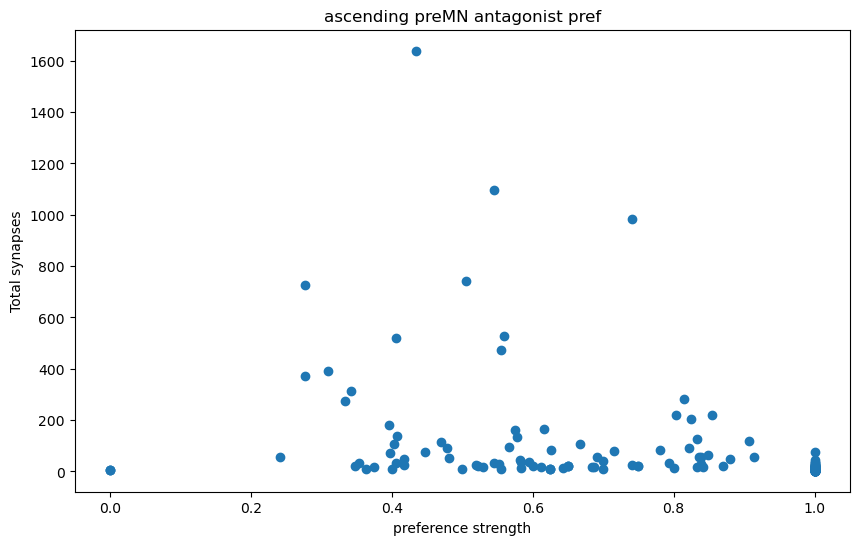

r = -0.36294645215590504, p = 1.0419741503548963e-10


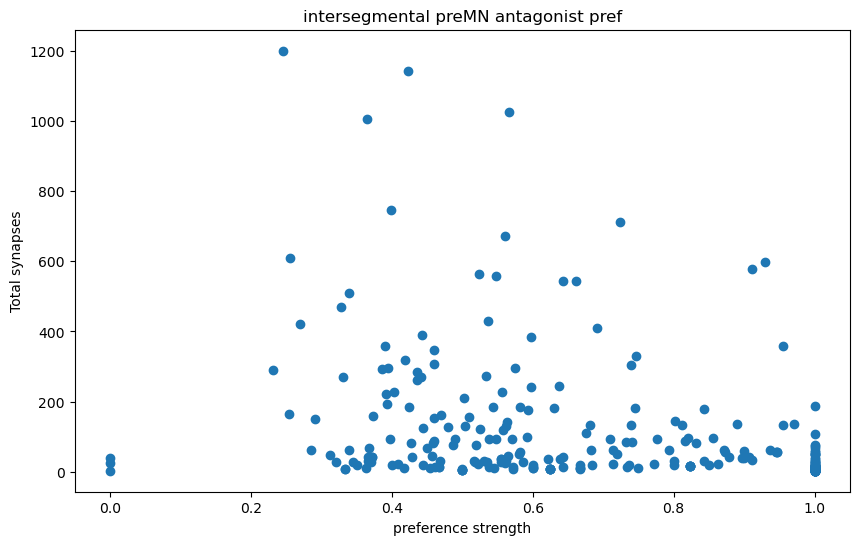

r = -0.17287736412851323, p = 7.227144562781742e-06


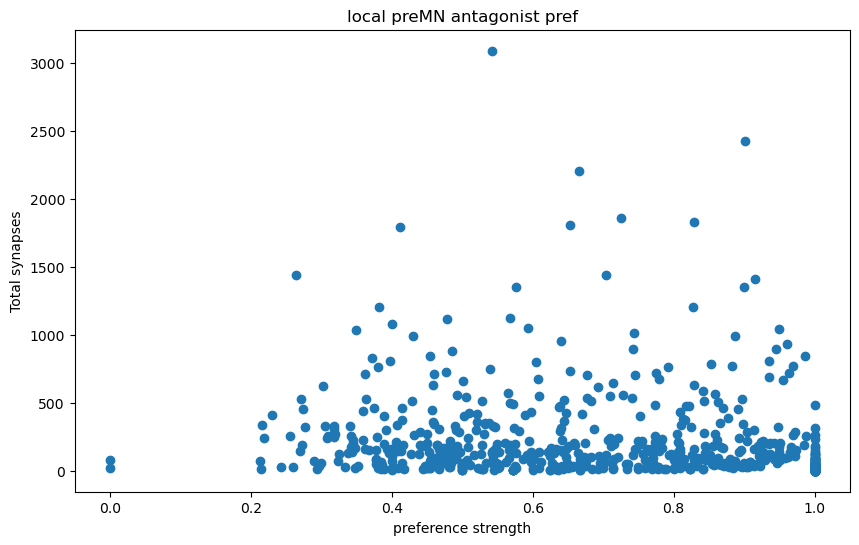

In [180]:
from scipy.stats import pearsonr

pref_total_df = pre_to_mn_pref_df.T.groupby(level='preferred_pool',observed=True).sum().T
denom = pref_total_df.sum(axis=1)
pref_strength_df = pref_total_df.div(denom,axis=0)
# pref_strength_df = pref_strength_df.droplevel(['cell_class','NT','classification_system','cell_type','segID'])
pref_strength_df['total'] = pref_total_df.sum(axis=1)
pref_strength_df['mod_pref'] = 0.

pref_str_segid_df = pref_strength_df.copy()
pref_str_segid_df = pref_str_segid_df.droplevel(['cell_class','preferred_pool','NT','classification_system','cell_type'])
pref_strength_df = pref_strength_df.droplevel(['cell_class','NT','classification_system','cell_type'])

for mod in module_names: 
    each = pref_strength_df.loc[mod,((pref_strength_df.columns.get_level_values('preferred_pool') == mod))]
    pref_str_segid_df.loc[each.index,'mod_pref'] = each.loc[each.index,mod]

pref_str_segid_df.index = pref_total_df.index
for cell_class in pre_to_mn_pref_df.index.get_level_values("cell_class").unique():

    fig = plt.figure(figsize=(10, 6))
    ax = plt.subplot2grid((1,1),(0,0))
    ax.set_xlim([-.05, 1.05])

    ax.set_ylabel('Total synapses')
    ax.set_xlabel('preference strength')
    ax.set_title('{} preMN antagonist pref'.format(cell_class))

    x = pref_str_segid_df.loc[(cell_class,All,All,All,All),'mod_pref']
    y = pref_str_segid_df.loc[(cell_class,All,All,All,All),'total']

    ax.scatter(x,y,label='all')
    if cell_class=='descending':
        x = x[y<600]
        y = y[y<600]
        ax.scatter(x,y,label='select',color='orange')
        print(x.shape)
    correlation_coefficient, p_value = pearsonr(x, y)
    print('r = {}, p = {}'.format(correlation_coefficient,p_value))
    plt.show()
    fig.savefig('./figpanels/pref_total_syn_num_{}.svg'.format(cell_class),format='svg')


In [181]:
pref_str_segid_df.reset_index('cell_class')

preferred_pool                                                                       cell_class  \
preferred_pool          NT   classification_system cell_type     segID                            
coxa_promote            NaN  NaN                   NaN           648518346493883193  descending   
                                                                 648518346497743463  descending   
                                                                 648518346494476087  descending   
                                                                 648518346507377529  descending   
                                                                 648518346494232199  descending   
...                                                                                         ...   
ltm_B                   GABA 19A                   19A_mid       648518346504149710       local   
                             09A                   09A           648518346490340104       local   
                        Ach  22A                   22A_posterior 648518346521544953       local   
tarsus_depress_medial   GABA 12B                   12B           648518346484940957       local   
tarsus_depress_ventralU Ach  03A                   03A           648518346491766952       local   

preferred_pool                                                                       coxa_promote  \
preferred_pool          NT   classification_system cell_type     segID                              
coxa_promote            NaN  NaN                   NaN           648518346493883193      0.701923   
                                                                 648518346497743463      0.920455   
                                                                 648518346494476087      0.895349   
                                                                 648518346507377529      1.000000   
                                                                 648518346494232199      0.625000   
...                                                                                           ...   
ltm_B                   GABA 19A                   19A_mid       648518346504149710      0.000000   
                             09A                   09A           648518346490340104      0.000000   
                        Ach  22A                   22A_posterior 648518346521544953      0.000000   
tarsus_depress_medial   GABA 12B                   12B           648518346484940957      0.000000   
tarsus_depress_ventralU Ach  03A                   03A           648518346491766952      0.084337   

preferred_pool                                                                       coxa_rotate_adduct  \
preferred_pool          NT   classification_system cell_type     segID                                    
coxa_promote            NaN  NaN                   NaN           648518346493883193                 0.0   
                                                                 648518346497743463                 0.0   
                                                                 648518346494476087                 0.0   
                                                                 648518346507377529                 0.0   
                                                                 648518346494232199                 0.0   
...                                                                                                 ...   
ltm_B                   GABA 19A                   19A_mid       648518346504149710                 0.0   
                             09A                   09A           648518346490340104                 0.0   
                        Ach  22A                   22A_posterior 648518346521544953                 0.0   
tarsus_depress_medial   GABA 12B                   12B           648518346484940957                 0.0   
tarsus_depress_ventralU Ach  03A                   03A           648518346491766952                 0.0   

prefer

In [182]:
pref_str_segid_df.log_total.values.min()

AttributeError: 'DataFrame' object has no attribute 'log_total'

c:\Users\tony\miniconda3\envs\fanc_py39_1023\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\tony\miniconda3\envs\fanc_py39_1023\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


r = -0.24531366764498821, p = 1.2719428559925972e-22


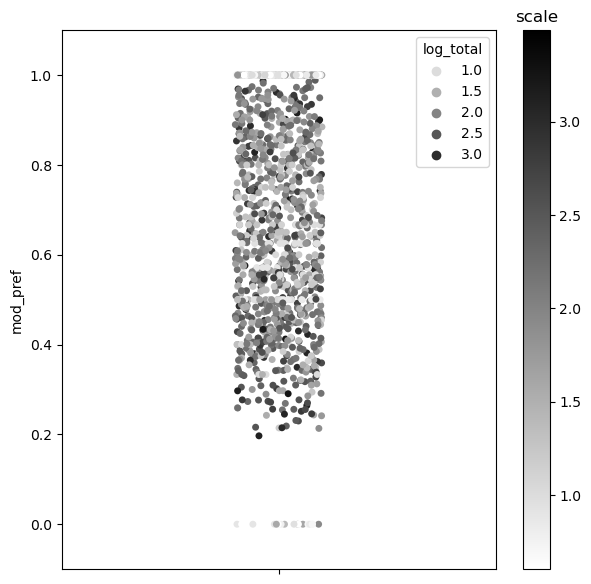

In [183]:
# from matplotlib.cm import ScalarMappable

# f, ax = plt.subplots(figsize=(7, 7))
# pref_str_segid_df['log_total'] = np.log10(pref_str_segid_df['total']+1)
# stripplot  = sns.stripplot(data=pref_str_segid_df.reset_index('cell_class').iloc[::-1],x='cell_class',y='mod_pref',hue='log_total',palette=cos_cmap, ax=ax)

# norm = plt.Normalize(pref_str_segid_df.log_total.values.min(), pref_str_segid_df.log_total.values.max())

# sm =  ScalarMappable(norm=norm,cmap=cos_cmap)
# sm.set_array([])
# cbar = fig.colorbar(sm, ax=ax)
# cbar.ax.set_title("scale")

# ax.set_ylim([-.1, 1.1])
# f.savefig('./figpanels/mod_pref_by_total_synapses.svg',format='svg')

from matplotlib.cm import ScalarMappable

f, ax = plt.subplots(figsize=(7, 7))
pref_str_segid_df['log_total'] = np.log10(pref_str_segid_df['total']+1)
# stripplot  = sns.stripplot(data=pref_str_segid_df.reset_index('cell_class').iloc[::-1],x='cell_class',y='mod_pref',hue='log_total',palette=cos_cmap, ax=ax)
stripplot  = sns.stripplot(data=pref_str_segid_df.reset_index('cell_class').iloc[::-1],y='mod_pref',hue='log_total',palette=cos_cmap, ax=ax)
norm = plt.Normalize(pref_str_segid_df.log_total.values.min(), pref_str_segid_df.log_total.values.max())

sm =  ScalarMappable(norm=norm,cmap=cos_cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.ax.set_title("scale")

ax.set_ylim([-.1, 1.1])
f.savefig('./figpanels/mod_pref_by_total_synapses_leg.svg',format='svg')

correlation_coefficient, p_value = pearsonr(pref_str_segid_df['mod_pref'],pref_str_segid_df['total'])
print('r = {}, p = {}'.format(correlation_coefficient,p_value))

In [184]:
pref_str_segid_df.log_total.values.max()

3.4900990050633047

# Distribution of similarity under pool shuffle
Finally, a key question: How likely are the cosine similarity under shuffling within pools?

In [185]:
mn_mi_df = pre_to_mn_df.columns.to_frame()
mn_mi_df

# Ha! for this, put the tarsus neurons in the right pools
muscle_tuple_dict = utils.get_motor_pool_tuple_dict()
pool_keys = utils.ta_assigned_pools_coxa_ab()

for key in pool_keys:
    mn_tup = muscle_tuple_dict[key]
    mn_mi_df.loc[mn_tup,'preferred_pool'] = key

pool_keys.append('asterix')
mn_mi_df.loc[mn_mi_df.segID==mn_mi_df.iloc[21].segID,'preferred_pool'] = 'asterix'

mn_mi_df.preferred_pool = mn_mi_df.preferred_pool.astype("category")
mn_mi_df.preferred_pool = mn_mi_df.preferred_pool.cat.set_categories(pool_keys) 
mn_mi_df.iloc[21]
module_names = mn_mi_df.preferred_pool.unique().to_list()

pre_to_mn_pref_df = pre_to_mn_df.copy()
pre_to_mn_pref_df.columns = pd.MultiIndex.from_frame(mn_mi_df)
pre_to_mn_pref_df.head()

C:\Users\tony\AppData\Local\Temp\ipykernel_18588\1848208707.py:18: FutureWarning: Categorical.to_list is deprecated and will be removed in a future version. Use obj.tolist() instead
  module_names = mn_mi_df.preferred_pool.unique().to_list()


side                                                                                                                               L  \
nerve                                                                                                                         Dorsal   
segment                                                                                                                       thorax   
function                                                                                                                       swing   
muscle                                                                           tergopleural_promotor_pleural_promotor_miller_28_30   
rank                                                                                                                               0   
segID                                                                                                             648518346487756866   
module                                                                                                                  coxa_promote   
preferred_pool                                                                                                          coxa_promote   
cell_class preferred_pool NT  classification_system cell_type segID                                                                    
descending coxa_promote   NaN NaN                   NaN       648518346493883193                                                  0    
                                                              648518346497743463                                                  0    
                                                              648518346494476087                                                  0    
                                                              648518346507377529                                                  0    
                                                              648518346494232199                                                  0    

side                                                                                                 \
nerve                                                                                                 
segment                                                                                               
function                                                                                              
muscle                                                                                                
rank                                                                                                  
segID                                                                            648518346491659326   
module                                                                                 coxa_promote   
preferred_pool                                                                         coxa_promote   
cell_class preferred_pool NT  classification_system cell_type segID                                   
descending coxa_promote   NaN NaN                   NaN       648518346493883193                 17   
                                                              648518346497743463                 42   
                                                              648518346494476087                 13   
                                                              648518346507377529                 12   
                                                              648518346494232199                 11   

side                                                                                                 \
nerve                                                                                                 
segment                                                                                               
function                                                                                              
m

(1546, 66)
(1529, 66)
coxa_promote


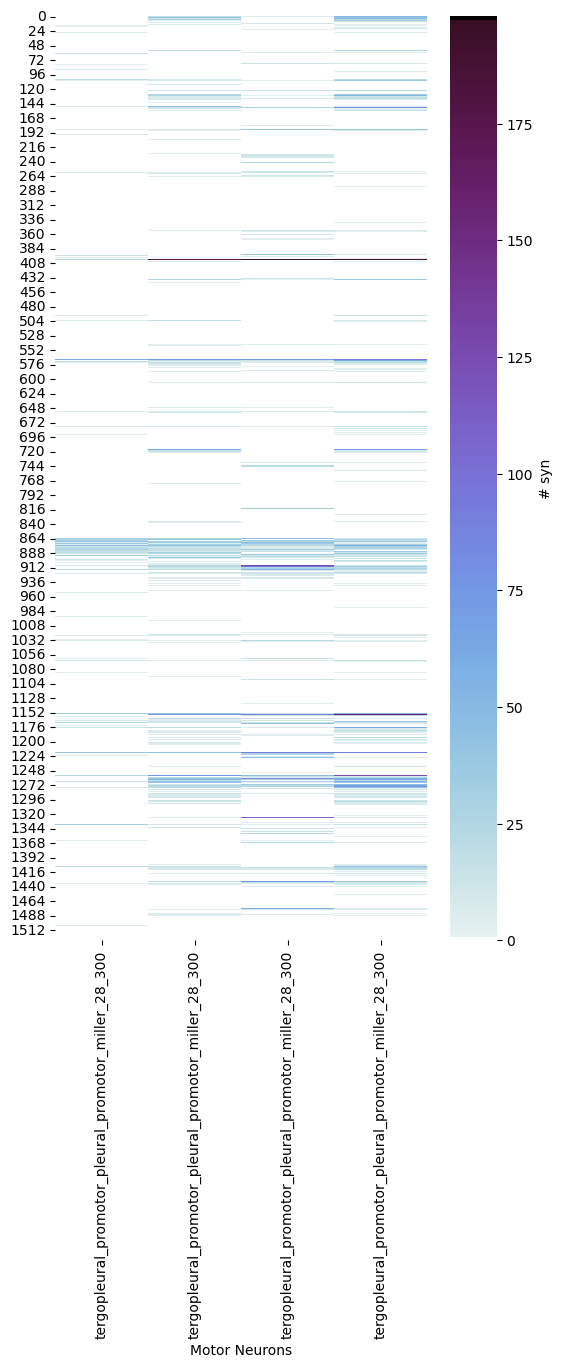

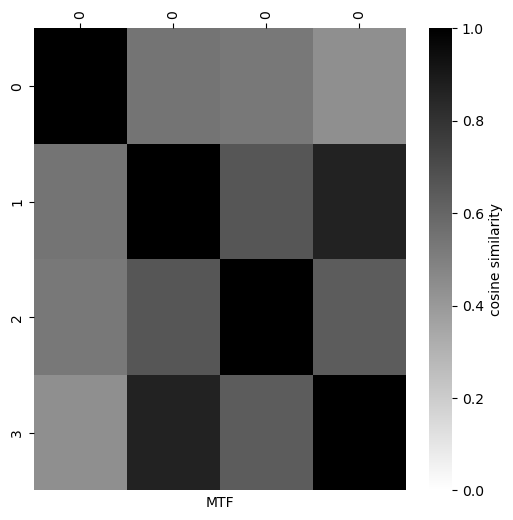

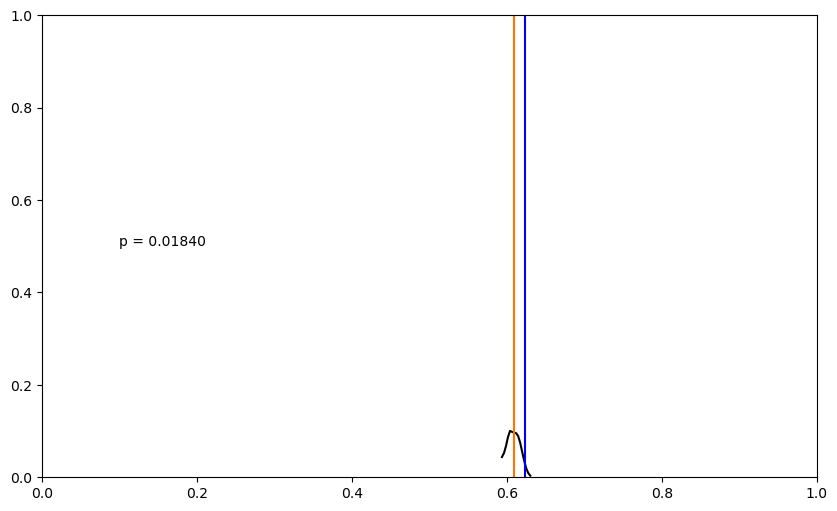

coxa_rotate_adduct


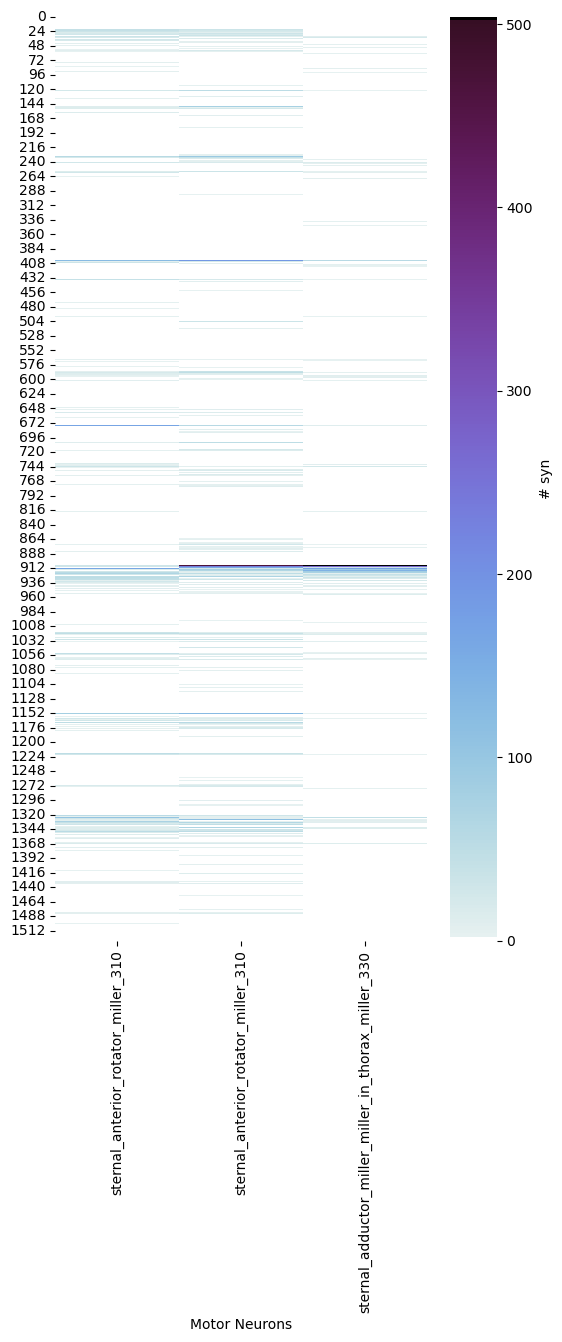

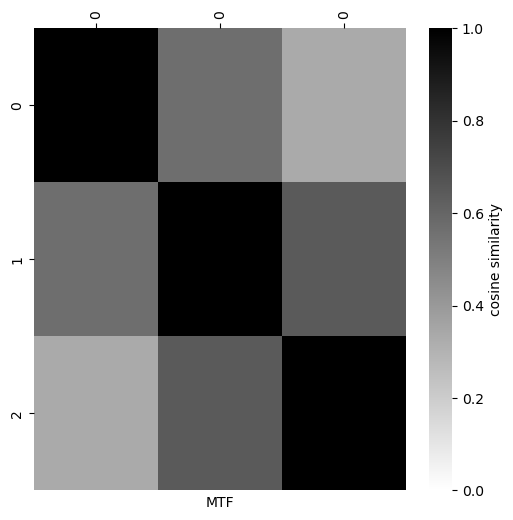

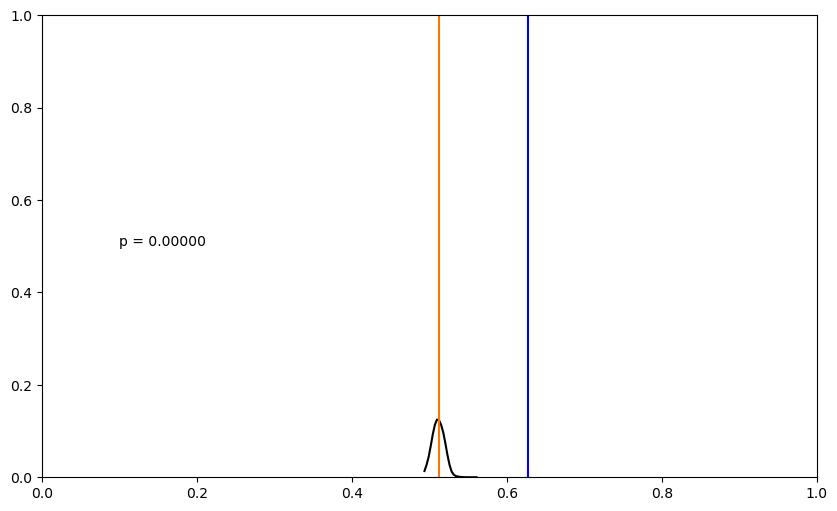

coxa_posterior


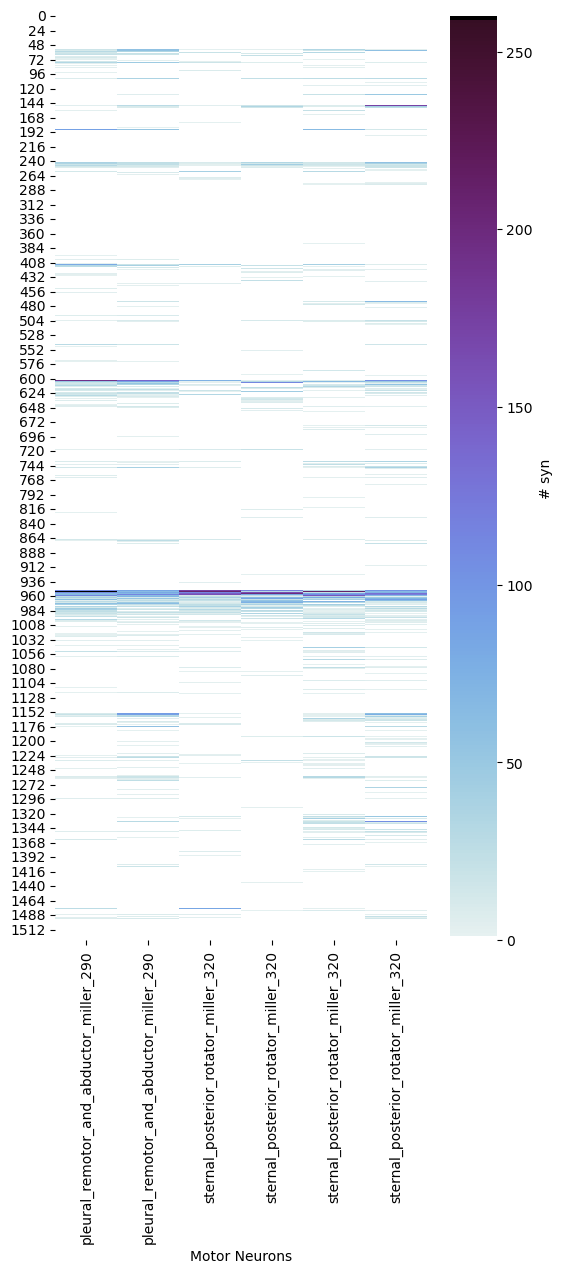

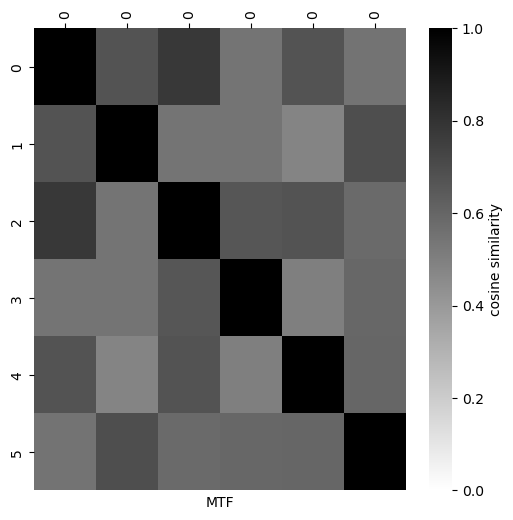

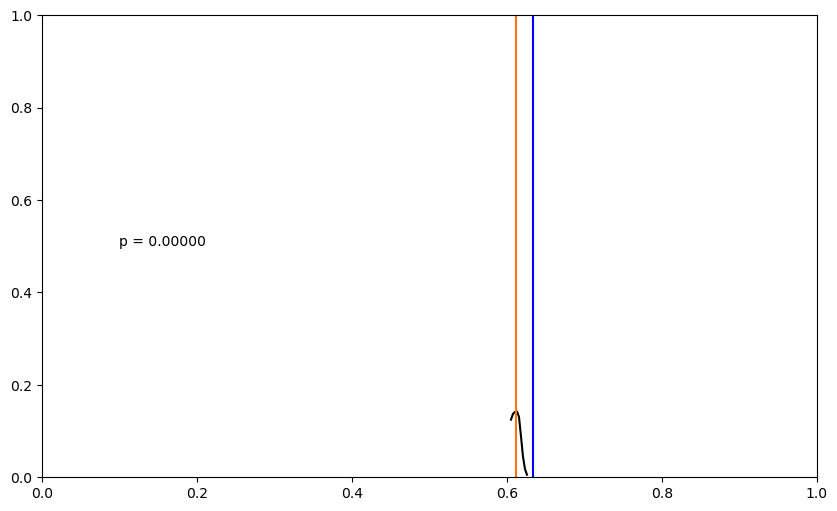

trochanter_extend


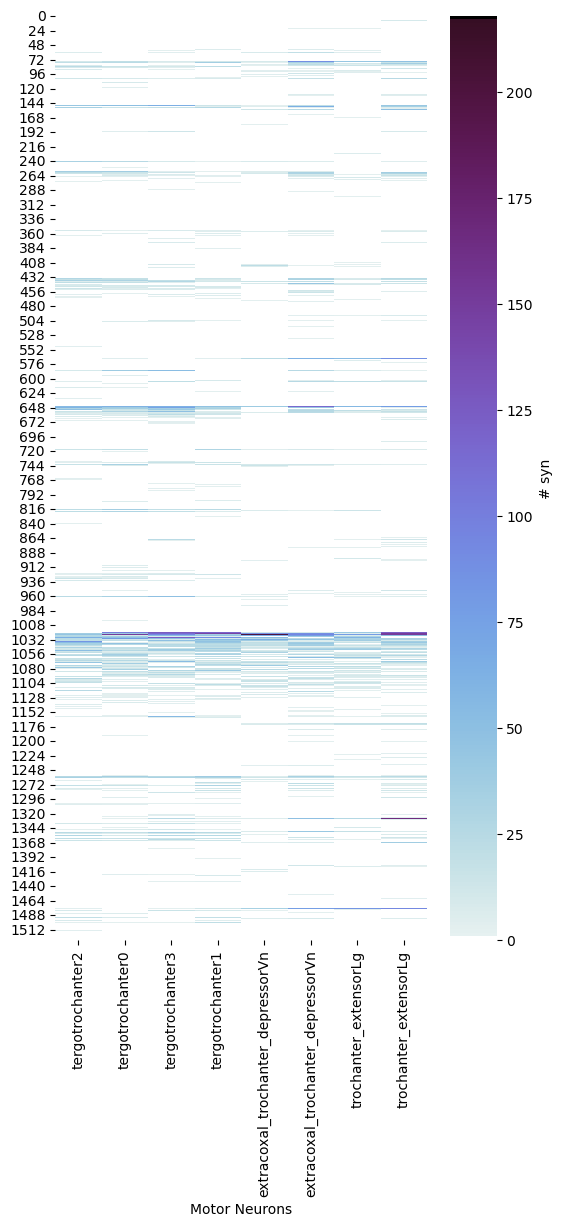

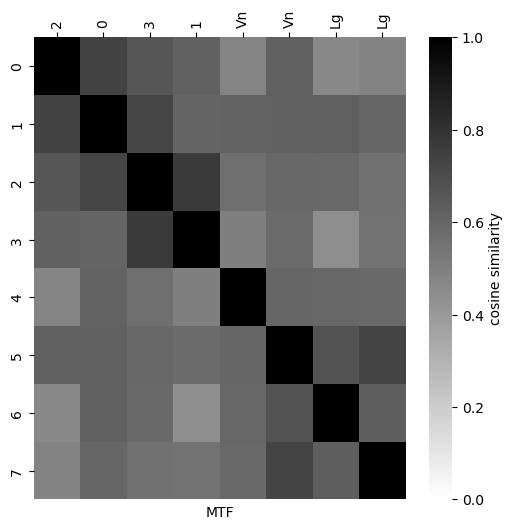

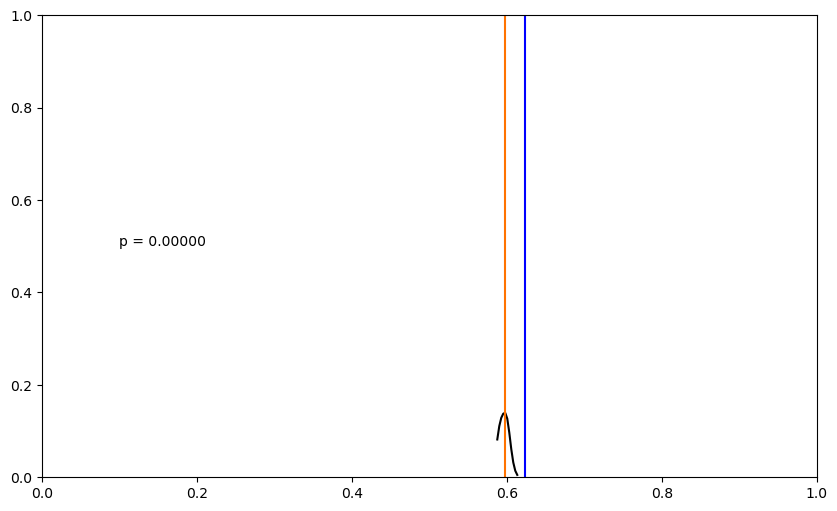

trochanter_flex


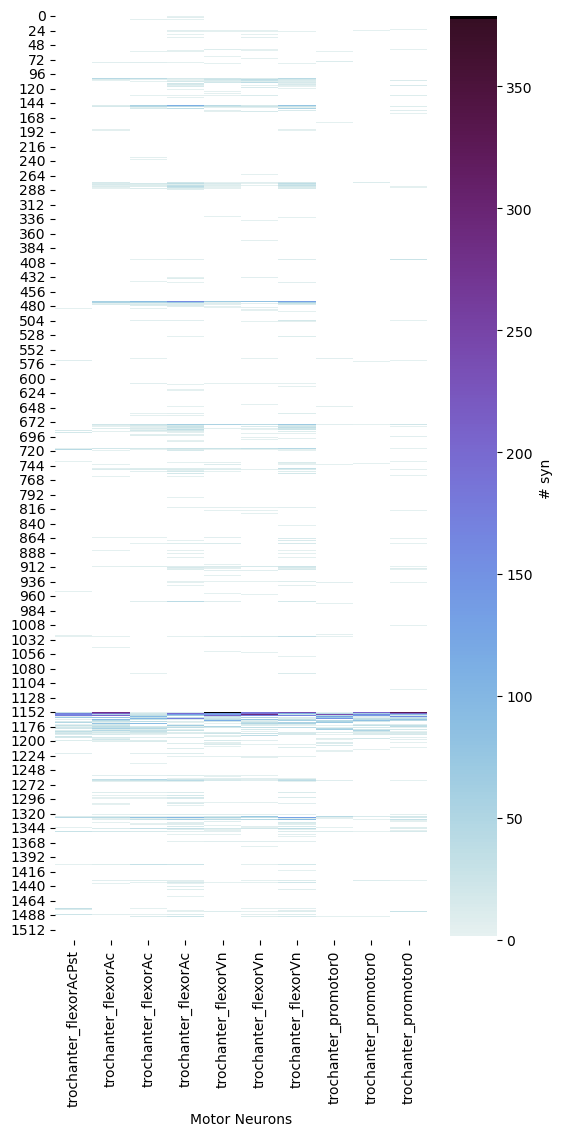

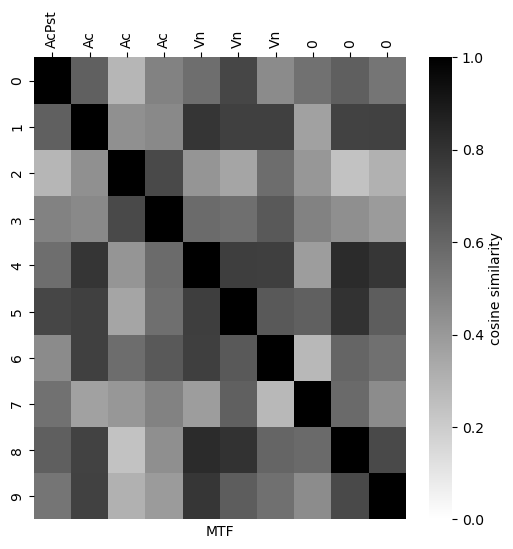

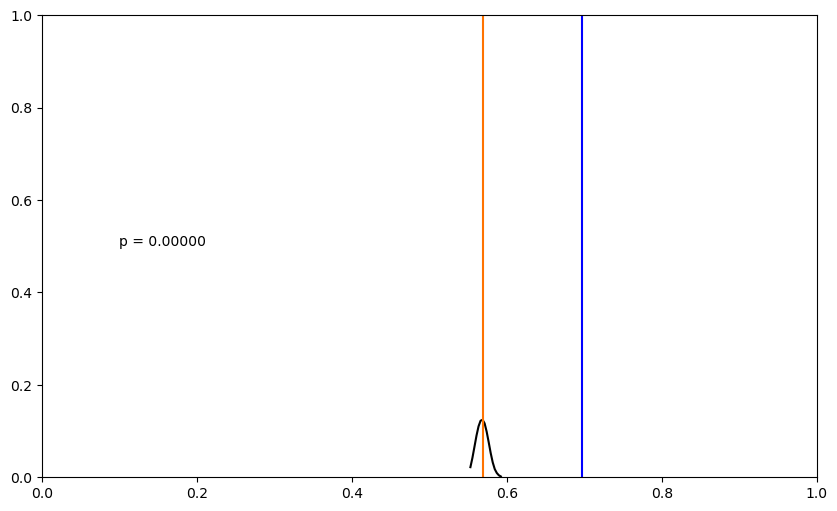

femur_reduct


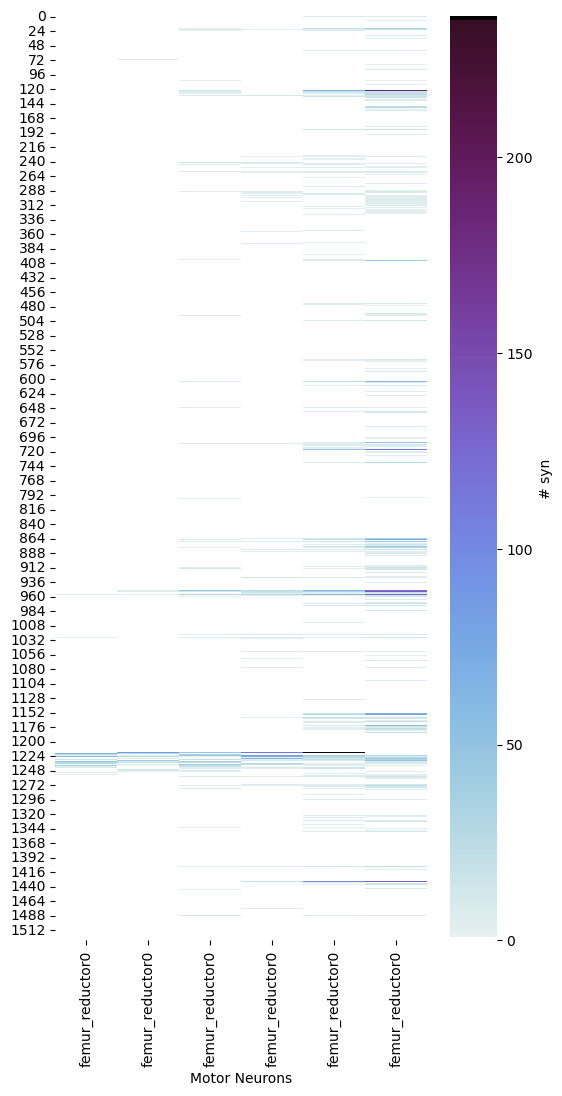

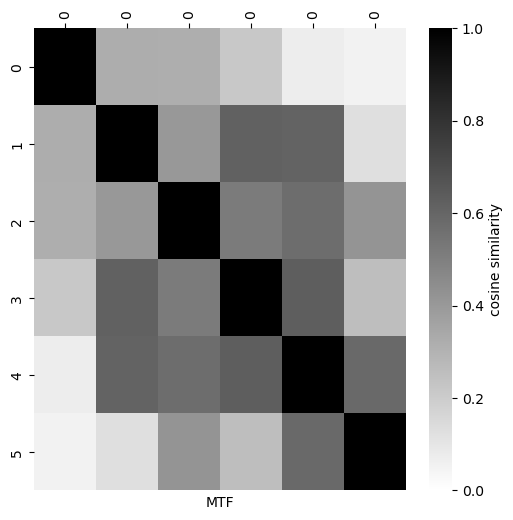

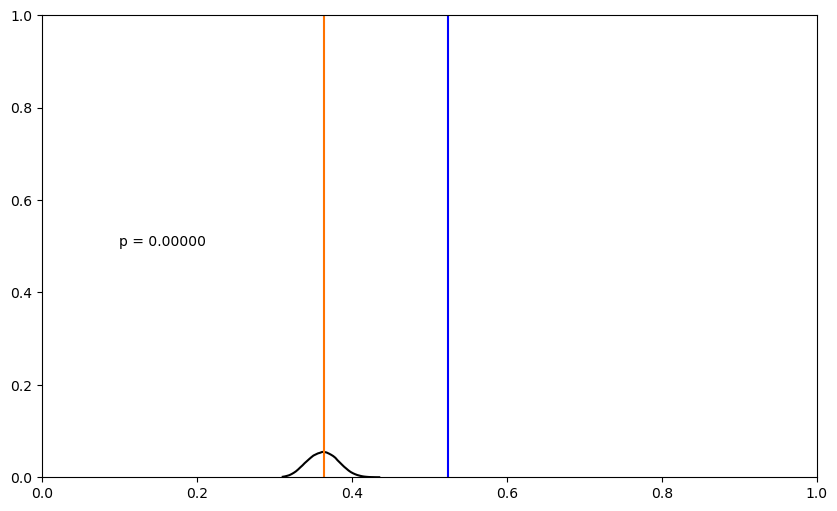

tibia_extend


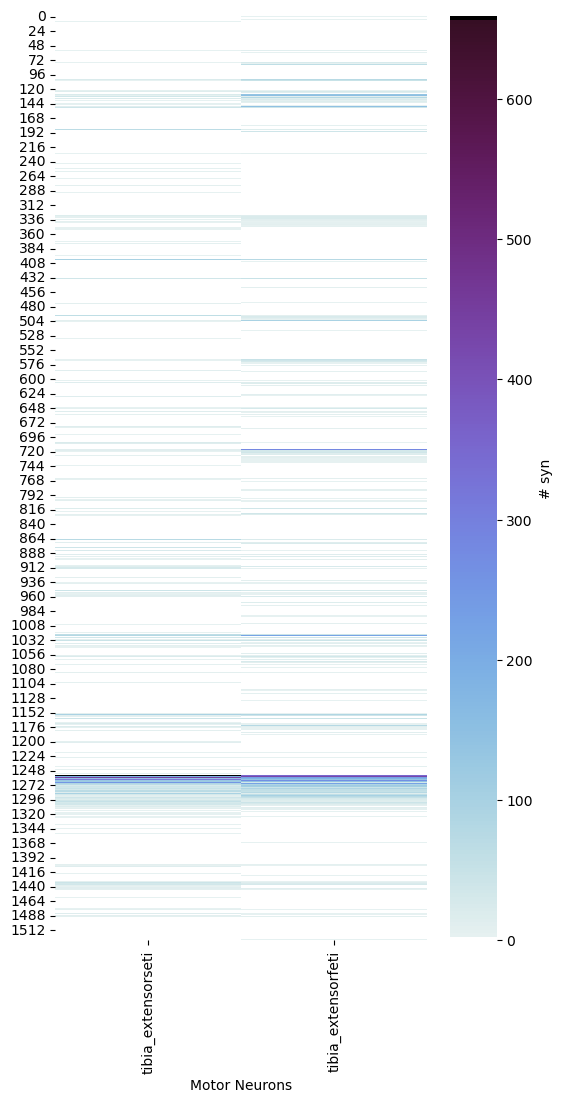

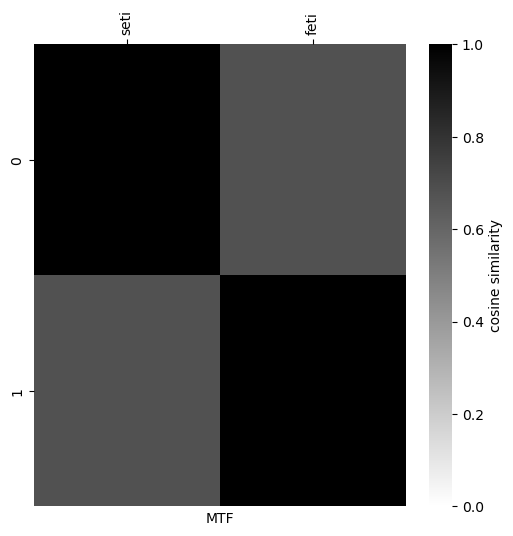

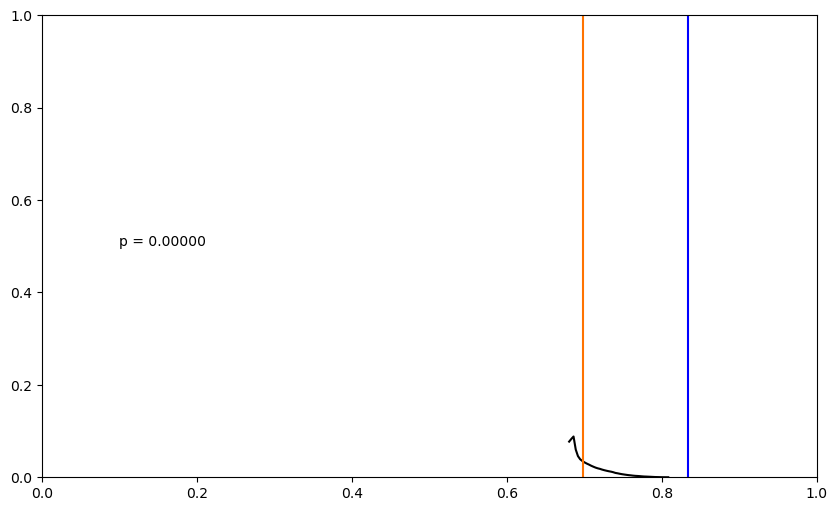

tibia_ta_flex_A


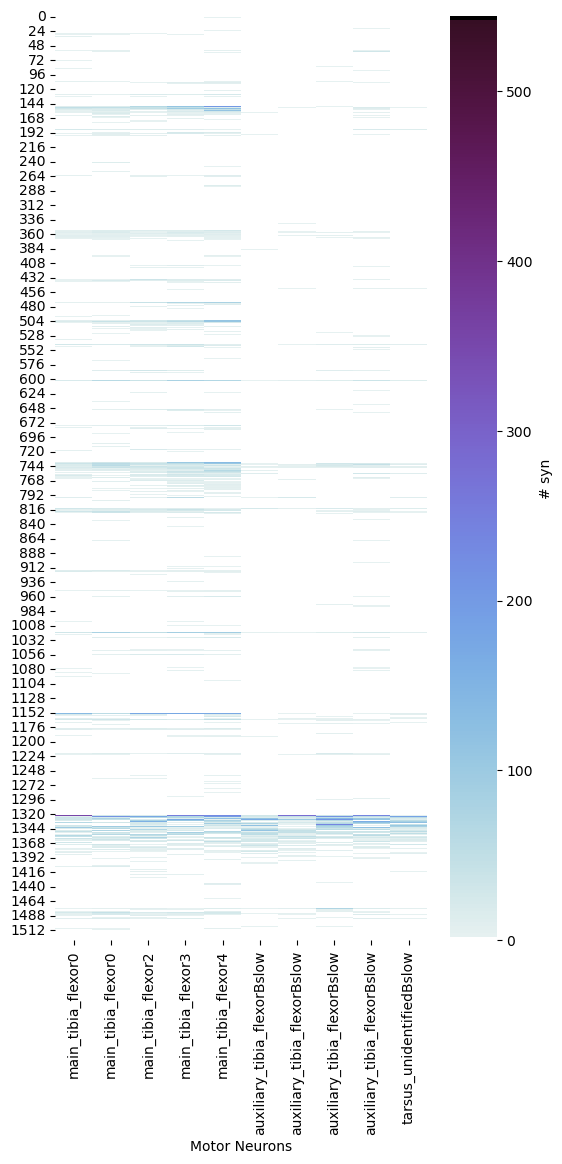

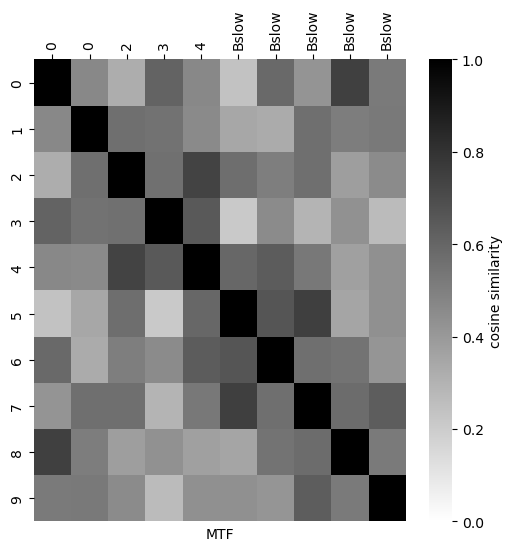

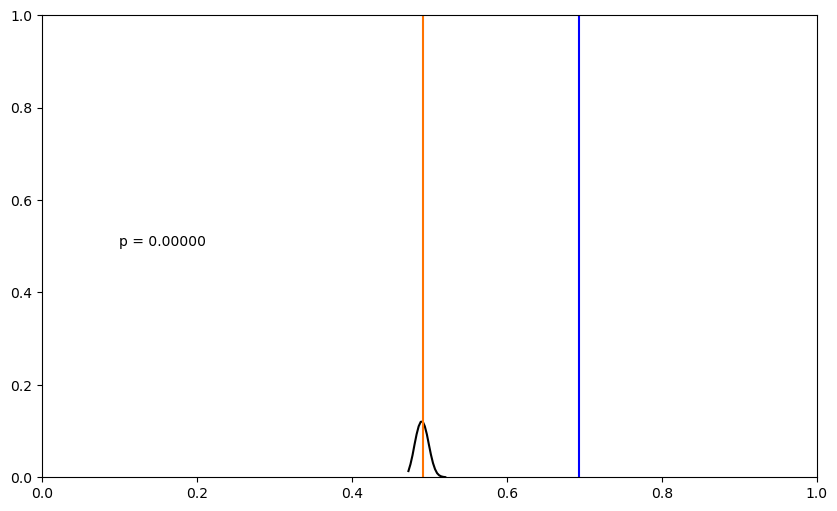

tibia_ta_flex_B


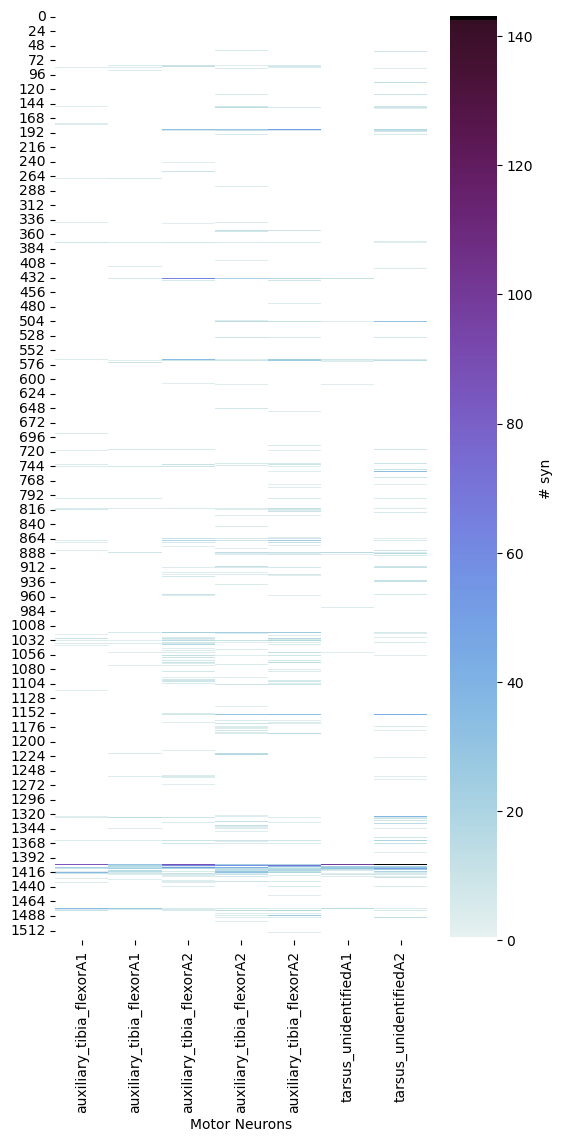

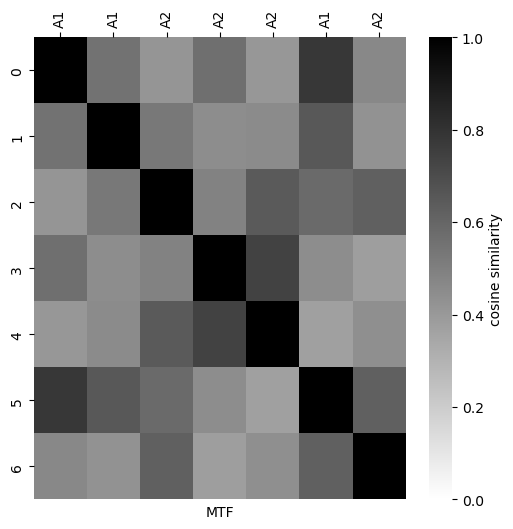

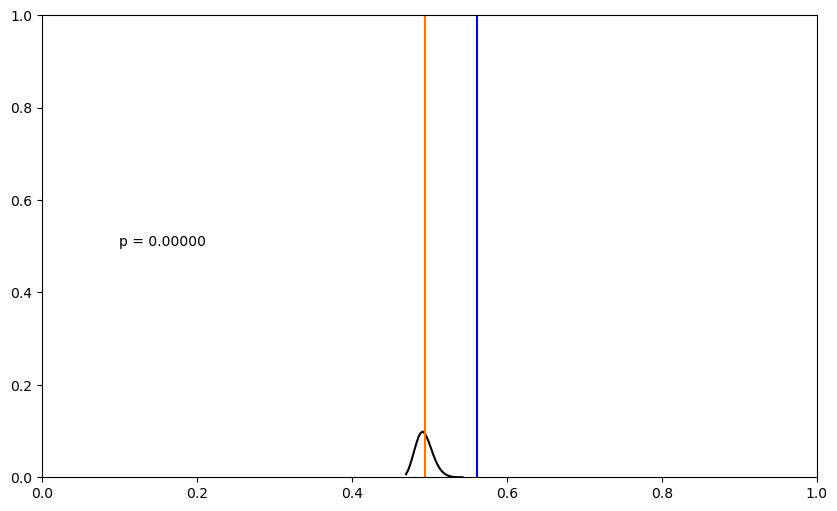

tibia_ta_flex_C


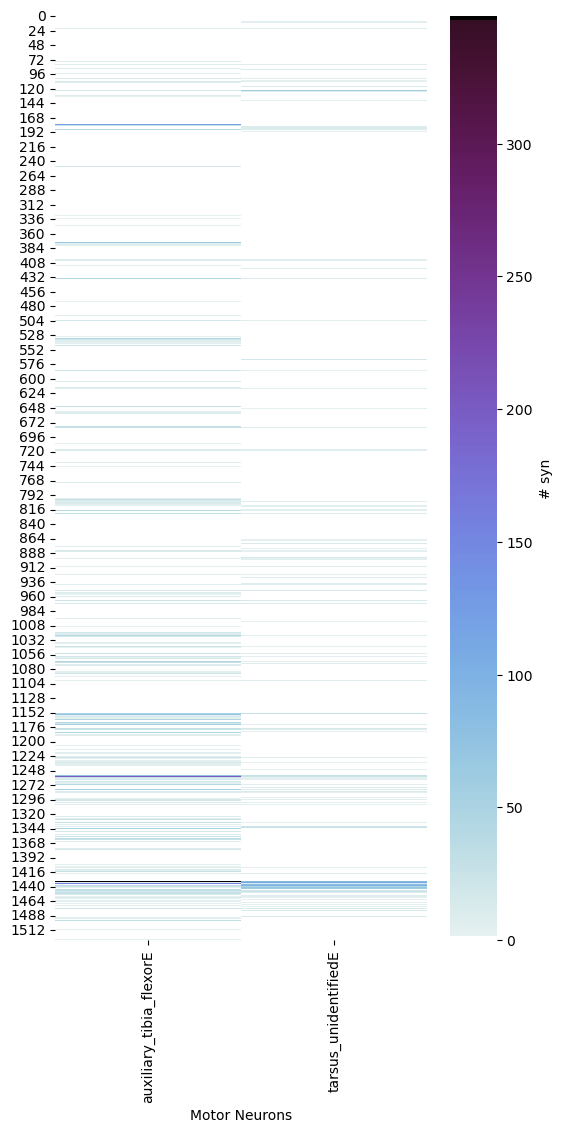

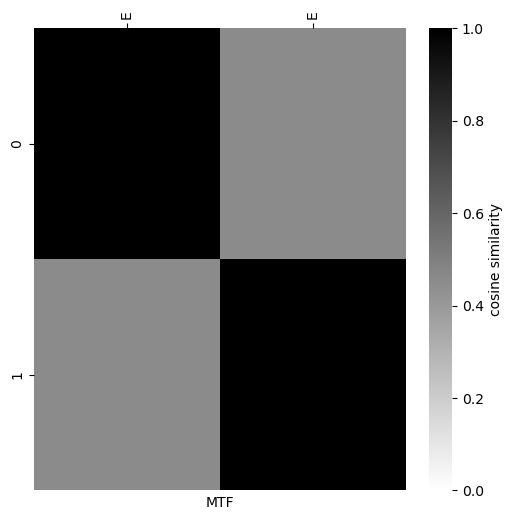

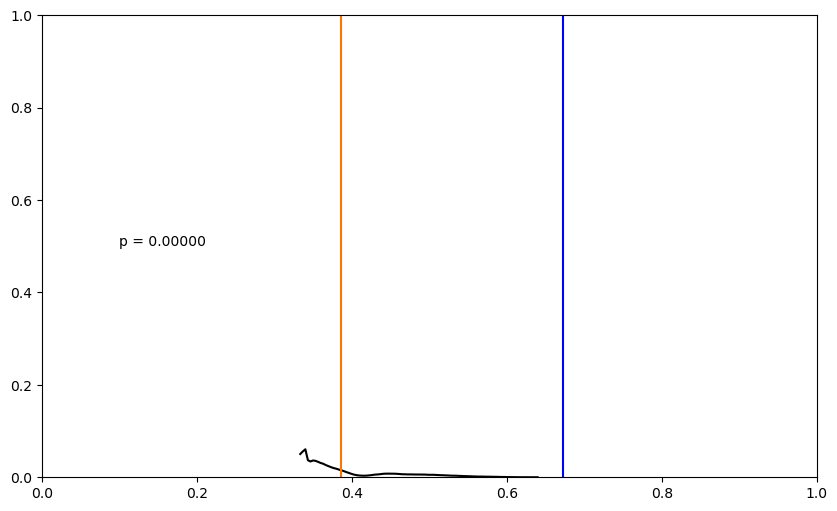

ltm_A


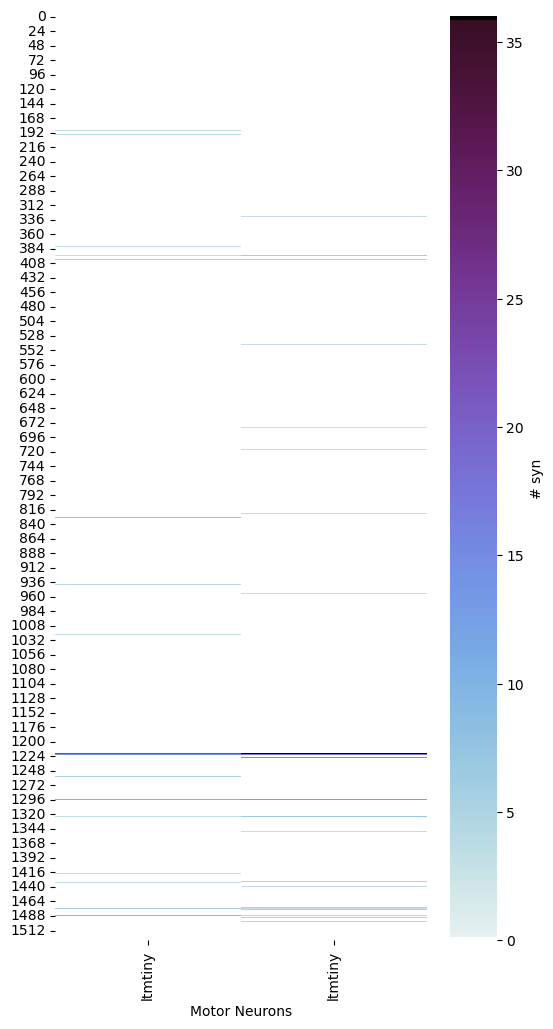

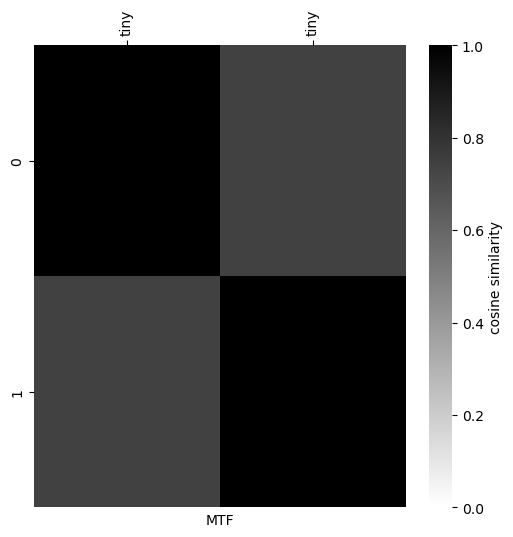

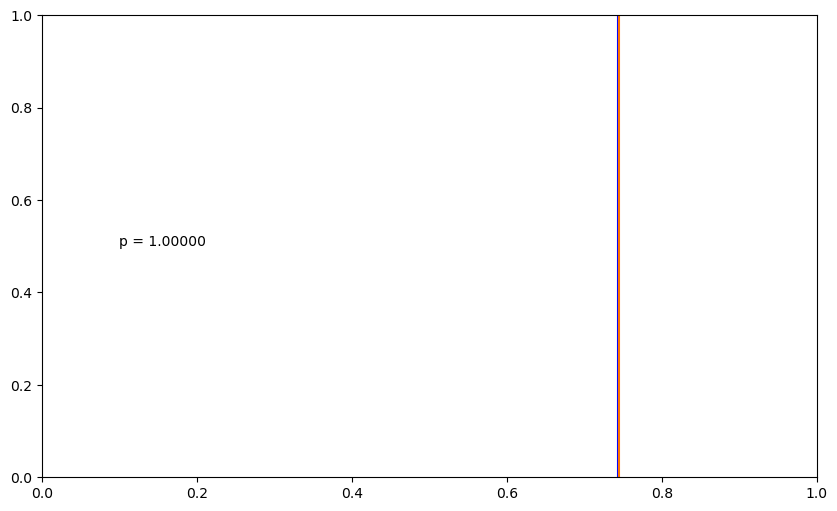

ltm_B


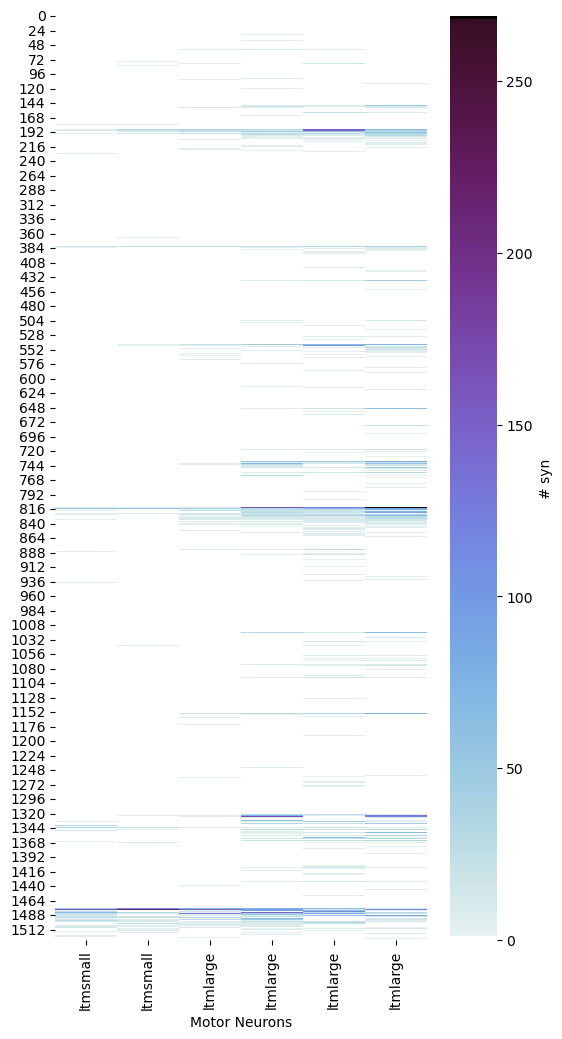

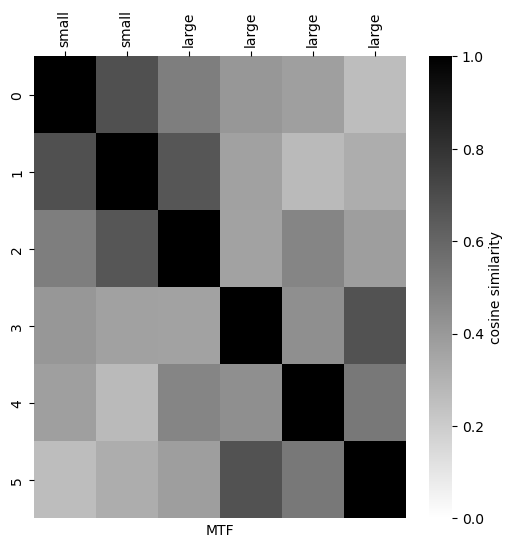

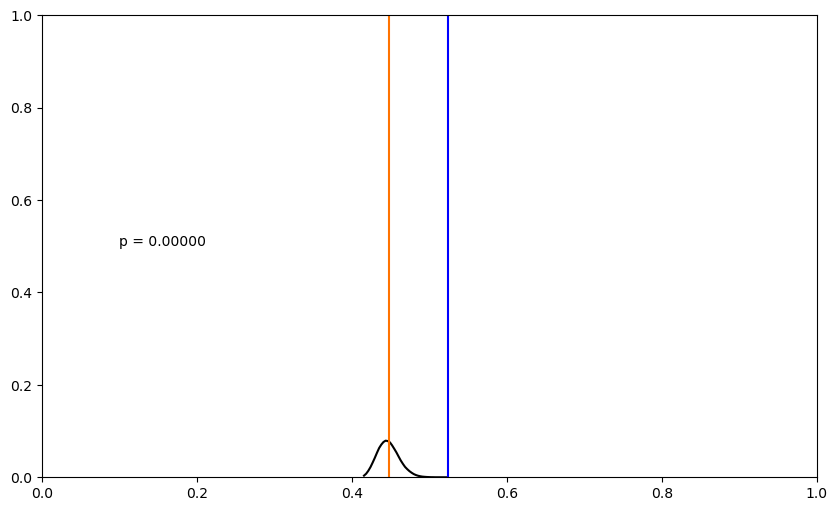

In [186]:
rng = np.random.default_rng()

mod_all = ['coxa_promote',
 'coxa_rotate_adduct',
 'coxa_posterior',
 'trochanter_extend',
 'asterix',
 'trochanter_flex',
 'femur_reduct',
 'tibia_extend',
 'tibia_ta_flex_A',
 'tibia_ta_flex_B',
 'tibia_ta_flex_C',
 'ltm_A',
 'ltm_B',
 'tarsus_depressor_medial',
 'tarsus_depressor_ventralU']

mod_filter = ['coxa_promote',
 'coxa_rotate_adduct',
 'coxa_posterior',
 'trochanter_extend',
 #'asterix',
 'trochanter_flex',
 'femur_reduct',
 'tibia_extend',
 'tibia_ta_flex_A',
 'tibia_ta_flex_B',
 'tibia_ta_flex_C',
 'ltm_A',
 'ltm_B',
 #'tarsus_depressor_medial',
 #'tarsus_depressor_ventralU'
 ]

large_mods = pre_to_mn_pref_df.loc[:,pre_to_mn_pref_df.columns.get_level_values('preferred_pool').isin(mod_filter)] # rowsorted
print(large_mods.shape)
large_mods = large_mods.loc[large_mods.sum(axis=1)>0,:]
print(large_mods.shape)

mn_mi_df = large_mods.columns.to_frame() # rowsorted_wing
module_names = list(mn_mi_df.preferred_pool.unique())
module_names

cos_sim_mean_dict = {}
mixups_dict = {}
mixups_means_dict = {}
pct_below_actual = {}
p_dict = {}


pat = 1
N=10000
fcnt = 0

for modl in module_names:
    print(modl)

    # try a few different ways to do this:

    if pat==1:
        # 1) just shuffle local neurons, use all
        mod_df = large_mods.loc[:,large_mods.columns.get_level_values('preferred_pool').isin([modl])]
        class_list = ['local']
    if pat==2:
        # 2) shuffle all neurons, use all
        mod_df = large_mods.loc[:,large_mods.columns.get_level_values('preferred_pool').isin([modl])]
        class_list = All
    if pat==3:
        # 3) shuffle local neurons, use local
        mod_df = large_mods.loc[(['local'],All,All,All,All),large_mods.columns.get_level_values('preferred_pool').isin([modl])]
        class_list = All
    

    sim_mat = cosine_similarity(mod_df.to_numpy().transpose())
    
    mask_df = pd.DataFrame(data=np.full(mod_df.shape, False),index=mod_df.index,columns=mod_df.columns)
    mask_df.loc[(class_list,[modl],All,All,All)] = True
    mask_modl = mask_df.to_numpy().copy()

    pair_wise_comparisons = np.tril(np.full(sim_mat.shape,True),k=-1)
    cos_sim_mean_dict[modl] = sim_mat[pair_wise_comparisons].mean()

    mixups = np.zeros((N,sim_mat[pair_wise_comparisons].size))
    mixupmat = mod_df.to_numpy().copy()

    pltflp=True
    for r in range(N): # range(N):
        # Do this for all of the masks
        mixup = mix_up_columns_under_mask(mixupmat,mask=mask_modl,rng=rng)
        sim_mat = cosine_similarity(mixup.transpose())
        mixups[r,:] = sim_mat[pair_wise_comparisons]

        if r>998 and pltflp: # Check the mixups
            plot_conn_map(mixup,mod_df,fn=None) # plot_conn_map(mixup,mod_df,fn='{}_dense_not_proportional'.format(modl))
            plot_sim_map(sim_mat,mod_df,fn=None) # plot_sim_map(sim_mat,mod_df,fn='{}_dense_not_pro_sim'.format(modl))
            pltflp=False

    mixups_dict[modl] = mixups
    mixups_means_dict[modl] = mixups.mean(axis=1)

    pct_below_actual[modl] = (mixups_means_dict[modl]<cos_sim_mean_dict[modl]).sum() / len(mixups_means_dict[modl])
    p_dict[modl]=1-pct_below_actual[modl]

    # for modl,f in zip(module_names,range(len(module_names))):
    fcnt = fcnt+1
    # plot_shuf_cdf(mixups_means_dict[modl],color = '#000000',ref_x=cos_sim_mean_dict[modl],fignum=fcnt,title=modl)
    plot_normalized_pdf(mixups_means_dict[modl],color = '#000000',ref_x=cos_sim_mean_dict[modl], fn='pairwise_pdf_{}_leg_to_{}_ref'.format(fcnt,modl),fignum=fcnt,title=modl)
    plt.show()


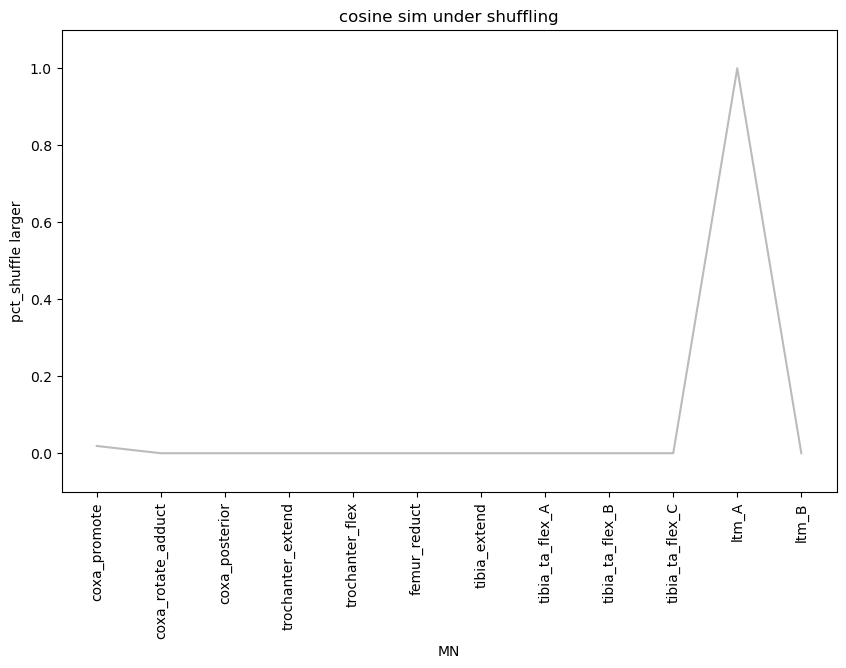

In [158]:
pct_larger_shuffles = p_dict.values


# plot the MWU AUC curves
fig = plt.figure(cnt, figsize=(10, 6))
ax = plt.subplot()
ax.set_ylim([-.1, 1.1])
ax.set_ylabel('pct_shuffle larger')
ax.set_xlabel('MN')
ax.set_title('cosine sim under shuffling')
# ax.xaxis.set_ticks_position('top')
ax.set_xticks(range(len(p_dict.values())))
ax.set_xticklabels(p_dict.keys(),rotation = 90)


# ax.plot([0,len(mwu_val)],[mwu_val_max,mwu_val_max],color='#000000',linestyle='dashed')
ax.plot(range(len(p_dict.values())),p_dict.values(),color='#BBBBBB')
fig.savefig('./figpanels/pct_larger_leg.svg',format='svg')

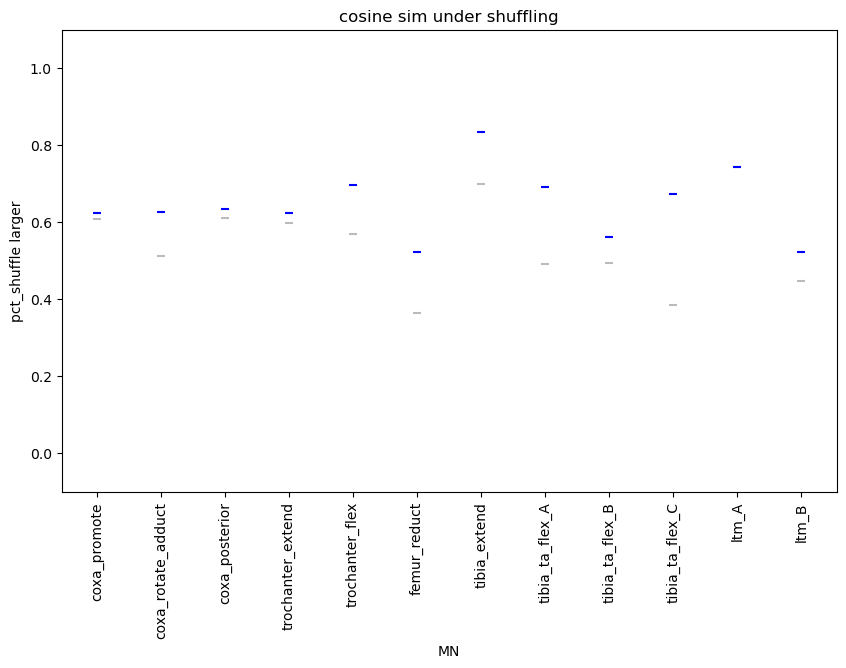

In [159]:

# plot the MWU AUC curves
fig = plt.figure(1, figsize=(10, 6))
ax = plt.subplot()
ax.set_ylim([-.1, 1.1])
ax.set_ylabel('pct_shuffle larger')
ax.set_xlabel('MN')
ax.set_title('cosine sim under shuffling')
# ax.xaxis.set_ticks_position('top')
ax.set_xticks(range(len(p_dict.values())))
ax.set_xticklabels(p_dict.keys(),rotation = 90)

mixups_means_means = {}
for modl in mixups_means_dict.keys():
    mixups_means_means[modl] = mixups_means_dict[modl].mean()
# ax.plot([0,len(mwu_val)],[mwu_val_max,mwu_val_max],color='#000000',linestyle='dashed')
ax.scatter(range(len(mixups_means_means.values())),mixups_means_means.values(),color='#BBBBBB',marker='_',)
ax.scatter(range(len(cos_sim_mean_dict.values())),cos_sim_mean_dict.values(),color='#0000FF',marker='_',)

fig.savefig('./figpanels/mean_cosine_sim_with_shuffles.svg',format='svg')